# Using CNN for dogs vs cats

We are going to create a model to enter the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) competition at Kaggle.

There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): *"**State of the art**: The current literature suggests machine classifiers can score above 80% accuracy on this task"*. So if you can beat 80%, then you will be at the cutting edge as of 2013!

##  Imports

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import models,transforms,datasets
import torch
import bcolz
import time
%matplotlib inline

In [2]:
import imp
import utils; imp.reload(utils)
from utils import *

In [3]:
torch.__version__

'0.4.1'

Check if GPU is available and if so use it by default, otherwise use CPU only.

In [4]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

Using gpu: True 


## Data processing

You can download the full dataset from Kaggle directly.

Alternatively, Jeremy Howard provides a direct link to the catvsdogs [dataset](http://files.fast.ai/data/dogscats.zip). He's separated the cats and dogs into separate folders and created a validation folder as well. You'll need this folder structure to run VGG.

For test purpose (or if you run on cpu), you should use the (small) sample directory available on the [GitHub repo](https://github.com/abursuc/dldiy-practicals)

In [5]:
%ls

01_intro.ipynb  __pycache__/  utils.py  vgg16.png


In [6]:
%pwd

'/home/ubuntu/dataflowr/Notebooks'

In [9]:
%cd /home/ubuntu/data/

/home/ubuntu/data


In [11]:
!wget http://files.fast.ai/data/dogscats.zip

--2018-09-14 07:32:39--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: 'dogscats.zip'

dogscats.zip        100%[===================>] 817.50M  16.2MB/s    in 50s     

2018-09-14 07:33:30 (16.4 MB/s) - 'dogscats.zip' saved [857214334/857214334]



In [12]:
%ls

dogscats.zip


In [13]:
!unzip dogscats.zip

Archive:  dogscats.zip
   creating: dogscats/
   creating: dogscats/sample/
   creating: dogscats/sample/train/
   creating: dogscats/sample/train/cats/
  inflating: dogscats/sample/train/cats/cat.2921.jpg  
  inflating: dogscats/sample/train/cats/cat.394.jpg  
  inflating: dogscats/sample/train/cats/cat.4865.jpg  
  inflating: dogscats/sample/train/cats/cat.3570.jpg  
  inflating: dogscats/sample/train/cats/cat.2266.jpg  
  inflating: dogscats/sample/train/cats/cat.9021.jpg  
  inflating: dogscats/sample/train/cats/cat.11737.jpg  
  inflating: dogscats/sample/train/cats/cat.4600.jpg  
   creating: dogscats/sample/train/dogs/
  inflating: dogscats/sample/train/dogs/dog.1402.jpg  
  inflating: dogscats/sample/train/dogs/dog.1614.jpg  
  inflating: dogscats/sample/train/dogs/dog.8643.jpg  
  inflating: dogscats/sample/train/dogs/dog.6391.jpg  
  inflating: dogscats/sample/train/dogs/dog.2423.jpg  
  inflating: dogscats/sample/train/dogs/dog.9077.jpg  
  inflating: dogscats/sample/train/d

  inflating: dogscats/train/cats/cat.11413.jpg  
  inflating: dogscats/train/cats/cat.8359.jpg  
  inflating: dogscats/train/cats/cat.11741.jpg  
  inflating: dogscats/train/cats/cat.8742.jpg  
  inflating: dogscats/train/cats/cat.569.jpg  
  inflating: dogscats/train/cats/cat.10452.jpg  
  inflating: dogscats/train/cats/cat.11746.jpg  
  inflating: dogscats/train/cats/cat.2080.jpg  
  inflating: dogscats/train/cats/cat.3399.jpg  
  inflating: dogscats/train/cats/cat.11258.jpg  
  inflating: dogscats/train/cats/cat.5613.jpg  
  inflating: dogscats/train/cats/cat.7032.jpg  
  inflating: dogscats/train/cats/cat.3647.jpg  
  inflating: dogscats/train/cats/cat.11270.jpg  
  inflating: dogscats/train/cats/cat.8634.jpg  
  inflating: dogscats/train/cats/cat.2087.jpg  
  inflating: dogscats/train/cats/cat.7038.jpg  
  inflating: dogscats/train/cats/cat.680.jpg  
  inflating: dogscats/train/cats/cat.4748.jpg  
  inflating: dogscats/train/cats/cat.5665.jpg  
  inflating: dogscats/train/cats/cat

  inflating: dogscats/train/cats/cat.4167.jpg  
  inflating: dogscats/train/cats/cat.3453.jpg  
  inflating: dogscats/train/cats/cat.461.jpg  
  inflating: dogscats/train/cats/cat.8477.jpg  
  inflating: dogscats/train/cats/cat.332.jpg  
  inflating: dogscats/train/cats/cat.2513.jpg  
  inflating: dogscats/train/cats/cat.8088.jpg  
  inflating: dogscats/train/cats/cat.11990.jpg  
  inflating: dogscats/train/cats/cat.5984.jpg  
  inflating: dogscats/train/cats/cat.9082.jpg  
  inflating: dogscats/train/cats/cat.11933.jpg  
  inflating: dogscats/train/cats/cat.5405.jpg  
  inflating: dogscats/train/cats/cat.11222.jpg  
  inflating: dogscats/train/cats/cat.11739.jpg  
  inflating: dogscats/train/cats/cat.9221.jpg  
  inflating: dogscats/train/cats/cat.8868.jpg  
  inflating: dogscats/train/cats/cat.1795.jpg  
  inflating: dogscats/train/cats/cat.253.jpg  
  inflating: dogscats/train/cats/cat.11852.jpg  
  inflating: dogscats/train/cats/cat.8341.jpg  
  inflating: dogscats/train/cats/cat.1

  inflating: dogscats/train/cats/cat.9206.jpg  
  inflating: dogscats/train/cats/cat.6449.jpg  
  inflating: dogscats/train/cats/cat.5920.jpg  
  inflating: dogscats/train/cats/cat.5684.jpg  
  inflating: dogscats/train/cats/cat.3799.jpg  
  inflating: dogscats/train/cats/cat.11980.jpg  
  inflating: dogscats/train/cats/cat.3991.jpg  
  inflating: dogscats/train/cats/cat.3790.jpg  
  inflating: dogscats/train/cats/cat.4776.jpg  
  inflating: dogscats/train/cats/cat.8711.jpg  
  inflating: dogscats/train/cats/cat.8665.jpg  
  inflating: dogscats/train/cats/cat.7606.jpg  
  inflating: dogscats/train/cats/cat.9771.jpg  
  inflating: dogscats/train/cats/cat.2640.jpg  
  inflating: dogscats/train/cats/cat.9257.jpg  
  inflating: dogscats/train/cats/cat.10975.jpg  
  inflating: dogscats/train/cats/cat.3939.jpg  
  inflating: dogscats/train/cats/cat.2325.jpg  
  inflating: dogscats/train/cats/cat.10982.jpg  
  inflating: dogscats/train/cats/cat.4180.jpg  
  inflating: dogscats/train/cats/cat.

  inflating: dogscats/train/cats/cat.5897.jpg  
  inflating: dogscats/train/cats/cat.9459.jpg  
  inflating: dogscats/train/cats/cat.12307.jpg  
  inflating: dogscats/train/cats/cat.6599.jpg  
  inflating: dogscats/train/cats/cat.3862.jpg  
  inflating: dogscats/train/cats/cat.6460.jpg  
  inflating: dogscats/train/cats/cat.1941.jpg  
  inflating: dogscats/train/cats/cat.4699.jpg  
  inflating: dogscats/train/cats/cat.2806.jpg  
  inflating: dogscats/train/cats/cat.12249.jpg  
  inflating: dogscats/train/cats/cat.176.jpg  
  inflating: dogscats/train/cats/cat.868.jpg  
  inflating: dogscats/train/cats/cat.5306.jpg  
  inflating: dogscats/train/cats/cat.4925.jpg  
  inflating: dogscats/train/cats/cat.1362.jpg  
  inflating: dogscats/train/cats/cat.8876.jpg  
  inflating: dogscats/train/cats/cat.2894.jpg  
  inflating: dogscats/train/cats/cat.4530.jpg  
  inflating: dogscats/train/cats/cat.10051.jpg  
  inflating: dogscats/train/cats/cat.10606.jpg  
  inflating: dogscats/train/cats/cat.7

  inflating: dogscats/train/cats/cat.2868.jpg  
  inflating: dogscats/train/cats/cat.3119.jpg  
  inflating: dogscats/train/cats/cat.4909.jpg  
  inflating: dogscats/train/cats/cat.5706.jpg  
  inflating: dogscats/train/cats/cat.7949.jpg  
  inflating: dogscats/train/cats/cat.11631.jpg  
  inflating: dogscats/train/cats/cat.910.jpg  
  inflating: dogscats/train/cats/cat.3114.jpg  
  inflating: dogscats/train/cats/cat.7486.jpg  
  inflating: dogscats/train/cats/cat.7210.jpg  
  inflating: dogscats/train/cats/cat.4577.jpg  
  inflating: dogscats/train/cats/cat.3571.jpg  
  inflating: dogscats/train/cats/cat.791.jpg  
  inflating: dogscats/train/cats/cat.10464.jpg  
  inflating: dogscats/train/cats/cat.2606.jpg  
  inflating: dogscats/train/cats/cat.6765.jpg  
  inflating: dogscats/train/cats/cat.773.jpg  
  inflating: dogscats/train/cats/cat.5718.jpg  
  inflating: dogscats/train/cats/cat.9831.jpg  
  inflating: dogscats/train/cats/cat.7878.jpg  
  inflating: dogscats/train/cats/cat.853.

  inflating: dogscats/train/cats/cat.4454.jpg  
  inflating: dogscats/train/cats/cat.10117.jpg  
  inflating: dogscats/train/cats/cat.11887.jpg  
  inflating: dogscats/train/cats/cat.4471.jpg  
  inflating: dogscats/train/cats/cat.1662.jpg  
  inflating: dogscats/train/cats/cat.3705.jpg  
  inflating: dogscats/train/cats/cat.7852.jpg  
  inflating: dogscats/train/cats/cat.9782.jpg  
  inflating: dogscats/train/cats/cat.12329.jpg  
  inflating: dogscats/train/cats/cat.2547.jpg  
  inflating: dogscats/train/cats/cat.1106.jpg  
  inflating: dogscats/train/cats/cat.7932.jpg  
  inflating: dogscats/train/cats/cat.8729.jpg  
  inflating: dogscats/train/cats/cat.8399.jpg  
  inflating: dogscats/train/cats/cat.1193.jpg  
  inflating: dogscats/train/cats/cat.1482.jpg  
  inflating: dogscats/train/cats/cat.3719.jpg  
  inflating: dogscats/train/cats/cat.6052.jpg  
  inflating: dogscats/train/cats/cat.3366.jpg  
  inflating: dogscats/train/cats/cat.9090.jpg  
  inflating: dogscats/train/cats/cat.

  inflating: dogscats/train/cats/cat.7862.jpg  
  inflating: dogscats/train/cats/cat.11055.jpg  
  inflating: dogscats/train/cats/cat.5876.jpg  
  inflating: dogscats/train/cats/cat.10594.jpg  
  inflating: dogscats/train/cats/cat.4278.jpg  
  inflating: dogscats/train/cats/cat.8893.jpg  
  inflating: dogscats/train/cats/cat.10544.jpg  
  inflating: dogscats/train/cats/cat.8490.jpg  
  inflating: dogscats/train/cats/cat.5476.jpg  
  inflating: dogscats/train/cats/cat.957.jpg  
  inflating: dogscats/train/cats/cat.6780.jpg  
  inflating: dogscats/train/cats/cat.8768.jpg  
  inflating: dogscats/train/cats/cat.7635.jpg  
  inflating: dogscats/train/cats/cat.3756.jpg  
  inflating: dogscats/train/cats/cat.9310.jpg  
  inflating: dogscats/train/cats/cat.8621.jpg  
  inflating: dogscats/train/cats/cat.7548.jpg  
  inflating: dogscats/train/cats/cat.10481.jpg  
  inflating: dogscats/train/cats/cat.11087.jpg  
  inflating: dogscats/train/cats/cat.1840.jpg  
  inflating: dogscats/train/cats/cat

  inflating: dogscats/train/cats/cat.9776.jpg  
  inflating: dogscats/train/cats/cat.1825.jpg  
  inflating: dogscats/train/cats/cat.10850.jpg  
  inflating: dogscats/train/cats/cat.9405.jpg  
  inflating: dogscats/train/cats/cat.3520.jpg  
  inflating: dogscats/train/cats/cat.10707.jpg  
  inflating: dogscats/train/cats/cat.4132.jpg  
  inflating: dogscats/train/cats/cat.10508.jpg  
  inflating: dogscats/train/cats/cat.3033.jpg  
  inflating: dogscats/train/cats/cat.10922.jpg  
  inflating: dogscats/train/cats/cat.1570.jpg  
  inflating: dogscats/train/cats/cat.3750.jpg  
  inflating: dogscats/train/cats/cat.9403.jpg  
  inflating: dogscats/train/cats/cat.8001.jpg  
  inflating: dogscats/train/cats/cat.10733.jpg  
  inflating: dogscats/train/cats/cat.8259.jpg  
  inflating: dogscats/train/cats/cat.5230.jpg  
  inflating: dogscats/train/cats/cat.7356.jpg  
  inflating: dogscats/train/cats/cat.8320.jpg  
  inflating: dogscats/train/cats/cat.11149.jpg  
  inflating: dogscats/train/cats/c

  inflating: dogscats/train/cats/cat.84.jpg  
  inflating: dogscats/train/cats/cat.7512.jpg  
  inflating: dogscats/train/cats/cat.2043.jpg  
  inflating: dogscats/train/cats/cat.11768.jpg  
  inflating: dogscats/train/cats/cat.2838.jpg  
  inflating: dogscats/train/cats/cat.9637.jpg  
  inflating: dogscats/train/cats/cat.9940.jpg  
  inflating: dogscats/train/cats/cat.9983.jpg  
  inflating: dogscats/train/cats/cat.3819.jpg  
  inflating: dogscats/train/cats/cat.4318.jpg  
  inflating: dogscats/train/cats/cat.3131.jpg  
  inflating: dogscats/train/cats/cat.2240.jpg  
  inflating: dogscats/train/cats/cat.7794.jpg  
  inflating: dogscats/train/cats/cat.5964.jpg  
  inflating: dogscats/train/cats/cat.9321.jpg  
  inflating: dogscats/train/cats/cat.1191.jpg  
  inflating: dogscats/train/cats/cat.7333.jpg  
  inflating: dogscats/train/cats/cat.11538.jpg  
  inflating: dogscats/train/cats/cat.637.jpg  
  inflating: dogscats/train/cats/cat.7672.jpg  
  inflating: dogscats/train/cats/cat.3645

  inflating: dogscats/train/cats/cat.9596.jpg  
  inflating: dogscats/train/cats/cat.7017.jpg  
  inflating: dogscats/train/cats/cat.6639.jpg  
  inflating: dogscats/train/cats/cat.12117.jpg  
  inflating: dogscats/train/cats/cat.8646.jpg  
  inflating: dogscats/train/cats/cat.6284.jpg  
  inflating: dogscats/train/cats/cat.4146.jpg  
  inflating: dogscats/train/cats/cat.11833.jpg  
  inflating: dogscats/train/cats/cat.396.jpg  
  inflating: dogscats/train/cats/cat.10378.jpg  
  inflating: dogscats/train/cats/cat.7647.jpg  
  inflating: dogscats/train/cats/cat.6782.jpg  
  inflating: dogscats/train/cats/cat.7520.jpg  
  inflating: dogscats/train/cats/cat.10640.jpg  
  inflating: dogscats/train/cats/cat.7207.jpg  
  inflating: dogscats/train/cats/cat.10212.jpg  
  inflating: dogscats/train/cats/cat.12342.jpg  
  inflating: dogscats/train/cats/cat.4135.jpg  
  inflating: dogscats/train/cats/cat.7789.jpg  
  inflating: dogscats/train/cats/cat.11313.jpg  
  inflating: dogscats/train/cats/c

  inflating: dogscats/train/cats/cat.11005.jpg  
  inflating: dogscats/train/cats/cat.7203.jpg  
  inflating: dogscats/train/cats/cat.443.jpg  
  inflating: dogscats/train/cats/cat.8515.jpg  
  inflating: dogscats/train/cats/cat.8580.jpg  
  inflating: dogscats/train/cats/cat.131.jpg  
  inflating: dogscats/train/cats/cat.6902.jpg  
  inflating: dogscats/train/cats/cat.7942.jpg  
  inflating: dogscats/train/cats/cat.5415.jpg  
  inflating: dogscats/train/cats/cat.5037.jpg  
  inflating: dogscats/train/cats/cat.6109.jpg  
  inflating: dogscats/train/cats/cat.3586.jpg  
  inflating: dogscats/train/cats/cat.2225.jpg  
  inflating: dogscats/train/cats/cat.7464.jpg  
  inflating: dogscats/train/cats/cat.5637.jpg  
  inflating: dogscats/train/cats/cat.8250.jpg  
  inflating: dogscats/train/cats/cat.4254.jpg  
  inflating: dogscats/train/cats/cat.2191.jpg  
  inflating: dogscats/train/cats/cat.10813.jpg  
  inflating: dogscats/train/cats/cat.778.jpg  
  inflating: dogscats/train/cats/cat.2293

  inflating: dogscats/train/cats/cat.5737.jpg  
  inflating: dogscats/train/cats/cat.12198.jpg  
  inflating: dogscats/train/cats/cat.5113.jpg  
  inflating: dogscats/train/cats/cat.787.jpg  
  inflating: dogscats/train/cats/cat.5701.jpg  
  inflating: dogscats/train/cats/cat.5891.jpg  
  inflating: dogscats/train/cats/cat.10716.jpg  
  inflating: dogscats/train/cats/cat.7308.jpg  
  inflating: dogscats/train/cats/cat.2986.jpg  
  inflating: dogscats/train/cats/cat.2827.jpg  
  inflating: dogscats/train/cats/cat.6322.jpg  
  inflating: dogscats/train/cats/cat.8699.jpg  
  inflating: dogscats/train/cats/cat.9911.jpg  
  inflating: dogscats/train/cats/cat.2832.jpg  
  inflating: dogscats/train/cats/cat.231.jpg  
  inflating: dogscats/train/cats/cat.6900.jpg  
  inflating: dogscats/train/cats/cat.2005.jpg  
  inflating: dogscats/train/cats/cat.2031.jpg  
  inflating: dogscats/train/cats/cat.148.jpg  
  inflating: dogscats/train/cats/cat.2641.jpg  
  inflating: dogscats/train/cats/cat.8664

  inflating: dogscats/train/cats/cat.5828.jpg  
  inflating: dogscats/train/cats/cat.9384.jpg  
  inflating: dogscats/train/cats/cat.8362.jpg  
  inflating: dogscats/train/cats/cat.7617.jpg  
  inflating: dogscats/train/cats/cat.8414.jpg  
  inflating: dogscats/train/cats/cat.7984.jpg  
  inflating: dogscats/train/cats/cat.752.jpg  
  inflating: dogscats/train/cats/cat.12229.jpg  
  inflating: dogscats/train/cats/cat.4203.jpg  
  inflating: dogscats/train/cats/cat.1170.jpg  
  inflating: dogscats/train/cats/cat.9360.jpg  
  inflating: dogscats/train/cats/cat.5017.jpg  
  inflating: dogscats/train/cats/cat.8124.jpg  
  inflating: dogscats/train/cats/cat.10218.jpg  
  inflating: dogscats/train/cats/cat.4264.jpg  
  inflating: dogscats/train/cats/cat.9109.jpg  
  inflating: dogscats/train/cats/cat.9839.jpg  
  inflating: dogscats/train/cats/cat.9700.jpg  
  inflating: dogscats/train/cats/cat.1937.jpg  
  inflating: dogscats/train/cats/cat.3091.jpg  
  inflating: dogscats/train/cats/cat.87

  inflating: dogscats/train/cats/cat.12403.jpg  
  inflating: dogscats/train/cats/cat.11580.jpg  
  inflating: dogscats/train/cats/cat.7412.jpg  
  inflating: dogscats/train/cats/cat.4565.jpg  
  inflating: dogscats/train/cats/cat.4857.jpg  
  inflating: dogscats/train/cats/cat.5939.jpg  
  inflating: dogscats/train/cats/cat.3199.jpg  
  inflating: dogscats/train/cats/cat.4523.jpg  
  inflating: dogscats/train/cats/cat.6237.jpg  
  inflating: dogscats/train/cats/cat.5836.jpg  
  inflating: dogscats/train/cats/cat.9996.jpg  
  inflating: dogscats/train/cats/cat.11738.jpg  
  inflating: dogscats/train/cats/cat.2758.jpg  
  inflating: dogscats/train/cats/cat.10352.jpg  
  inflating: dogscats/train/cats/cat.2516.jpg  
  inflating: dogscats/train/cats/cat.3418.jpg  
  inflating: dogscats/train/cats/cat.6932.jpg  
  inflating: dogscats/train/cats/cat.2738.jpg  
  inflating: dogscats/train/cats/cat.11333.jpg  
  inflating: dogscats/train/cats/cat.4334.jpg  
  inflating: dogscats/train/cats/ca

  inflating: dogscats/train/cats/cat.4572.jpg  
  inflating: dogscats/train/cats/cat.10237.jpg  
  inflating: dogscats/train/cats/cat.11136.jpg  
  inflating: dogscats/train/cats/cat.6049.jpg  
  inflating: dogscats/train/cats/cat.7687.jpg  
  inflating: dogscats/train/cats/cat.6929.jpg  
  inflating: dogscats/train/cats/cat.1874.jpg  
  inflating: dogscats/train/cats/cat.10328.jpg  
  inflating: dogscats/train/cats/cat.1833.jpg  
  inflating: dogscats/train/cats/cat.7845.jpg  
  inflating: dogscats/train/cats/cat.8094.jpg  
  inflating: dogscats/train/cats/cat.9421.jpg  
  inflating: dogscats/train/cats/cat.3386.jpg  
  inflating: dogscats/train/cats/cat.11135.jpg  
  inflating: dogscats/train/cats/cat.2392.jpg  
  inflating: dogscats/train/cats/cat.8613.jpg  
  inflating: dogscats/train/cats/cat.5520.jpg  
  inflating: dogscats/train/cats/cat.887.jpg  
  inflating: dogscats/train/cats/cat.2656.jpg  
  inflating: dogscats/train/cats/cat.6516.jpg  
  inflating: dogscats/train/cats/cat.

  inflating: dogscats/train/cats/cat.1779.jpg  
  inflating: dogscats/train/cats/cat.10691.jpg  
  inflating: dogscats/train/cats/cat.1030.jpg  
  inflating: dogscats/train/cats/cat.5275.jpg  
  inflating: dogscats/train/cats/cat.9611.jpg  
  inflating: dogscats/train/cats/cat.10475.jpg  
  inflating: dogscats/train/cats/cat.2014.jpg  
  inflating: dogscats/train/cats/cat.5784.jpg  
  inflating: dogscats/train/cats/cat.2890.jpg  
  inflating: dogscats/train/cats/cat.2935.jpg  
  inflating: dogscats/train/cats/cat.4252.jpg  
  inflating: dogscats/train/cats/cat.2805.jpg  
  inflating: dogscats/train/cats/cat.11542.jpg  
  inflating: dogscats/train/cats/cat.9220.jpg  
  inflating: dogscats/train/cats/cat.5336.jpg  
  inflating: dogscats/train/cats/cat.5619.jpg  
  inflating: dogscats/train/cats/cat.9593.jpg  
  inflating: dogscats/train/cats/cat.11706.jpg  
  inflating: dogscats/train/cats/cat.8340.jpg  
  inflating: dogscats/train/cats/cat.10090.jpg  
  inflating: dogscats/train/cats/ca

  inflating: dogscats/train/cats/cat.4081.jpg  
  inflating: dogscats/train/cats/cat.11759.jpg  
  inflating: dogscats/train/cats/cat.7359.jpg  
  inflating: dogscats/train/cats/cat.4938.jpg  
  inflating: dogscats/train/cats/cat.10756.jpg  
  inflating: dogscats/train/cats/cat.10365.jpg  
  inflating: dogscats/train/cats/cat.1750.jpg  
  inflating: dogscats/train/cats/cat.1679.jpg  
  inflating: dogscats/train/cats/cat.1368.jpg  
  inflating: dogscats/train/cats/cat.3323.jpg  
  inflating: dogscats/train/cats/cat.9783.jpg  
  inflating: dogscats/train/cats/cat.3925.jpg  
  inflating: dogscats/train/cats/cat.6851.jpg  
  inflating: dogscats/train/cats/cat.7026.jpg  
  inflating: dogscats/train/cats/cat.6413.jpg  
  inflating: dogscats/train/cats/cat.670.jpg  
  inflating: dogscats/train/cats/cat.358.jpg  
  inflating: dogscats/train/cats/cat.12275.jpg  
  inflating: dogscats/train/cats/cat.7103.jpg  
  inflating: dogscats/train/cats/cat.3656.jpg  
  inflating: dogscats/train/cats/cat.4

  inflating: dogscats/train/cats/cat.254.jpg  
  inflating: dogscats/train/cats/cat.9190.jpg  
  inflating: dogscats/train/cats/cat.5228.jpg  
  inflating: dogscats/train/cats/cat.3306.jpg  
  inflating: dogscats/train/cats/cat.3154.jpg  
  inflating: dogscats/train/cats/cat.2236.jpg  
  inflating: dogscats/train/cats/cat.11391.jpg  
  inflating: dogscats/train/cats/cat.5177.jpg  
  inflating: dogscats/train/cats/cat.6103.jpg  
  inflating: dogscats/train/cats/cat.8617.jpg  
  inflating: dogscats/train/cats/cat.2941.jpg  
  inflating: dogscats/train/cats/cat.8100.jpg  
  inflating: dogscats/train/cats/cat.2567.jpg  
  inflating: dogscats/train/cats/cat.2103.jpg  
  inflating: dogscats/train/cats/cat.1139.jpg  
  inflating: dogscats/train/cats/cat.6084.jpg  
  inflating: dogscats/train/cats/cat.3259.jpg  
  inflating: dogscats/train/cats/cat.9036.jpg  
  inflating: dogscats/train/cats/cat.3179.jpg  
  inflating: dogscats/train/cats/cat.893.jpg  
  inflating: dogscats/train/cats/cat.1068

  inflating: dogscats/train/cats/cat.1574.jpg  
  inflating: dogscats/train/cats/cat.956.jpg  
  inflating: dogscats/train/cats/cat.3649.jpg  
  inflating: dogscats/train/cats/cat.4546.jpg  
  inflating: dogscats/train/cats/cat.3150.jpg  
  inflating: dogscats/train/cats/cat.9233.jpg  
  inflating: dogscats/train/cats/cat.2316.jpg  
  inflating: dogscats/train/cats/cat.9152.jpg  
  inflating: dogscats/train/cats/cat.9988.jpg  
  inflating: dogscats/train/cats/cat.7397.jpg  
  inflating: dogscats/train/cats/cat.5086.jpg  
  inflating: dogscats/train/cats/cat.6257.jpg  
  inflating: dogscats/train/cats/cat.3007.jpg  
  inflating: dogscats/train/cats/cat.9348.jpg  
  inflating: dogscats/train/cats/cat.1129.jpg  
  inflating: dogscats/train/cats/cat.10414.jpg  
  inflating: dogscats/train/cats/cat.1566.jpg  
  inflating: dogscats/train/cats/cat.3311.jpg  
  inflating: dogscats/train/cats/cat.6697.jpg  
  inflating: dogscats/train/cats/cat.7307.jpg  
  inflating: dogscats/train/cats/cat.896

  inflating: dogscats/train/cats/cat.9848.jpg  
  inflating: dogscats/train/cats/cat.8821.jpg  
  inflating: dogscats/train/cats/cat.2120.jpg  
  inflating: dogscats/train/cats/cat.5152.jpg  
  inflating: dogscats/train/cats/cat.157.jpg  
  inflating: dogscats/train/cats/cat.12202.jpg  
  inflating: dogscats/train/cats/cat.10849.jpg  
  inflating: dogscats/train/cats/cat.2844.jpg  
  inflating: dogscats/train/cats/cat.6783.jpg  
  inflating: dogscats/train/cats/cat.5656.jpg  
  inflating: dogscats/train/cats/cat.2145.jpg  
  inflating: dogscats/train/cats/cat.11051.jpg  
  inflating: dogscats/train/cats/cat.2001.jpg  
  inflating: dogscats/train/cats/cat.11301.jpg  
  inflating: dogscats/train/cats/cat.11624.jpg  
  inflating: dogscats/train/cats/cat.10630.jpg  
  inflating: dogscats/train/cats/cat.6378.jpg  
  inflating: dogscats/train/cats/cat.11257.jpg  
  inflating: dogscats/train/cats/cat.4665.jpg  
  inflating: dogscats/train/cats/cat.2835.jpg  
  inflating: dogscats/train/cats/c

  inflating: dogscats/train/cats/cat.7518.jpg  
  inflating: dogscats/train/cats/cat.7855.jpg  
  inflating: dogscats/train/cats/cat.2419.jpg  
  inflating: dogscats/train/cats/cat.1651.jpg  
  inflating: dogscats/train/cats/cat.1707.jpg  
  inflating: dogscats/train/cats/cat.8983.jpg  
  inflating: dogscats/train/cats/cat.7098.jpg  
  inflating: dogscats/train/cats/cat.7901.jpg  
  inflating: dogscats/train/cats/cat.2156.jpg  
  inflating: dogscats/train/cats/cat.2130.jpg  
  inflating: dogscats/train/cats/cat.9291.jpg  
  inflating: dogscats/train/cats/cat.8330.jpg  
  inflating: dogscats/train/cats/cat.9002.jpg  
  inflating: dogscats/train/cats/cat.5026.jpg  
  inflating: dogscats/train/cats/cat.4026.jpg  
  inflating: dogscats/train/cats/cat.4181.jpg  
  inflating: dogscats/train/cats/cat.12082.jpg  
  inflating: dogscats/train/cats/cat.9115.jpg  
  inflating: dogscats/train/cats/cat.9198.jpg  
  inflating: dogscats/train/cats/cat.2770.jpg  
  inflating: dogscats/train/cats/cat.87

  inflating: dogscats/train/cats/cat.988.jpg  
  inflating: dogscats/train/cats/cat.8721.jpg  
  inflating: dogscats/train/cats/cat.754.jpg  
  inflating: dogscats/train/cats/cat.12357.jpg  
  inflating: dogscats/train/cats/cat.2324.jpg  
  inflating: dogscats/train/cats/cat.9274.jpg  
  inflating: dogscats/train/cats/cat.1892.jpg  
  inflating: dogscats/train/cats/cat.4338.jpg  
  inflating: dogscats/train/cats/cat.9324.jpg  
  inflating: dogscats/train/cats/cat.8365.jpg  
  inflating: dogscats/train/cats/cat.8607.jpg  
  inflating: dogscats/train/cats/cat.48.jpg  
  inflating: dogscats/train/cats/cat.11588.jpg  
  inflating: dogscats/train/cats/cat.2910.jpg  
  inflating: dogscats/train/cats/cat.3776.jpg  
  inflating: dogscats/train/cats/cat.5818.jpg  
  inflating: dogscats/train/cats/cat.1303.jpg  
  inflating: dogscats/train/cats/cat.4667.jpg  
  inflating: dogscats/train/cats/cat.5820.jpg  
  inflating: dogscats/train/cats/cat.12497.jpg  
  inflating: dogscats/train/cats/cat.1216

  inflating: dogscats/train/cats/cat.1490.jpg  
  inflating: dogscats/train/cats/cat.9740.jpg  
  inflating: dogscats/train/cats/cat.5445.jpg  
  inflating: dogscats/train/cats/cat.8235.jpg  
  inflating: dogscats/train/cats/cat.12064.jpg  
  inflating: dogscats/train/cats/cat.4732.jpg  
  inflating: dogscats/train/cats/cat.6525.jpg  
  inflating: dogscats/train/cats/cat.9935.jpg  
  inflating: dogscats/train/cats/cat.12388.jpg  
  inflating: dogscats/train/cats/cat.8841.jpg  
  inflating: dogscats/train/cats/cat.7713.jpg  
  inflating: dogscats/train/cats/cat.5398.jpg  
  inflating: dogscats/train/cats/cat.3817.jpg  
  inflating: dogscats/train/cats/cat.8528.jpg  
  inflating: dogscats/train/cats/cat.2728.jpg  
  inflating: dogscats/train/cats/cat.2338.jpg  
  inflating: dogscats/train/cats/cat.1776.jpg  
  inflating: dogscats/train/cats/cat.4388.jpg  
  inflating: dogscats/train/cats/cat.12417.jpg  
  inflating: dogscats/train/cats/cat.9379.jpg  
  inflating: dogscats/train/cats/cat.

  inflating: dogscats/train/cats/cat.4820.jpg  
  inflating: dogscats/train/cats/cat.5612.jpg  
  inflating: dogscats/train/cats/cat.8862.jpg  
  inflating: dogscats/train/cats/cat.11602.jpg  
  inflating: dogscats/train/cats/cat.7806.jpg  
  inflating: dogscats/train/cats/cat.1383.jpg  
  inflating: dogscats/train/cats/cat.1851.jpg  
  inflating: dogscats/train/cats/cat.9689.jpg  
  inflating: dogscats/train/cats/cat.12266.jpg  
  inflating: dogscats/train/cats/cat.1675.jpg  
  inflating: dogscats/train/cats/cat.12341.jpg  
  inflating: dogscats/train/cats/cat.3228.jpg  
  inflating: dogscats/train/cats/cat.7866.jpg  
  inflating: dogscats/train/cats/cat.3814.jpg  
  inflating: dogscats/train/cats/cat.3447.jpg  
  inflating: dogscats/train/cats/cat.7710.jpg  
  inflating: dogscats/train/cats/cat.4680.jpg  
  inflating: dogscats/train/cats/cat.661.jpg  
  inflating: dogscats/train/cats/cat.12052.jpg  
  inflating: dogscats/train/cats/cat.4220.jpg  
  inflating: dogscats/train/cats/cat.

  inflating: dogscats/train/cats/cat.4937.jpg  
  inflating: dogscats/train/cats/cat.7972.jpg  
  inflating: dogscats/train/cats/cat.7981.jpg  
  inflating: dogscats/train/cats/cat.4887.jpg  
  inflating: dogscats/train/cats/cat.10766.jpg  
  inflating: dogscats/train/cats/cat.6814.jpg  
  inflating: dogscats/train/cats/cat.7154.jpg  
  inflating: dogscats/train/cats/cat.330.jpg  
  inflating: dogscats/train/cats/cat.8054.jpg  
  inflating: dogscats/train/cats/cat.5229.jpg  
  inflating: dogscats/train/cats/cat.1517.jpg  
  inflating: dogscats/train/cats/cat.2214.jpg  
  inflating: dogscats/train/cats/cat.5714.jpg  
  inflating: dogscats/train/cats/cat.2676.jpg  
  inflating: dogscats/train/cats/cat.11151.jpg  
  inflating: dogscats/train/cats/cat.3735.jpg  
  inflating: dogscats/train/cats/cat.6789.jpg  
  inflating: dogscats/train/cats/cat.2630.jpg  
  inflating: dogscats/train/cats/cat.8670.jpg  
  inflating: dogscats/train/cats/cat.9641.jpg  
  inflating: dogscats/train/cats/cat.11

  inflating: dogscats/train/cats/cat.11200.jpg  
  inflating: dogscats/train/cats/cat.11903.jpg  
  inflating: dogscats/train/cats/cat.9172.jpg  
  inflating: dogscats/train/cats/cat.1921.jpg  
  inflating: dogscats/train/cats/cat.4423.jpg  
  inflating: dogscats/train/cats/cat.6442.jpg  
  inflating: dogscats/train/cats/cat.12062.jpg  
  inflating: dogscats/train/cats/cat.5600.jpg  
  inflating: dogscats/train/cats/cat.2485.jpg  
  inflating: dogscats/train/cats/cat.1241.jpg  
  inflating: dogscats/train/cats/cat.4984.jpg  
  inflating: dogscats/train/cats/cat.5032.jpg  
  inflating: dogscats/train/cats/cat.3825.jpg  
  inflating: dogscats/train/cats/cat.3877.jpg  
  inflating: dogscats/train/cats/cat.1580.jpg  
  inflating: dogscats/train/cats/cat.2713.jpg  
  inflating: dogscats/train/cats/cat.5437.jpg  
  inflating: dogscats/train/cats/cat.10608.jpg  
  inflating: dogscats/train/cats/cat.4696.jpg  
  inflating: dogscats/train/cats/cat.9849.jpg  
  inflating: dogscats/train/cats/cat

  inflating: dogscats/train/cats/cat.8662.jpg  
  inflating: dogscats/train/cats/cat.5441.jpg  
  inflating: dogscats/train/cats/cat.12386.jpg  
  inflating: dogscats/train/cats/cat.987.jpg  
  inflating: dogscats/train/cats/cat.6423.jpg  
  inflating: dogscats/train/cats/cat.6548.jpg  
  inflating: dogscats/train/cats/cat.11220.jpg  
  inflating: dogscats/train/cats/cat.4821.jpg  
  inflating: dogscats/train/cats/cat.2218.jpg  
  inflating: dogscats/train/cats/cat.689.jpg  
  inflating: dogscats/train/cats/cat.10327.jpg  
  inflating: dogscats/train/cats/cat.4481.jpg  
  inflating: dogscats/train/cats/cat.6928.jpg  
  inflating: dogscats/train/cats/cat.11423.jpg  
  inflating: dogscats/train/cats/cat.11544.jpg  
  inflating: dogscats/train/cats/cat.4259.jpg  
  inflating: dogscats/train/cats/cat.6091.jpg  
  inflating: dogscats/train/cats/cat.9673.jpg  
  inflating: dogscats/train/cats/cat.2759.jpg  
  inflating: dogscats/train/cats/cat.7759.jpg  
  inflating: dogscats/train/cats/cat.

  inflating: dogscats/train/cats/cat.6432.jpg  
  inflating: dogscats/train/cats/cat.5337.jpg  
  inflating: dogscats/train/cats/cat.4841.jpg  
  inflating: dogscats/train/cats/cat.398.jpg  
  inflating: dogscats/train/cats/cat.10987.jpg  
  inflating: dogscats/train/cats/cat.10370.jpg  
  inflating: dogscats/train/cats/cat.6649.jpg  
  inflating: dogscats/train/cats/cat.2721.jpg  
  inflating: dogscats/train/cats/cat.4291.jpg  
  inflating: dogscats/train/cats/cat.11384.jpg  
  inflating: dogscats/train/cats/cat.702.jpg  
  inflating: dogscats/train/cats/cat.7953.jpg  
  inflating: dogscats/train/cats/cat.2828.jpg  
  inflating: dogscats/train/cats/cat.9448.jpg  
  inflating: dogscats/train/cats/cat.7252.jpg  
  inflating: dogscats/train/cats/cat.2016.jpg  
  inflating: dogscats/train/cats/cat.347.jpg  
  inflating: dogscats/train/cats/cat.8312.jpg  
  inflating: dogscats/train/cats/cat.8986.jpg  
  inflating: dogscats/train/cats/cat.261.jpg  
  inflating: dogscats/train/cats/cat.9174

  inflating: dogscats/train/cats/cat.6508.jpg  
  inflating: dogscats/train/cats/cat.5386.jpg  
  inflating: dogscats/train/cats/cat.8081.jpg  
  inflating: dogscats/train/cats/cat.7147.jpg  
  inflating: dogscats/train/cats/cat.2882.jpg  
  inflating: dogscats/train/cats/cat.9812.jpg  
  inflating: dogscats/train/cats/cat.9486.jpg  
  inflating: dogscats/train/cats/cat.10105.jpg  
  inflating: dogscats/train/cats/cat.3831.jpg  
  inflating: dogscats/train/cats/cat.7358.jpg  
  inflating: dogscats/train/cats/cat.4882.jpg  
  inflating: dogscats/train/cats/cat.5675.jpg  
  inflating: dogscats/train/cats/cat.6714.jpg  
  inflating: dogscats/train/cats/cat.2182.jpg  
  inflating: dogscats/train/cats/cat.1016.jpg  
  inflating: dogscats/train/cats/cat.11766.jpg  
  inflating: dogscats/train/cats/cat.8661.jpg  
  inflating: dogscats/train/cats/cat.3773.jpg  
  inflating: dogscats/train/cats/cat.4300.jpg  
  inflating: dogscats/train/cats/cat.2588.jpg  
  inflating: dogscats/train/cats/cat.4

  inflating: dogscats/train/cats/cat.4227.jpg  
  inflating: dogscats/train/cats/cat.9351.jpg  
  inflating: dogscats/train/cats/cat.4555.jpg  
  inflating: dogscats/train/cats/cat.6515.jpg  
  inflating: dogscats/train/cats/cat.3123.jpg  
  inflating: dogscats/train/cats/cat.5163.jpg  
  inflating: dogscats/train/cats/cat.9651.jpg  
  inflating: dogscats/train/cats/cat.5963.jpg  
  inflating: dogscats/train/cats/cat.5171.jpg  
  inflating: dogscats/train/cats/cat.9663.jpg  
  inflating: dogscats/train/cats/cat.508.jpg  
  inflating: dogscats/train/cats/cat.11148.jpg  
  inflating: dogscats/train/cats/cat.9471.jpg  
  inflating: dogscats/train/cats/cat.5824.jpg  
  inflating: dogscats/train/cats/cat.10021.jpg  
  inflating: dogscats/train/cats/cat.10410.jpg  
  inflating: dogscats/train/cats/cat.4280.jpg  
  inflating: dogscats/train/cats/cat.296.jpg  
  inflating: dogscats/train/cats/cat.8191.jpg  
  inflating: dogscats/train/cats/cat.10798.jpg  
  inflating: dogscats/train/cats/cat.9

  inflating: dogscats/train/cats/cat.1322.jpg  
  inflating: dogscats/train/cats/cat.10257.jpg  
  inflating: dogscats/train/cats/cat.11511.jpg  
  inflating: dogscats/train/cats/cat.2254.jpg  
  inflating: dogscats/train/cats/cat.10260.jpg  
  inflating: dogscats/train/cats/cat.9805.jpg  
  inflating: dogscats/train/cats/cat.2015.jpg  
  inflating: dogscats/train/cats/cat.10658.jpg  
  inflating: dogscats/train/cats/cat.8542.jpg  
  inflating: dogscats/train/cats/cat.4178.jpg  
  inflating: dogscats/train/cats/cat.6470.jpg  
  inflating: dogscats/train/cats/cat.7202.jpg  
  inflating: dogscats/train/cats/cat.5724.jpg  
  inflating: dogscats/train/cats/cat.783.jpg  
  inflating: dogscats/train/cats/cat.10338.jpg  
  inflating: dogscats/train/cats/cat.4658.jpg  
  inflating: dogscats/train/cats/cat.6924.jpg  
  inflating: dogscats/train/cats/cat.1993.jpg  
  inflating: dogscats/train/cats/cat.2037.jpg  
  inflating: dogscats/train/cats/cat.11506.jpg  
  inflating: dogscats/train/cats/ca

  inflating: dogscats/train/cats/cat.546.jpg  
  inflating: dogscats/train/cats/cat.12166.jpg  
  inflating: dogscats/train/cats/cat.5291.jpg  
  inflating: dogscats/train/cats/cat.11949.jpg  
  inflating: dogscats/train/cats/cat.6227.jpg  
  inflating: dogscats/train/cats/cat.4095.jpg  
  inflating: dogscats/train/cats/cat.11994.jpg  
  inflating: dogscats/train/cats/cat.12295.jpg  
  inflating: dogscats/train/cats/cat.11448.jpg  
  inflating: dogscats/train/cats/cat.4790.jpg  
  inflating: dogscats/train/cats/cat.9531.jpg  
  inflating: dogscats/train/cats/cat.3901.jpg  
  inflating: dogscats/train/cats/cat.8766.jpg  
  inflating: dogscats/train/cats/cat.8485.jpg  
  inflating: dogscats/train/cats/cat.1416.jpg  
  inflating: dogscats/train/cats/cat.1335.jpg  
  inflating: dogscats/train/cats/cat.3020.jpg  
  inflating: dogscats/train/cats/cat.12399.jpg  
  inflating: dogscats/train/cats/cat.5679.jpg  
  inflating: dogscats/train/cats/cat.7122.jpg  
  inflating: dogscats/train/cats/ca

  inflating: dogscats/train/cats/cat.660.jpg  
  inflating: dogscats/train/cats/cat.7288.jpg  
  inflating: dogscats/train/cats/cat.4031.jpg  
  inflating: dogscats/train/cats/cat.9639.jpg  
  inflating: dogscats/train/cats/cat.9536.jpg  
  inflating: dogscats/train/cats/cat.12085.jpg  
  inflating: dogscats/train/cats/cat.3922.jpg  
  inflating: dogscats/train/cats/cat.1269.jpg  
  inflating: dogscats/train/cats/cat.9854.jpg  
  inflating: dogscats/train/cats/cat.2750.jpg  
  inflating: dogscats/train/cats/cat.1159.jpg  
  inflating: dogscats/train/cats/cat.6602.jpg  
  inflating: dogscats/train/cats/cat.4779.jpg  
  inflating: dogscats/train/cats/cat.363.jpg  
  inflating: dogscats/train/cats/cat.3175.jpg  
  inflating: dogscats/train/cats/cat.747.jpg  
  inflating: dogscats/train/cats/cat.3650.jpg  
  inflating: dogscats/train/cats/cat.3070.jpg  
  inflating: dogscats/train/cats/cat.4548.jpg  
  inflating: dogscats/train/cats/cat.8425.jpg  
  inflating: dogscats/train/cats/cat.6032.

  inflating: dogscats/train/cats/cat.3784.jpg  
  inflating: dogscats/train/cats/cat.5652.jpg  
  inflating: dogscats/train/cats/cat.10245.jpg  
  inflating: dogscats/train/cats/cat.9626.jpg  
  inflating: dogscats/train/cats/cat.3122.jpg  
  inflating: dogscats/train/cats/cat.287.jpg  
  inflating: dogscats/train/cats/cat.10767.jpg  
  inflating: dogscats/train/cats/cat.3614.jpg  
  inflating: dogscats/train/cats/cat.10386.jpg  
  inflating: dogscats/train/cats/cat.11666.jpg  
  inflating: dogscats/train/cats/cat.2028.jpg  
  inflating: dogscats/train/cats/cat.6070.jpg  
  inflating: dogscats/train/cats/cat.11092.jpg  
  inflating: dogscats/train/cats/cat.6140.jpg  
  inflating: dogscats/train/cats/cat.12315.jpg  
  inflating: dogscats/train/cats/cat.1843.jpg  
  inflating: dogscats/train/cats/cat.10510.jpg  
  inflating: dogscats/train/cats/cat.6431.jpg  
  inflating: dogscats/train/cats/cat.5837.jpg  
  inflating: dogscats/train/cats/cat.6850.jpg  
  inflating: dogscats/train/cats/c

  inflating: dogscats/train/cats/cat.1828.jpg  
  inflating: dogscats/train/cats/cat.1556.jpg  
  inflating: dogscats/train/cats/cat.8728.jpg  
  inflating: dogscats/train/cats/cat.2423.jpg  
  inflating: dogscats/train/cats/cat.9821.jpg  
  inflating: dogscats/train/cats/cat.10853.jpg  
  inflating: dogscats/train/cats/cat.4915.jpg  
  inflating: dogscats/train/cats/cat.8314.jpg  
  inflating: dogscats/train/cats/cat.6739.jpg  
  inflating: dogscats/train/cats/cat.2648.jpg  
  inflating: dogscats/train/cats/cat.4595.jpg  
  inflating: dogscats/train/cats/cat.4827.jpg  
  inflating: dogscats/train/cats/cat.8255.jpg  
  inflating: dogscats/train/cats/cat.7631.jpg  
  inflating: dogscats/train/cats/cat.12147.jpg  
  inflating: dogscats/train/cats/cat.3777.jpg  
  inflating: dogscats/train/cats/cat.2383.jpg  
  inflating: dogscats/train/cats/cat.7801.jpg  
  inflating: dogscats/train/cats/cat.10771.jpg  
  inflating: dogscats/train/cats/cat.8844.jpg  
  inflating: dogscats/train/cats/cat.

  inflating: dogscats/train/cats/cat.11134.jpg  
  inflating: dogscats/train/cats/cat.4248.jpg  
  inflating: dogscats/train/cats/cat.5021.jpg  
  inflating: dogscats/train/cats/cat.10551.jpg  
  inflating: dogscats/train/cats/cat.11791.jpg  
  inflating: dogscats/train/cats/cat.3931.jpg  
  inflating: dogscats/train/cats/cat.10384.jpg  
  inflating: dogscats/train/cats/cat.2113.jpg  
  inflating: dogscats/train/cats/cat.2854.jpg  
  inflating: dogscats/train/cats/cat.4154.jpg  
  inflating: dogscats/train/cats/cat.4889.jpg  
  inflating: dogscats/train/cats/cat.6728.jpg  
  inflating: dogscats/train/cats/cat.7183.jpg  
  inflating: dogscats/train/cats/cat.57.jpg  
  inflating: dogscats/train/cats/cat.7007.jpg  
  inflating: dogscats/train/cats/cat.6873.jpg  
  inflating: dogscats/train/cats/cat.4844.jpg  
  inflating: dogscats/train/cats/cat.6353.jpg  
  inflating: dogscats/train/cats/cat.5185.jpg  
  inflating: dogscats/train/cats/cat.8957.jpg  
  inflating: dogscats/train/cats/cat.9

  inflating: dogscats/train/cats/cat.7751.jpg  
  inflating: dogscats/train/cats/cat.731.jpg  
  inflating: dogscats/train/cats/cat.4149.jpg  
  inflating: dogscats/train/cats/cat.7082.jpg  
  inflating: dogscats/train/cats/cat.2504.jpg  
  inflating: dogscats/train/cats/cat.4034.jpg  
  inflating: dogscats/train/cats/cat.12361.jpg  
  inflating: dogscats/train/cats/cat.11775.jpg  
  inflating: dogscats/train/cats/cat.10002.jpg  
  inflating: dogscats/train/cats/cat.6676.jpg  
  inflating: dogscats/train/cats/cat.3502.jpg  
  inflating: dogscats/train/cats/cat.3450.jpg  
  inflating: dogscats/train/cats/cat.9081.jpg  
  inflating: dogscats/train/cats/cat.5035.jpg  
  inflating: dogscats/train/cats/cat.8066.jpg  
  inflating: dogscats/train/cats/cat.11825.jpg  
  inflating: dogscats/train/cats/cat.4722.jpg  
  inflating: dogscats/train/cats/cat.10062.jpg  
  inflating: dogscats/train/cats/cat.9630.jpg  
  inflating: dogscats/train/cats/cat.2814.jpg  
  inflating: dogscats/train/cats/cat

  inflating: dogscats/train/cats/cat.43.jpg  
  inflating: dogscats/train/cats/cat.4910.jpg  
  inflating: dogscats/train/cats/cat.7930.jpg  
  inflating: dogscats/train/cats/cat.12155.jpg  
  inflating: dogscats/train/cats/cat.12277.jpg  
  inflating: dogscats/train/cats/cat.2011.jpg  
  inflating: dogscats/train/cats/cat.5064.jpg  
  inflating: dogscats/train/cats/cat.9758.jpg  
  inflating: dogscats/train/cats/cat.9503.jpg  
  inflating: dogscats/train/cats/cat.1204.jpg  
  inflating: dogscats/train/cats/cat.2861.jpg  
  inflating: dogscats/train/cats/cat.11834.jpg  
  inflating: dogscats/train/cats/cat.5726.jpg  
  inflating: dogscats/train/cats/cat.6552.jpg  
  inflating: dogscats/train/cats/cat.418.jpg  
  inflating: dogscats/train/cats/cat.815.jpg  
  inflating: dogscats/train/cats/cat.9628.jpg  
  inflating: dogscats/train/cats/cat.4257.jpg  
  inflating: dogscats/train/cats/cat.6829.jpg  
  inflating: dogscats/train/cats/cat.2007.jpg  
  inflating: dogscats/train/cats/cat.1946

  inflating: dogscats/train/cats/cat.8257.jpg  
  inflating: dogscats/train/cats/cat.2973.jpg  
  inflating: dogscats/train/cats/cat.6131.jpg  
  inflating: dogscats/train/cats/cat.9460.jpg  
  inflating: dogscats/train/cats/cat.7260.jpg  
  inflating: dogscats/train/cats/cat.4165.jpg  
  inflating: dogscats/train/cats/cat.5430.jpg  
  inflating: dogscats/train/cats/cat.6179.jpg  
  inflating: dogscats/train/cats/cat.8430.jpg  
  inflating: dogscats/train/cats/cat.5297.jpg  
  inflating: dogscats/train/cats/cat.10004.jpg  
  inflating: dogscats/train/cats/cat.5990.jpg  
  inflating: dogscats/train/cats/cat.11204.jpg  
  inflating: dogscats/train/cats/cat.5764.jpg  
  inflating: dogscats/train/cats/cat.12290.jpg  
  inflating: dogscats/train/cats/cat.4051.jpg  
  inflating: dogscats/train/cats/cat.8506.jpg  
  inflating: dogscats/train/cats/cat.7659.jpg  
  inflating: dogscats/train/cats/cat.1081.jpg  
  inflating: dogscats/train/cats/cat.7674.jpg  
  inflating: dogscats/train/cats/cat.

  inflating: dogscats/train/cats/cat.11357.jpg  
  inflating: dogscats/train/cats/cat.8413.jpg  
  inflating: dogscats/train/cats/cat.2951.jpg  
  inflating: dogscats/train/cats/cat.826.jpg  
  inflating: dogscats/train/cats/cat.4002.jpg  
  inflating: dogscats/train/cats/cat.2347.jpg  
  inflating: dogscats/train/cats/cat.5593.jpg  
  inflating: dogscats/train/cats/cat.6626.jpg  
  inflating: dogscats/train/cats/cat.2002.jpg  
  inflating: dogscats/train/cats/cat.11156.jpg  
  inflating: dogscats/train/cats/cat.2727.jpg  
  inflating: dogscats/train/cats/cat.3211.jpg  
  inflating: dogscats/train/cats/cat.7620.jpg  
  inflating: dogscats/train/cats/cat.883.jpg  
  inflating: dogscats/train/cats/cat.6707.jpg  
  inflating: dogscats/train/cats/cat.7658.jpg  
  inflating: dogscats/train/cats/cat.1804.jpg  
  inflating: dogscats/train/cats/cat.3222.jpg  
  inflating: dogscats/train/cats/cat.6006.jpg  
  inflating: dogscats/train/cats/cat.11034.jpg  
  inflating: dogscats/train/cats/cat.55

  inflating: dogscats/train/cats/cat.4531.jpg  
  inflating: dogscats/train/cats/cat.9192.jpg  
  inflating: dogscats/train/cats/cat.2068.jpg  
  inflating: dogscats/train/cats/cat.8654.jpg  
  inflating: dogscats/train/cats/cat.11938.jpg  
  inflating: dogscats/train/cats/cat.4234.jpg  
  inflating: dogscats/train/cats/cat.10871.jpg  
  inflating: dogscats/train/cats/cat.9876.jpg  
  inflating: dogscats/train/cats/cat.2967.jpg  
  inflating: dogscats/train/cats/cat.10130.jpg  
  inflating: dogscats/train/cats/cat.9147.jpg  
  inflating: dogscats/train/cats/cat.511.jpg  
  inflating: dogscats/train/cats/cat.7557.jpg  
  inflating: dogscats/train/cats/cat.7637.jpg  
  inflating: dogscats/train/cats/cat.6502.jpg  
  inflating: dogscats/train/cats/cat.11854.jpg  
  inflating: dogscats/train/cats/cat.311.jpg  
  inflating: dogscats/train/cats/cat.11468.jpg  
  inflating: dogscats/train/cats/cat.8960.jpg  
  inflating: dogscats/train/cats/cat.11138.jpg  
  inflating: dogscats/train/cats/cat

  inflating: dogscats/train/cats/cat.4428.jpg  
  inflating: dogscats/train/cats/cat.6042.jpg  
  inflating: dogscats/train/cats/cat.2909.jpg  
  inflating: dogscats/train/cats/cat.2454.jpg  
  inflating: dogscats/train/cats/cat.11325.jpg  
  inflating: dogscats/train/cats/cat.3842.jpg  
  inflating: dogscats/train/cats/cat.6315.jpg  
  inflating: dogscats/train/cats/cat.7688.jpg  
  inflating: dogscats/train/cats/cat.3594.jpg  
  inflating: dogscats/train/cats/cat.6019.jpg  
  inflating: dogscats/train/cats/cat.9477.jpg  
  inflating: dogscats/train/cats/cat.8207.jpg  
  inflating: dogscats/train/cats/cat.4628.jpg  
  inflating: dogscats/train/cats/cat.10192.jpg  
  inflating: dogscats/train/cats/cat.9066.jpg  
  inflating: dogscats/train/cats/cat.3683.jpg  
  inflating: dogscats/train/cats/cat.8338.jpg  
  inflating: dogscats/train/cats/cat.941.jpg  
  inflating: dogscats/train/cats/cat.4375.jpg  
  inflating: dogscats/train/cats/cat.2715.jpg  
  inflating: dogscats/train/cats/cat.43

  inflating: dogscats/train/cats/cat.537.jpg  
  inflating: dogscats/train/cats/cat.5880.jpg  
  inflating: dogscats/train/cats/cat.12176.jpg  
  inflating: dogscats/train/cats/cat.4432.jpg  
  inflating: dogscats/train/cats/cat.5098.jpg  
  inflating: dogscats/train/cats/cat.5075.jpg  
  inflating: dogscats/train/cats/cat.2944.jpg  
  inflating: dogscats/train/cats/cat.10143.jpg  
  inflating: dogscats/train/cats/cat.10339.jpg  
  inflating: dogscats/train/cats/cat.7782.jpg  
  inflating: dogscats/train/cats/cat.8271.jpg  
  inflating: dogscats/train/cats/cat.2143.jpg  
  inflating: dogscats/train/cats/cat.400.jpg  
  inflating: dogscats/train/cats/cat.11715.jpg  
  inflating: dogscats/train/cats/cat.688.jpg  
  inflating: dogscats/train/cats/cat.3281.jpg  
  inflating: dogscats/train/cats/cat.5842.jpg  
  inflating: dogscats/train/cats/cat.3107.jpg  
  inflating: dogscats/train/cats/cat.1105.jpg  
  inflating: dogscats/train/cats/cat.8097.jpg  
  inflating: dogscats/train/cats/cat.82

  inflating: dogscats/train/cats/cat.12354.jpg  
  inflating: dogscats/train/cats/cat.5156.jpg  
  inflating: dogscats/train/cats/cat.1927.jpg  
  inflating: dogscats/train/cats/cat.10563.jpg  
  inflating: dogscats/train/cats/cat.7660.jpg  
  inflating: dogscats/train/cats/cat.6085.jpg  
  inflating: dogscats/train/cats/cat.11897.jpg  
  inflating: dogscats/train/cats/cat.8254.jpg  
  inflating: dogscats/train/cats/cat.3016.jpg  
  inflating: dogscats/train/cats/cat.1289.jpg  
  inflating: dogscats/train/cats/cat.6862.jpg  
  inflating: dogscats/train/cats/cat.4274.jpg  
  inflating: dogscats/train/cats/cat.4244.jpg  
  inflating: dogscats/train/cats/cat.3430.jpg  
  inflating: dogscats/train/cats/cat.10430.jpg  
  inflating: dogscats/train/cats/cat.5526.jpg  
  inflating: dogscats/train/cats/cat.11390.jpg  
  inflating: dogscats/train/cats/cat.6839.jpg  
  inflating: dogscats/train/cats/cat.8290.jpg  
  inflating: dogscats/train/cats/cat.8899.jpg  
  inflating: dogscats/train/cats/ca

  inflating: dogscats/train/cats/cat.9117.jpg  
  inflating: dogscats/train/cats/cat.11540.jpg  
  inflating: dogscats/train/cats/cat.2671.jpg  
  inflating: dogscats/train/cats/cat.277.jpg  
  inflating: dogscats/train/cats/cat.11377.jpg  
  inflating: dogscats/train/cats/cat.4335.jpg  
  inflating: dogscats/train/cats/cat.3972.jpg  
  inflating: dogscats/train/cats/cat.335.jpg  
  inflating: dogscats/train/cats/cat.4568.jpg  
  inflating: dogscats/train/cats/cat.11264.jpg  
  inflating: dogscats/train/cats/cat.10680.jpg  
  inflating: dogscats/train/cats/cat.2769.jpg  
  inflating: dogscats/train/cats/cat.5453.jpg  
  inflating: dogscats/train/cats/cat.6268.jpg  
  inflating: dogscats/train/cats/cat.7952.jpg  
  inflating: dogscats/train/cats/cat.2064.jpg  
  inflating: dogscats/train/cats/cat.11184.jpg  
  inflating: dogscats/train/cats/cat.8623.jpg  
  inflating: dogscats/train/cats/cat.10109.jpg  
  inflating: dogscats/train/cats/cat.986.jpg  
  inflating: dogscats/train/cats/cat.

  inflating: dogscats/train/cats/cat.11605.jpg  
  inflating: dogscats/train/cats/cat.3384.jpg  
  inflating: dogscats/train/cats/cat.8903.jpg  
  inflating: dogscats/train/cats/cat.11300.jpg  
  inflating: dogscats/train/cats/cat.1604.jpg  
  inflating: dogscats/train/cats/cat.1755.jpg  
  inflating: dogscats/train/cats/cat.905.jpg  
  inflating: dogscats/train/cats/cat.8789.jpg  
  inflating: dogscats/train/cats/cat.1522.jpg  
  inflating: dogscats/train/cats/cat.2939.jpg  
  inflating: dogscats/train/cats/cat.4763.jpg  
  inflating: dogscats/train/cats/cat.1801.jpg  
  inflating: dogscats/train/cats/cat.4216.jpg  
  inflating: dogscats/train/cats/cat.10422.jpg  
  inflating: dogscats/train/cats/cat.10632.jpg  
  inflating: dogscats/train/cats/cat.3449.jpg  
  inflating: dogscats/train/cats/cat.9245.jpg  
  inflating: dogscats/train/cats/cat.6944.jpg  
  inflating: dogscats/train/cats/cat.6132.jpg  
  inflating: dogscats/train/cats/cat.8393.jpg  
  inflating: dogscats/train/cats/cat.

  inflating: dogscats/train/cats/cat.1153.jpg  
  inflating: dogscats/train/cats/cat.5280.jpg  
  inflating: dogscats/train/cats/cat.9827.jpg  
  inflating: dogscats/train/cats/cat.8199.jpg  
  inflating: dogscats/train/cats/cat.3605.jpg  
  inflating: dogscats/train/cats/cat.5308.jpg  
  inflating: dogscats/train/cats/cat.7803.jpg  
  inflating: dogscats/train/cats/cat.7537.jpg  
  inflating: dogscats/train/cats/cat.6462.jpg  
  inflating: dogscats/train/cats/cat.7348.jpg  
  inflating: dogscats/train/cats/cat.2526.jpg  
  inflating: dogscats/train/cats/cat.6013.jpg  
  inflating: dogscats/train/cats/cat.1983.jpg  
  inflating: dogscats/train/cats/cat.11393.jpg  
  inflating: dogscats/train/cats/cat.9924.jpg  
  inflating: dogscats/train/cats/cat.8107.jpg  
  inflating: dogscats/train/cats/cat.945.jpg  
  inflating: dogscats/train/cats/cat.9997.jpg  
  inflating: dogscats/train/cats/cat.12175.jpg  
  inflating: dogscats/train/cats/cat.8139.jpg  
  inflating: dogscats/train/cats/cat.94

  inflating: dogscats/train/cats/cat.657.jpg  
  inflating: dogscats/train/cats/cat.2018.jpg  
  inflating: dogscats/train/cats/cat.4883.jpg  
  inflating: dogscats/train/cats/cat.656.jpg  
  inflating: dogscats/train/cats/cat.10964.jpg  
  inflating: dogscats/train/cats/cat.1817.jpg  
  inflating: dogscats/train/cats/cat.3134.jpg  
  inflating: dogscats/train/cats/cat.6168.jpg  
  inflating: dogscats/train/cats/cat.562.jpg  
  inflating: dogscats/train/cats/cat.3004.jpg  
  inflating: dogscats/train/cats/cat.3464.jpg  
  inflating: dogscats/train/cats/cat.11851.jpg  
  inflating: dogscats/train/cats/cat.1118.jpg  
  inflating: dogscats/train/cats/cat.16.jpg  
  inflating: dogscats/train/cats/cat.6361.jpg  
  inflating: dogscats/train/cats/cat.6147.jpg  
  inflating: dogscats/train/cats/cat.10577.jpg  
  inflating: dogscats/train/cats/cat.8865.jpg  
  inflating: dogscats/train/cats/cat.3470.jpg  
  inflating: dogscats/train/cats/cat.3969.jpg  
  inflating: dogscats/train/cats/cat.3930.

  inflating: dogscats/train/cats/cat.10513.jpg  
  inflating: dogscats/train/cats/cat.4589.jpg  
  inflating: dogscats/train/cats/cat.3715.jpg  
  inflating: dogscats/train/cats/cat.11669.jpg  
  inflating: dogscats/train/cats/cat.6060.jpg  
  inflating: dogscats/train/cats/cat.4396.jpg  
  inflating: dogscats/train/cats/cat.12420.jpg  
  inflating: dogscats/train/cats/cat.5054.jpg  
  inflating: dogscats/train/cats/cat.11412.jpg  
  inflating: dogscats/train/cats/cat.9917.jpg  
  inflating: dogscats/train/cats/cat.9581.jpg  
  inflating: dogscats/train/cats/cat.9293.jpg  
  inflating: dogscats/train/cats/cat.817.jpg  
  inflating: dogscats/train/cats/cat.11695.jpg  
  inflating: dogscats/train/cats/cat.2917.jpg  
  inflating: dogscats/train/cats/cat.9370.jpg  
  inflating: dogscats/train/cats/cat.7616.jpg  
  inflating: dogscats/train/cats/cat.7189.jpg  
  inflating: dogscats/train/cats/cat.12377.jpg  
  inflating: dogscats/train/cats/cat.9991.jpg  
  inflating: dogscats/train/cats/ca

  inflating: dogscats/train/cats/cat.5704.jpg  
  inflating: dogscats/train/cats/cat.1970.jpg  
  inflating: dogscats/train/cats/cat.11518.jpg  
  inflating: dogscats/train/cats/cat.11275.jpg  
  inflating: dogscats/train/cats/cat.10672.jpg  
  inflating: dogscats/train/cats/cat.1444.jpg  
  inflating: dogscats/train/cats/cat.1239.jpg  
  inflating: dogscats/train/cats/cat.2564.jpg  
  inflating: dogscats/train/cats/cat.6128.jpg  
  inflating: dogscats/train/cats/cat.12416.jpg  
  inflating: dogscats/train/cats/cat.3064.jpg  
  inflating: dogscats/train/cats/cat.9225.jpg  
  inflating: dogscats/train/cats/cat.3072.jpg  
  inflating: dogscats/train/cats/cat.9372.jpg  
  inflating: dogscats/train/cats/cat.315.jpg  
  inflating: dogscats/train/cats/cat.3365.jpg  
  inflating: dogscats/train/cats/cat.7676.jpg  
  inflating: dogscats/train/cats/cat.4373.jpg  
  inflating: dogscats/train/cats/cat.10963.jpg  
  inflating: dogscats/train/cats/cat.10138.jpg  
  inflating: dogscats/train/cats/ca

  inflating: dogscats/train/cats/cat.11498.jpg  
  inflating: dogscats/train/cats/cat.3848.jpg  
  inflating: dogscats/train/cats/cat.5560.jpg  
  inflating: dogscats/train/cats/cat.12109.jpg  
  inflating: dogscats/train/cats/cat.1337.jpg  
  inflating: dogscats/train/cats/cat.10880.jpg  
  inflating: dogscats/train/cats/cat.11655.jpg  
  inflating: dogscats/train/cats/cat.7596.jpg  
  inflating: dogscats/train/cats/cat.5251.jpg  
  inflating: dogscats/train/cats/cat.9768.jpg  
  inflating: dogscats/train/cats/cat.1622.jpg  
  inflating: dogscats/train/cats/cat.10281.jpg  
  inflating: dogscats/train/cats/cat.10083.jpg  
  inflating: dogscats/train/cats/cat.2931.jpg  
  inflating: dogscats/train/cats/cat.343.jpg  
  inflating: dogscats/train/cats/cat.9237.jpg  
  inflating: dogscats/train/cats/cat.958.jpg  
  inflating: dogscats/train/cats/cat.7599.jpg  
  inflating: dogscats/train/cats/cat.3413.jpg  
  inflating: dogscats/train/cats/cat.3213.jpg  
  inflating: dogscats/train/cats/cat

  inflating: dogscats/train/cats/cat.2464.jpg  
  inflating: dogscats/train/cats/cat.3627.jpg  
  inflating: dogscats/train/cats/cat.6433.jpg  
  inflating: dogscats/train/cats/cat.5444.jpg  
  inflating: dogscats/train/cats/cat.6402.jpg  
  inflating: dogscats/train/cats/cat.1297.jpg  
  inflating: dogscats/train/cats/cat.370.jpg  
  inflating: dogscats/train/cats/cat.7655.jpg  
  inflating: dogscats/train/cats/cat.11755.jpg  
  inflating: dogscats/train/cats/cat.11883.jpg  
  inflating: dogscats/train/cats/cat.6234.jpg  
  inflating: dogscats/train/cats/cat.11751.jpg  
  inflating: dogscats/train/cats/cat.4569.jpg  
  inflating: dogscats/train/cats/cat.1653.jpg  
  inflating: dogscats/train/cats/cat.8839.jpg  
  inflating: dogscats/train/cats/cat.230.jpg  
  inflating: dogscats/train/cats/cat.4029.jpg  
  inflating: dogscats/train/cats/cat.3633.jpg  
  inflating: dogscats/train/cats/cat.10011.jpg  
  inflating: dogscats/train/cats/cat.5779.jpg  
  inflating: dogscats/train/cats/cat.1

  inflating: dogscats/train/cats/cat.165.jpg  
  inflating: dogscats/train/cats/cat.7791.jpg  
  inflating: dogscats/train/cats/cat.2717.jpg  
  inflating: dogscats/train/cats/cat.6510.jpg  
  inflating: dogscats/train/cats/cat.3920.jpg  
  inflating: dogscats/train/cats/cat.8012.jpg  
  inflating: dogscats/train/cats/cat.9710.jpg  
  inflating: dogscats/train/cats/cat.1500.jpg  
  inflating: dogscats/train/cats/cat.7811.jpg  
  inflating: dogscats/train/cats/cat.7155.jpg  
  inflating: dogscats/train/cats/cat.990.jpg  
  inflating: dogscats/train/cats/cat.3090.jpg  
  inflating: dogscats/train/cats/cat.769.jpg  
  inflating: dogscats/train/cats/cat.4603.jpg  
  inflating: dogscats/train/cats/cat.8369.jpg  
  inflating: dogscats/train/cats/cat.2608.jpg  
  inflating: dogscats/train/cats/cat.11844.jpg  
  inflating: dogscats/train/cats/cat.5790.jpg  
  inflating: dogscats/train/cats/cat.10413.jpg  
  inflating: dogscats/train/cats/cat.10524.jpg  
  inflating: dogscats/train/cats/cat.134

  inflating: dogscats/train/cats/cat.6348.jpg  
  inflating: dogscats/train/cats/cat.7394.jpg  
  inflating: dogscats/train/cats/cat.541.jpg  
  inflating: dogscats/train/cats/cat.11724.jpg  
  inflating: dogscats/train/cats/cat.4452.jpg  
  inflating: dogscats/train/cats/cat.10479.jpg  
  inflating: dogscats/train/cats/cat.4627.jpg  
  inflating: dogscats/train/cats/cat.10683.jpg  
  inflating: dogscats/train/cats/cat.1694.jpg  
  inflating: dogscats/train/cats/cat.10473.jpg  
  inflating: dogscats/train/cats/cat.8180.jpg  
  inflating: dogscats/train/cats/cat.2822.jpg  
  inflating: dogscats/train/cats/cat.11394.jpg  
  inflating: dogscats/train/cats/cat.8856.jpg  
  inflating: dogscats/train/cats/cat.3058.jpg  
  inflating: dogscats/train/cats/cat.6952.jpg  
  inflating: dogscats/train/cats/cat.5943.jpg  
  inflating: dogscats/train/cats/cat.7580.jpg  
  inflating: dogscats/train/cats/cat.4592.jpg  
  inflating: dogscats/train/cats/cat.10972.jpg  
  inflating: dogscats/train/cats/ca

  inflating: dogscats/train/dogs/dog.3969.jpg  
  inflating: dogscats/train/dogs/dog.7154.jpg  
  inflating: dogscats/train/dogs/dog.4913.jpg  
  inflating: dogscats/train/dogs/dog.10082.jpg  
  inflating: dogscats/train/dogs/dog.11340.jpg  
  inflating: dogscats/train/dogs/dog.7477.jpg  
  inflating: dogscats/train/dogs/dog.3732.jpg  
  inflating: dogscats/train/dogs/dog.41.jpg  
  inflating: dogscats/train/dogs/dog.7627.jpg  
  inflating: dogscats/train/dogs/dog.10317.jpg  
  inflating: dogscats/train/dogs/dog.11401.jpg  
  inflating: dogscats/train/dogs/dog.11825.jpg  
  inflating: dogscats/train/dogs/dog.4830.jpg  
  inflating: dogscats/train/dogs/dog.7276.jpg  
  inflating: dogscats/train/dogs/dog.1017.jpg  
  inflating: dogscats/train/dogs/dog.7762.jpg  
  inflating: dogscats/train/dogs/dog.5782.jpg  
  inflating: dogscats/train/dogs/dog.4389.jpg  
  inflating: dogscats/train/dogs/dog.9555.jpg  
  inflating: dogscats/train/dogs/dog.11346.jpg  
  inflating: dogscats/train/dogs/dog

  inflating: dogscats/train/dogs/dog.2970.jpg  
  inflating: dogscats/train/dogs/dog.5977.jpg  
  inflating: dogscats/train/dogs/dog.4575.jpg  
  inflating: dogscats/train/dogs/dog.907.jpg  
  inflating: dogscats/train/dogs/dog.7638.jpg  
  inflating: dogscats/train/dogs/dog.11845.jpg  
  inflating: dogscats/train/dogs/dog.6715.jpg  
  inflating: dogscats/train/dogs/dog.3224.jpg  
  inflating: dogscats/train/dogs/dog.1518.jpg  
  inflating: dogscats/train/dogs/dog.4466.jpg  
  inflating: dogscats/train/dogs/dog.5209.jpg  
  inflating: dogscats/train/dogs/dog.11563.jpg  
  inflating: dogscats/train/dogs/dog.3869.jpg  
  inflating: dogscats/train/dogs/dog.3109.jpg  
  inflating: dogscats/train/dogs/dog.5274.jpg  
  inflating: dogscats/train/dogs/dog.11754.jpg  
  inflating: dogscats/train/dogs/dog.10465.jpg  
  inflating: dogscats/train/dogs/dog.5967.jpg  
  inflating: dogscats/train/dogs/dog.5257.jpg  
  inflating: dogscats/train/dogs/dog.9111.jpg  
  inflating: dogscats/train/dogs/dog.

  inflating: dogscats/train/dogs/dog.8199.jpg  
  inflating: dogscats/train/dogs/dog.12223.jpg  
  inflating: dogscats/train/dogs/dog.10911.jpg  
  inflating: dogscats/train/dogs/dog.6734.jpg  
  inflating: dogscats/train/dogs/dog.9657.jpg  
  inflating: dogscats/train/dogs/dog.2373.jpg  
  inflating: dogscats/train/dogs/dog.275.jpg  
  inflating: dogscats/train/dogs/dog.8468.jpg  
  inflating: dogscats/train/dogs/dog.802.jpg  
  inflating: dogscats/train/dogs/dog.147.jpg  
  inflating: dogscats/train/dogs/dog.7957.jpg  
  inflating: dogscats/train/dogs/dog.4324.jpg  
  inflating: dogscats/train/dogs/dog.2096.jpg  
  inflating: dogscats/train/dogs/dog.5572.jpg  
  inflating: dogscats/train/dogs/dog.12186.jpg  
  inflating: dogscats/train/dogs/dog.6862.jpg  
  inflating: dogscats/train/dogs/dog.1854.jpg  
  inflating: dogscats/train/dogs/dog.2826.jpg  
  inflating: dogscats/train/dogs/dog.9509.jpg  
  inflating: dogscats/train/dogs/dog.3963.jpg  
  inflating: dogscats/train/dogs/dog.856

  inflating: dogscats/train/dogs/dog.2485.jpg  
  inflating: dogscats/train/dogs/dog.6863.jpg  
  inflating: dogscats/train/dogs/dog.5608.jpg  
  inflating: dogscats/train/dogs/dog.6692.jpg  
  inflating: dogscats/train/dogs/dog.266.jpg  
  inflating: dogscats/train/dogs/dog.8951.jpg  
  inflating: dogscats/train/dogs/dog.759.jpg  
  inflating: dogscats/train/dogs/dog.4219.jpg  
  inflating: dogscats/train/dogs/dog.6174.jpg  
  inflating: dogscats/train/dogs/dog.4650.jpg  
  inflating: dogscats/train/dogs/dog.5521.jpg  
  inflating: dogscats/train/dogs/dog.8786.jpg  
  inflating: dogscats/train/dogs/dog.6156.jpg  
  inflating: dogscats/train/dogs/dog.8955.jpg  
  inflating: dogscats/train/dogs/dog.6838.jpg  
  inflating: dogscats/train/dogs/dog.9931.jpg  
  inflating: dogscats/train/dogs/dog.8810.jpg  
  inflating: dogscats/train/dogs/dog.9806.jpg  
  inflating: dogscats/train/dogs/dog.7510.jpg  
  inflating: dogscats/train/dogs/dog.6188.jpg  
  inflating: dogscats/train/dogs/dog.11378

  inflating: dogscats/train/dogs/dog.8792.jpg  
  inflating: dogscats/train/dogs/dog.4607.jpg  
  inflating: dogscats/train/dogs/dog.104.jpg  
  inflating: dogscats/train/dogs/dog.6207.jpg  
  inflating: dogscats/train/dogs/dog.11498.jpg  
  inflating: dogscats/train/dogs/dog.11283.jpg  
  inflating: dogscats/train/dogs/dog.1401.jpg  
  inflating: dogscats/train/dogs/dog.1020.jpg  
  inflating: dogscats/train/dogs/dog.57.jpg  
  inflating: dogscats/train/dogs/dog.9410.jpg  
  inflating: dogscats/train/dogs/dog.2154.jpg  
  inflating: dogscats/train/dogs/dog.2143.jpg  
  inflating: dogscats/train/dogs/dog.4581.jpg  
  inflating: dogscats/train/dogs/dog.10921.jpg  
  inflating: dogscats/train/dogs/dog.4244.jpg  
  inflating: dogscats/train/dogs/dog.6984.jpg  
  inflating: dogscats/train/dogs/dog.6948.jpg  
  inflating: dogscats/train/dogs/dog.12303.jpg  
  inflating: dogscats/train/dogs/dog.5484.jpg  
  inflating: dogscats/train/dogs/dog.8058.jpg  
  inflating: dogscats/train/dogs/dog.30

  inflating: dogscats/train/dogs/dog.10983.jpg  
  inflating: dogscats/train/dogs/dog.2955.jpg  
  inflating: dogscats/train/dogs/dog.3144.jpg  
  inflating: dogscats/train/dogs/dog.6621.jpg  
  inflating: dogscats/train/dogs/dog.10758.jpg  
  inflating: dogscats/train/dogs/dog.2190.jpg  
  inflating: dogscats/train/dogs/dog.10320.jpg  
  inflating: dogscats/train/dogs/dog.11814.jpg  
  inflating: dogscats/train/dogs/dog.12015.jpg  
  inflating: dogscats/train/dogs/dog.11981.jpg  
  inflating: dogscats/train/dogs/dog.4217.jpg  
  inflating: dogscats/train/dogs/dog.11422.jpg  
  inflating: dogscats/train/dogs/dog.5689.jpg  
  inflating: dogscats/train/dogs/dog.1552.jpg  
  inflating: dogscats/train/dogs/dog.129.jpg  
  inflating: dogscats/train/dogs/dog.8870.jpg  
  inflating: dogscats/train/dogs/dog.12287.jpg  
  inflating: dogscats/train/dogs/dog.2111.jpg  
  inflating: dogscats/train/dogs/dog.11387.jpg  
  inflating: dogscats/train/dogs/dog.541.jpg  
  inflating: dogscats/train/dogs/

  inflating: dogscats/train/dogs/dog.5276.jpg  
  inflating: dogscats/train/dogs/dog.10902.jpg  
  inflating: dogscats/train/dogs/dog.10575.jpg  
  inflating: dogscats/train/dogs/dog.6709.jpg  
  inflating: dogscats/train/dogs/dog.838.jpg  
  inflating: dogscats/train/dogs/dog.11741.jpg  
  inflating: dogscats/train/dogs/dog.12041.jpg  
  inflating: dogscats/train/dogs/dog.9470.jpg  
  inflating: dogscats/train/dogs/dog.776.jpg  
  inflating: dogscats/train/dogs/dog.7537.jpg  
  inflating: dogscats/train/dogs/dog.1835.jpg  
  inflating: dogscats/train/dogs/dog.9424.jpg  
  inflating: dogscats/train/dogs/dog.10945.jpg  
  inflating: dogscats/train/dogs/dog.3765.jpg  
  inflating: dogscats/train/dogs/dog.1535.jpg  
  inflating: dogscats/train/dogs/dog.5905.jpg  
  inflating: dogscats/train/dogs/dog.8718.jpg  
  inflating: dogscats/train/dogs/dog.661.jpg  
  inflating: dogscats/train/dogs/dog.4333.jpg  
  inflating: dogscats/train/dogs/dog.1860.jpg  
  inflating: dogscats/train/dogs/dog.3

  inflating: dogscats/train/dogs/dog.1121.jpg  
  inflating: dogscats/train/dogs/dog.1103.jpg  
  inflating: dogscats/train/dogs/dog.7758.jpg  
  inflating: dogscats/train/dogs/dog.4969.jpg  
  inflating: dogscats/train/dogs/dog.1542.jpg  
  inflating: dogscats/train/dogs/dog.4667.jpg  
  inflating: dogscats/train/dogs/dog.2391.jpg  
  inflating: dogscats/train/dogs/dog.711.jpg  
  inflating: dogscats/train/dogs/dog.4867.jpg  
  inflating: dogscats/train/dogs/dog.11756.jpg  
  inflating: dogscats/train/dogs/dog.8042.jpg  
  inflating: dogscats/train/dogs/dog.8990.jpg  
  inflating: dogscats/train/dogs/dog.1715.jpg  
  inflating: dogscats/train/dogs/dog.8502.jpg  
  inflating: dogscats/train/dogs/dog.2693.jpg  
  inflating: dogscats/train/dogs/dog.11875.jpg  
  inflating: dogscats/train/dogs/dog.11620.jpg  
  inflating: dogscats/train/dogs/dog.2633.jpg  
  inflating: dogscats/train/dogs/dog.12302.jpg  
  inflating: dogscats/train/dogs/dog.3753.jpg  
  inflating: dogscats/train/dogs/dog.

  inflating: dogscats/train/dogs/dog.1917.jpg  
  inflating: dogscats/train/dogs/dog.3668.jpg  
  inflating: dogscats/train/dogs/dog.3940.jpg  
  inflating: dogscats/train/dogs/dog.251.jpg  
  inflating: dogscats/train/dogs/dog.7612.jpg  
  inflating: dogscats/train/dogs/dog.5733.jpg  
  inflating: dogscats/train/dogs/dog.4015.jpg  
  inflating: dogscats/train/dogs/dog.4020.jpg  
  inflating: dogscats/train/dogs/dog.1064.jpg  
  inflating: dogscats/train/dogs/dog.337.jpg  
  inflating: dogscats/train/dogs/dog.9319.jpg  
  inflating: dogscats/train/dogs/dog.8450.jpg  
  inflating: dogscats/train/dogs/dog.11231.jpg  
  inflating: dogscats/train/dogs/dog.794.jpg  
  inflating: dogscats/train/dogs/dog.10157.jpg  
  inflating: dogscats/train/dogs/dog.7459.jpg  
  inflating: dogscats/train/dogs/dog.407.jpg  
  inflating: dogscats/train/dogs/dog.1691.jpg  
  inflating: dogscats/train/dogs/dog.11912.jpg  
  inflating: dogscats/train/dogs/dog.4295.jpg  
  inflating: dogscats/train/dogs/dog.1196

  inflating: dogscats/train/dogs/dog.8868.jpg  
  inflating: dogscats/train/dogs/dog.7745.jpg  
  inflating: dogscats/train/dogs/dog.10042.jpg  
  inflating: dogscats/train/dogs/dog.9045.jpg  
  inflating: dogscats/train/dogs/dog.6228.jpg  
  inflating: dogscats/train/dogs/dog.3134.jpg  
  inflating: dogscats/train/dogs/dog.9109.jpg  
  inflating: dogscats/train/dogs/dog.6077.jpg  
  inflating: dogscats/train/dogs/dog.7603.jpg  
  inflating: dogscats/train/dogs/dog.2492.jpg  
  inflating: dogscats/train/dogs/dog.4693.jpg  
  inflating: dogscats/train/dogs/dog.8271.jpg  
  inflating: dogscats/train/dogs/dog.11968.jpg  
  inflating: dogscats/train/dogs/dog.11599.jpg  
  inflating: dogscats/train/dogs/dog.11438.jpg  
  inflating: dogscats/train/dogs/dog.4994.jpg  
  inflating: dogscats/train/dogs/dog.7159.jpg  
  inflating: dogscats/train/dogs/dog.5165.jpg  
  inflating: dogscats/train/dogs/dog.5556.jpg  
  inflating: dogscats/train/dogs/dog.10756.jpg  
  inflating: dogscats/train/dogs/do

  inflating: dogscats/train/dogs/dog.10291.jpg  
  inflating: dogscats/train/dogs/dog.1198.jpg  
  inflating: dogscats/train/dogs/dog.569.jpg  
  inflating: dogscats/train/dogs/dog.11795.jpg  
  inflating: dogscats/train/dogs/dog.10029.jpg  
  inflating: dogscats/train/dogs/dog.8393.jpg  
  inflating: dogscats/train/dogs/dog.6642.jpg  
  inflating: dogscats/train/dogs/dog.11105.jpg  
  inflating: dogscats/train/dogs/dog.12127.jpg  
  inflating: dogscats/train/dogs/dog.3081.jpg  
  inflating: dogscats/train/dogs/dog.3032.jpg  
  inflating: dogscats/train/dogs/dog.2606.jpg  
  inflating: dogscats/train/dogs/dog.8006.jpg  
  inflating: dogscats/train/dogs/dog.8356.jpg  
  inflating: dogscats/train/dogs/dog.10898.jpg  
  inflating: dogscats/train/dogs/dog.9840.jpg  
  inflating: dogscats/train/dogs/dog.2010.jpg  
  inflating: dogscats/train/dogs/dog.453.jpg  
  inflating: dogscats/train/dogs/dog.9427.jpg  
  inflating: dogscats/train/dogs/dog.5244.jpg  
  inflating: dogscats/train/dogs/dog

  inflating: dogscats/train/dogs/dog.2996.jpg  
  inflating: dogscats/train/dogs/dog.2736.jpg  
  inflating: dogscats/train/dogs/dog.7926.jpg  
  inflating: dogscats/train/dogs/dog.597.jpg  
  inflating: dogscats/train/dogs/dog.4726.jpg  
  inflating: dogscats/train/dogs/dog.11226.jpg  
  inflating: dogscats/train/dogs/dog.8106.jpg  
  inflating: dogscats/train/dogs/dog.1703.jpg  
  inflating: dogscats/train/dogs/dog.4855.jpg  
  inflating: dogscats/train/dogs/dog.12179.jpg  
  inflating: dogscats/train/dogs/dog.10016.jpg  
  inflating: dogscats/train/dogs/dog.4950.jpg  
  inflating: dogscats/train/dogs/dog.10924.jpg  
  inflating: dogscats/train/dogs/dog.6619.jpg  
  inflating: dogscats/train/dogs/dog.8475.jpg  
  inflating: dogscats/train/dogs/dog.785.jpg  
  inflating: dogscats/train/dogs/dog.2965.jpg  
  inflating: dogscats/train/dogs/dog.12236.jpg  
  inflating: dogscats/train/dogs/dog.6686.jpg  
  inflating: dogscats/train/dogs/dog.1757.jpg  
  inflating: dogscats/train/dogs/dog.

  inflating: dogscats/train/dogs/dog.1525.jpg  
  inflating: dogscats/train/dogs/dog.8000.jpg  
  inflating: dogscats/train/dogs/dog.3977.jpg  
  inflating: dogscats/train/dogs/dog.4136.jpg  
  inflating: dogscats/train/dogs/dog.9978.jpg  
  inflating: dogscats/train/dogs/dog.5815.jpg  
  inflating: dogscats/train/dogs/dog.10092.jpg  
  inflating: dogscats/train/dogs/dog.323.jpg  
  inflating: dogscats/train/dogs/dog.9887.jpg  
  inflating: dogscats/train/dogs/dog.8861.jpg  
  inflating: dogscats/train/dogs/dog.9979.jpg  
  inflating: dogscats/train/dogs/dog.6484.jpg  
  inflating: dogscats/train/dogs/dog.3956.jpg  
  inflating: dogscats/train/dogs/dog.8201.jpg  
  inflating: dogscats/train/dogs/dog.539.jpg  
  inflating: dogscats/train/dogs/dog.7184.jpg  
  inflating: dogscats/train/dogs/dog.8768.jpg  
  inflating: dogscats/train/dogs/dog.1506.jpg  
  inflating: dogscats/train/dogs/dog.6009.jpg  
  inflating: dogscats/train/dogs/dog.11127.jpg  
  inflating: dogscats/train/dogs/dog.621

  inflating: dogscats/train/dogs/dog.3894.jpg  
  inflating: dogscats/train/dogs/dog.6076.jpg  
  inflating: dogscats/train/dogs/dog.11843.jpg  
  inflating: dogscats/train/dogs/dog.10421.jpg  
  inflating: dogscats/train/dogs/dog.1682.jpg  
  inflating: dogscats/train/dogs/dog.8651.jpg  
  inflating: dogscats/train/dogs/dog.5553.jpg  
  inflating: dogscats/train/dogs/dog.9794.jpg  
  inflating: dogscats/train/dogs/dog.10076.jpg  
  inflating: dogscats/train/dogs/dog.9591.jpg  
  inflating: dogscats/train/dogs/dog.7484.jpg  
  inflating: dogscats/train/dogs/dog.8715.jpg  
  inflating: dogscats/train/dogs/dog.6137.jpg  
  inflating: dogscats/train/dogs/dog.10793.jpg  
  inflating: dogscats/train/dogs/dog.6399.jpg  
  inflating: dogscats/train/dogs/dog.1915.jpg  
  inflating: dogscats/train/dogs/dog.11906.jpg  
  inflating: dogscats/train/dogs/dog.4663.jpg  
  inflating: dogscats/train/dogs/dog.4918.jpg  
  inflating: dogscats/train/dogs/dog.6100.jpg  
  inflating: dogscats/train/dogs/do

  inflating: dogscats/train/dogs/dog.12191.jpg  
  inflating: dogscats/train/dogs/dog.1802.jpg  
  inflating: dogscats/train/dogs/dog.982.jpg  
  inflating: dogscats/train/dogs/dog.10143.jpg  
  inflating: dogscats/train/dogs/dog.3464.jpg  
  inflating: dogscats/train/dogs/dog.6469.jpg  
  inflating: dogscats/train/dogs/dog.11044.jpg  
  inflating: dogscats/train/dogs/dog.11836.jpg  
  inflating: dogscats/train/dogs/dog.6853.jpg  
  inflating: dogscats/train/dogs/dog.4070.jpg  
  inflating: dogscats/train/dogs/dog.3567.jpg  
  inflating: dogscats/train/dogs/dog.861.jpg  
  inflating: dogscats/train/dogs/dog.6700.jpg  
  inflating: dogscats/train/dogs/dog.3267.jpg  
  inflating: dogscats/train/dogs/dog.6084.jpg  
  inflating: dogscats/train/dogs/dog.5869.jpg  
  inflating: dogscats/train/dogs/dog.7197.jpg  
  inflating: dogscats/train/dogs/dog.9712.jpg  
  inflating: dogscats/train/dogs/dog.4073.jpg  
  inflating: dogscats/train/dogs/dog.9574.jpg  
  inflating: dogscats/train/dogs/dog.5

  inflating: dogscats/train/dogs/dog.7192.jpg  
  inflating: dogscats/train/dogs/dog.1205.jpg  
  inflating: dogscats/train/dogs/dog.8444.jpg  
  inflating: dogscats/train/dogs/dog.11009.jpg  
  inflating: dogscats/train/dogs/dog.9699.jpg  
  inflating: dogscats/train/dogs/dog.2137.jpg  
  inflating: dogscats/train/dogs/dog.9624.jpg  
  inflating: dogscats/train/dogs/dog.11820.jpg  
  inflating: dogscats/train/dogs/dog.2294.jpg  
  inflating: dogscats/train/dogs/dog.7808.jpg  
  inflating: dogscats/train/dogs/dog.7618.jpg  
  inflating: dogscats/train/dogs/dog.11575.jpg  
  inflating: dogscats/train/dogs/dog.11628.jpg  
  inflating: dogscats/train/dogs/dog.8741.jpg  
  inflating: dogscats/train/dogs/dog.7282.jpg  
  inflating: dogscats/train/dogs/dog.9999.jpg  
  inflating: dogscats/train/dogs/dog.5892.jpg  
  inflating: dogscats/train/dogs/dog.8677.jpg  
  inflating: dogscats/train/dogs/dog.5685.jpg  
  inflating: dogscats/train/dogs/dog.4543.jpg  
  inflating: dogscats/train/dogs/dog

  inflating: dogscats/train/dogs/dog.1511.jpg  
  inflating: dogscats/train/dogs/dog.1147.jpg  
  inflating: dogscats/train/dogs/dog.9458.jpg  
  inflating: dogscats/train/dogs/dog.4523.jpg  
  inflating: dogscats/train/dogs/dog.2065.jpg  
  inflating: dogscats/train/dogs/dog.5160.jpg  
  inflating: dogscats/train/dogs/dog.9921.jpg  
  inflating: dogscats/train/dogs/dog.11935.jpg  
  inflating: dogscats/train/dogs/dog.6032.jpg  
  inflating: dogscats/train/dogs/dog.6775.jpg  
  inflating: dogscats/train/dogs/dog.7354.jpg  
  inflating: dogscats/train/dogs/dog.8556.jpg  
  inflating: dogscats/train/dogs/dog.6980.jpg  
  inflating: dogscats/train/dogs/dog.6523.jpg  
  inflating: dogscats/train/dogs/dog.5648.jpg  
  inflating: dogscats/train/dogs/dog.2270.jpg  
  inflating: dogscats/train/dogs/dog.10228.jpg  
  inflating: dogscats/train/dogs/dog.6537.jpg  
  inflating: dogscats/train/dogs/dog.10164.jpg  
  inflating: dogscats/train/dogs/dog.9239.jpg  
  inflating: dogscats/train/dogs/dog.

  inflating: dogscats/train/dogs/dog.8381.jpg  
  inflating: dogscats/train/dogs/dog.5525.jpg  
  inflating: dogscats/train/dogs/dog.2887.jpg  
  inflating: dogscats/train/dogs/dog.3214.jpg  
  inflating: dogscats/train/dogs/dog.4697.jpg  
  inflating: dogscats/train/dogs/dog.261.jpg  
  inflating: dogscats/train/dogs/dog.1221.jpg  
  inflating: dogscats/train/dogs/dog.2631.jpg  
  inflating: dogscats/train/dogs/dog.5998.jpg  
  inflating: dogscats/train/dogs/dog.11383.jpg  
  inflating: dogscats/train/dogs/dog.10445.jpg  
  inflating: dogscats/train/dogs/dog.5229.jpg  
  inflating: dogscats/train/dogs/dog.6186.jpg  
  inflating: dogscats/train/dogs/dog.8266.jpg  
  inflating: dogscats/train/dogs/dog.5312.jpg  
  inflating: dogscats/train/dogs/dog.1890.jpg  
  inflating: dogscats/train/dogs/dog.2035.jpg  
  inflating: dogscats/train/dogs/dog.5688.jpg  
  inflating: dogscats/train/dogs/dog.6956.jpg  
  inflating: dogscats/train/dogs/dog.3811.jpg  
  inflating: dogscats/train/dogs/dog.10

  inflating: dogscats/train/dogs/dog.8142.jpg  
  inflating: dogscats/train/dogs/dog.8687.jpg  
  inflating: dogscats/train/dogs/dog.454.jpg  
  inflating: dogscats/train/dogs/dog.11983.jpg  
  inflating: dogscats/train/dogs/dog.320.jpg  
  inflating: dogscats/train/dogs/dog.11530.jpg  
  inflating: dogscats/train/dogs/dog.11761.jpg  
  inflating: dogscats/train/dogs/dog.10028.jpg  
  inflating: dogscats/train/dogs/dog.3289.jpg  
  inflating: dogscats/train/dogs/dog.9475.jpg  
  inflating: dogscats/train/dogs/dog.5070.jpg  
  inflating: dogscats/train/dogs/dog.6398.jpg  
  inflating: dogscats/train/dogs/dog.6827.jpg  
  inflating: dogscats/train/dogs/dog.10928.jpg  
  inflating: dogscats/train/dogs/dog.9499.jpg  
  inflating: dogscats/train/dogs/dog.5808.jpg  
  inflating: dogscats/train/dogs/dog.1067.jpg  
  inflating: dogscats/train/dogs/dog.1702.jpg  
  inflating: dogscats/train/dogs/dog.1940.jpg  
  inflating: dogscats/train/dogs/dog.5462.jpg  
  inflating: dogscats/train/dogs/dog.

  inflating: dogscats/train/dogs/dog.7597.jpg  
  inflating: dogscats/train/dogs/dog.10886.jpg  
  inflating: dogscats/train/dogs/dog.5089.jpg  
  inflating: dogscats/train/dogs/dog.11817.jpg  
  inflating: dogscats/train/dogs/dog.4592.jpg  
  inflating: dogscats/train/dogs/dog.12261.jpg  
  inflating: dogscats/train/dogs/dog.12332.jpg  
  inflating: dogscats/train/dogs/dog.5020.jpg  
  inflating: dogscats/train/dogs/dog.4125.jpg  
  inflating: dogscats/train/dogs/dog.2367.jpg  
  inflating: dogscats/train/dogs/dog.4299.jpg  
  inflating: dogscats/train/dogs/dog.2342.jpg  
  inflating: dogscats/train/dogs/dog.5277.jpg  
  inflating: dogscats/train/dogs/dog.8785.jpg  
  inflating: dogscats/train/dogs/dog.12110.jpg  
  inflating: dogscats/train/dogs/dog.5670.jpg  
  inflating: dogscats/train/dogs/dog.2825.jpg  
  inflating: dogscats/train/dogs/dog.11736.jpg  
  inflating: dogscats/train/dogs/dog.12055.jpg  
  inflating: dogscats/train/dogs/dog.8330.jpg  
  inflating: dogscats/train/dogs/

  inflating: dogscats/train/dogs/dog.680.jpg  
  inflating: dogscats/train/dogs/dog.383.jpg  
  inflating: dogscats/train/dogs/dog.11365.jpg  
  inflating: dogscats/train/dogs/dog.11667.jpg  
  inflating: dogscats/train/dogs/dog.440.jpg  
  inflating: dogscats/train/dogs/dog.5173.jpg  
  inflating: dogscats/train/dogs/dog.1075.jpg  
  inflating: dogscats/train/dogs/dog.5825.jpg  
  inflating: dogscats/train/dogs/dog.4327.jpg  
  inflating: dogscats/train/dogs/dog.1174.jpg  
  inflating: dogscats/train/dogs/dog.4779.jpg  
  inflating: dogscats/train/dogs/dog.4249.jpg  
  inflating: dogscats/train/dogs/dog.7195.jpg  
  inflating: dogscats/train/dogs/dog.8474.jpg  
  inflating: dogscats/train/dogs/dog.11327.jpg  
  inflating: dogscats/train/dogs/dog.11339.jpg  
  inflating: dogscats/train/dogs/dog.1158.jpg  
  inflating: dogscats/train/dogs/dog.12413.jpg  
  inflating: dogscats/train/dogs/dog.3191.jpg  
  inflating: dogscats/train/dogs/dog.5498.jpg  
  inflating: dogscats/train/dogs/dog.8

  inflating: dogscats/train/dogs/dog.6551.jpg  
  inflating: dogscats/train/dogs/dog.7098.jpg  
  inflating: dogscats/train/dogs/dog.7416.jpg  
  inflating: dogscats/train/dogs/dog.2827.jpg  
  inflating: dogscats/train/dogs/dog.11571.jpg  
  inflating: dogscats/train/dogs/dog.3646.jpg  
  inflating: dogscats/train/dogs/dog.7299.jpg  
  inflating: dogscats/train/dogs/dog.1294.jpg  
  inflating: dogscats/train/dogs/dog.758.jpg  
  inflating: dogscats/train/dogs/dog.8595.jpg  
  inflating: dogscats/train/dogs/dog.6555.jpg  
  inflating: dogscats/train/dogs/dog.4826.jpg  
  inflating: dogscats/train/dogs/dog.10176.jpg  
  inflating: dogscats/train/dogs/dog.4497.jpg  
  inflating: dogscats/train/dogs/dog.1441.jpg  
  inflating: dogscats/train/dogs/dog.715.jpg  
  inflating: dogscats/train/dogs/dog.10502.jpg  
  inflating: dogscats/train/dogs/dog.9609.jpg  
  inflating: dogscats/train/dogs/dog.10497.jpg  
  inflating: dogscats/train/dogs/dog.5987.jpg  
  inflating: dogscats/train/dogs/dog.5

  inflating: dogscats/train/dogs/dog.737.jpg  
  inflating: dogscats/train/dogs/dog.5857.jpg  
  inflating: dogscats/train/dogs/dog.817.jpg  
  inflating: dogscats/train/dogs/dog.12308.jpg  
  inflating: dogscats/train/dogs/dog.2789.jpg  
  inflating: dogscats/train/dogs/dog.2370.jpg  
  inflating: dogscats/train/dogs/dog.1040.jpg  
  inflating: dogscats/train/dogs/dog.3408.jpg  
  inflating: dogscats/train/dogs/dog.8233.jpg  
  inflating: dogscats/train/dogs/dog.11195.jpg  
  inflating: dogscats/train/dogs/dog.7531.jpg  
  inflating: dogscats/train/dogs/dog.2061.jpg  
  inflating: dogscats/train/dogs/dog.6051.jpg  
  inflating: dogscats/train/dogs/dog.1972.jpg  
  inflating: dogscats/train/dogs/dog.6542.jpg  
  inflating: dogscats/train/dogs/dog.7685.jpg  
  inflating: dogscats/train/dogs/dog.8461.jpg  
  inflating: dogscats/train/dogs/dog.498.jpg  
  inflating: dogscats/train/dogs/dog.1649.jpg  
  inflating: dogscats/train/dogs/dog.6639.jpg  
  inflating: dogscats/train/dogs/dog.9983

  inflating: dogscats/train/dogs/dog.2626.jpg  
  inflating: dogscats/train/dogs/dog.3314.jpg  
  inflating: dogscats/train/dogs/dog.1181.jpg  
  inflating: dogscats/train/dogs/dog.2948.jpg  
  inflating: dogscats/train/dogs/dog.12237.jpg  
  inflating: dogscats/train/dogs/dog.11589.jpg  
  inflating: dogscats/train/dogs/dog.7232.jpg  
  inflating: dogscats/train/dogs/dog.99.jpg  
  inflating: dogscats/train/dogs/dog.4584.jpg  
  inflating: dogscats/train/dogs/dog.12020.jpg  
  inflating: dogscats/train/dogs/dog.9659.jpg  
  inflating: dogscats/train/dogs/dog.3296.jpg  
  inflating: dogscats/train/dogs/dog.8800.jpg  
  inflating: dogscats/train/dogs/dog.4206.jpg  
  inflating: dogscats/train/dogs/dog.1129.jpg  
  inflating: dogscats/train/dogs/dog.7899.jpg  
  inflating: dogscats/train/dogs/dog.8346.jpg  
  inflating: dogscats/train/dogs/dog.12270.jpg  
  inflating: dogscats/train/dogs/dog.8352.jpg  
  inflating: dogscats/train/dogs/dog.637.jpg  
  inflating: dogscats/train/dogs/dog.30

  inflating: dogscats/train/dogs/dog.2816.jpg  
  inflating: dogscats/train/dogs/dog.10981.jpg  
  inflating: dogscats/train/dogs/dog.3427.jpg  
  inflating: dogscats/train/dogs/dog.3497.jpg  
  inflating: dogscats/train/dogs/dog.7972.jpg  
  inflating: dogscats/train/dogs/dog.1481.jpg  
  inflating: dogscats/train/dogs/dog.8239.jpg  
  inflating: dogscats/train/dogs/dog.550.jpg  
  inflating: dogscats/train/dogs/dog.7634.jpg  
  inflating: dogscats/train/dogs/dog.7623.jpg  
  inflating: dogscats/train/dogs/dog.3420.jpg  
  inflating: dogscats/train/dogs/dog.7773.jpg  
  inflating: dogscats/train/dogs/dog.976.jpg  
  inflating: dogscats/train/dogs/dog.1036.jpg  
  inflating: dogscats/train/dogs/dog.151.jpg  
  inflating: dogscats/train/dogs/dog.2201.jpg  
  inflating: dogscats/train/dogs/dog.6111.jpg  
  inflating: dogscats/train/dogs/dog.340.jpg  
  inflating: dogscats/train/dogs/dog.1438.jpg  
  inflating: dogscats/train/dogs/dog.1408.jpg  
  inflating: dogscats/train/dogs/dog.2480.j

  inflating: dogscats/train/dogs/dog.5901.jpg  
  inflating: dogscats/train/dogs/dog.7461.jpg  
  inflating: dogscats/train/dogs/dog.487.jpg  
  inflating: dogscats/train/dogs/dog.2122.jpg  
  inflating: dogscats/train/dogs/dog.2520.jpg  
  inflating: dogscats/train/dogs/dog.11859.jpg  
  inflating: dogscats/train/dogs/dog.3540.jpg  
  inflating: dogscats/train/dogs/dog.6676.jpg  
  inflating: dogscats/train/dogs/dog.1166.jpg  
  inflating: dogscats/train/dogs/dog.11211.jpg  
  inflating: dogscats/train/dogs/dog.4631.jpg  
  inflating: dogscats/train/dogs/dog.9785.jpg  
  inflating: dogscats/train/dogs/dog.11768.jpg  
  inflating: dogscats/train/dogs/dog.6680.jpg  
  inflating: dogscats/train/dogs/dog.2405.jpg  
  inflating: dogscats/train/dogs/dog.1151.jpg  
  inflating: dogscats/train/dogs/dog.6179.jpg  
  inflating: dogscats/train/dogs/dog.92.jpg  
  inflating: dogscats/train/dogs/dog.7883.jpg  
  inflating: dogscats/train/dogs/dog.7705.jpg  
  inflating: dogscats/train/dogs/dog.428

  inflating: dogscats/train/dogs/dog.4946.jpg  
  inflating: dogscats/train/dogs/dog.683.jpg  
  inflating: dogscats/train/dogs/dog.2800.jpg  
  inflating: dogscats/train/dogs/dog.1090.jpg  
  inflating: dogscats/train/dogs/dog.1292.jpg  
  inflating: dogscats/train/dogs/dog.5280.jpg  
  inflating: dogscats/train/dogs/dog.1293.jpg  
  inflating: dogscats/train/dogs/dog.11286.jpg  
  inflating: dogscats/train/dogs/dog.939.jpg  
  inflating: dogscats/train/dogs/dog.10334.jpg  
  inflating: dogscats/train/dogs/dog.3188.jpg  
  inflating: dogscats/train/dogs/dog.3776.jpg  
  inflating: dogscats/train/dogs/dog.6052.jpg  
  inflating: dogscats/train/dogs/dog.12121.jpg  
  inflating: dogscats/train/dogs/dog.9939.jpg  
  inflating: dogscats/train/dogs/dog.5039.jpg  
  inflating: dogscats/train/dogs/dog.11803.jpg  
  inflating: dogscats/train/dogs/dog.11333.jpg  
  inflating: dogscats/train/dogs/dog.4961.jpg  
  inflating: dogscats/train/dogs/dog.12280.jpg  
  inflating: dogscats/train/dogs/dog

  inflating: dogscats/train/dogs/dog.4571.jpg  
  inflating: dogscats/train/dogs/dog.8742.jpg  
  inflating: dogscats/train/dogs/dog.7411.jpg  
  inflating: dogscats/train/dogs/dog.3897.jpg  
  inflating: dogscats/train/dogs/dog.3221.jpg  
  inflating: dogscats/train/dogs/dog.5106.jpg  
  inflating: dogscats/train/dogs/dog.9622.jpg  
  inflating: dogscats/train/dogs/dog.5331.jpg  
  inflating: dogscats/train/dogs/dog.7220.jpg  
  inflating: dogscats/train/dogs/dog.11494.jpg  
  inflating: dogscats/train/dogs/dog.4746.jpg  
  inflating: dogscats/train/dogs/dog.6705.jpg  
  inflating: dogscats/train/dogs/dog.6881.jpg  
  inflating: dogscats/train/dogs/dog.12069.jpg  
  inflating: dogscats/train/dogs/dog.8040.jpg  
  inflating: dogscats/train/dogs/dog.2313.jpg  
  inflating: dogscats/train/dogs/dog.11208.jpg  
  inflating: dogscats/train/dogs/dog.7888.jpg  
  inflating: dogscats/train/dogs/dog.7932.jpg  
  inflating: dogscats/train/dogs/dog.3959.jpg  
  inflating: dogscats/train/dogs/dog.

  inflating: dogscats/train/dogs/dog.7238.jpg  
  inflating: dogscats/train/dogs/dog.1753.jpg  
  inflating: dogscats/train/dogs/dog.5002.jpg  
  inflating: dogscats/train/dogs/dog.412.jpg  
  inflating: dogscats/train/dogs/dog.3168.jpg  
  inflating: dogscats/train/dogs/dog.2105.jpg  
  inflating: dogscats/train/dogs/dog.4235.jpg  
  inflating: dogscats/train/dogs/dog.10455.jpg  
  inflating: dogscats/train/dogs/dog.7202.jpg  
  inflating: dogscats/train/dogs/dog.9135.jpg  
  inflating: dogscats/train/dogs/dog.3933.jpg  
  inflating: dogscats/train/dogs/dog.10684.jpg  
  inflating: dogscats/train/dogs/dog.6154.jpg  
  inflating: dogscats/train/dogs/dog.11245.jpg  
  inflating: dogscats/train/dogs/dog.8550.jpg  
  inflating: dogscats/train/dogs/dog.1203.jpg  
  inflating: dogscats/train/dogs/dog.7108.jpg  
  inflating: dogscats/train/dogs/dog.5903.jpg  
  inflating: dogscats/train/dogs/dog.7010.jpg  
  inflating: dogscats/train/dogs/dog.1621.jpg  
  inflating: dogscats/train/dogs/dog.7

  inflating: dogscats/train/dogs/dog.6893.jpg  
  inflating: dogscats/train/dogs/dog.3554.jpg  
  inflating: dogscats/train/dogs/dog.851.jpg  
  inflating: dogscats/train/dogs/dog.8642.jpg  
  inflating: dogscats/train/dogs/dog.5422.jpg  
  inflating: dogscats/train/dogs/dog.10352.jpg  
  inflating: dogscats/train/dogs/dog.1556.jpg  
  inflating: dogscats/train/dogs/dog.8227.jpg  
  inflating: dogscats/train/dogs/dog.5765.jpg  
  inflating: dogscats/train/dogs/dog.5606.jpg  
  inflating: dogscats/train/dogs/dog.5203.jpg  
  inflating: dogscats/train/dogs/dog.5381.jpg  
  inflating: dogscats/train/dogs/dog.3211.jpg  
  inflating: dogscats/train/dogs/dog.5787.jpg  
  inflating: dogscats/train/dogs/dog.9088.jpg  
  inflating: dogscats/train/dogs/dog.4972.jpg  
  inflating: dogscats/train/dogs/dog.11453.jpg  
  inflating: dogscats/train/dogs/dog.11373.jpg  
  inflating: dogscats/train/dogs/dog.7903.jpg  
  inflating: dogscats/train/dogs/dog.8272.jpg  
  inflating: dogscats/train/dogs/dog.6

  inflating: dogscats/train/dogs/dog.3939.jpg  
  inflating: dogscats/train/dogs/dog.6305.jpg  
  inflating: dogscats/train/dogs/dog.11804.jpg  
  inflating: dogscats/train/dogs/dog.12438.jpg  
  inflating: dogscats/train/dogs/dog.3118.jpg  
  inflating: dogscats/train/dogs/dog.441.jpg  
  inflating: dogscats/train/dogs/dog.5214.jpg  
  inflating: dogscats/train/dogs/dog.253.jpg  
  inflating: dogscats/train/dogs/dog.10146.jpg  
  inflating: dogscats/train/dogs/dog.6360.jpg  
  inflating: dogscats/train/dogs/dog.5339.jpg  
  inflating: dogscats/train/dogs/dog.5562.jpg  
  inflating: dogscats/train/dogs/dog.8908.jpg  
  inflating: dogscats/train/dogs/dog.6896.jpg  
  inflating: dogscats/train/dogs/dog.3651.jpg  
  inflating: dogscats/train/dogs/dog.10379.jpg  
  inflating: dogscats/train/dogs/dog.2049.jpg  
  inflating: dogscats/train/dogs/dog.8631.jpg  
  inflating: dogscats/train/dogs/dog.813.jpg  
  inflating: dogscats/train/dogs/dog.10013.jpg  
  inflating: dogscats/train/dogs/dog.6

  inflating: dogscats/train/dogs/dog.3914.jpg  
  inflating: dogscats/train/dogs/dog.3841.jpg  
  inflating: dogscats/train/dogs/dog.581.jpg  
  inflating: dogscats/train/dogs/dog.5451.jpg  
  inflating: dogscats/train/dogs/dog.5033.jpg  
  inflating: dogscats/train/dogs/dog.6091.jpg  
  inflating: dogscats/train/dogs/dog.1077.jpg  
  inflating: dogscats/train/dogs/dog.4053.jpg  
  inflating: dogscats/train/dogs/dog.2162.jpg  
  inflating: dogscats/train/dogs/dog.10162.jpg  
  inflating: dogscats/train/dogs/dog.9878.jpg  
  inflating: dogscats/train/dogs/dog.5510.jpg  
  inflating: dogscats/train/dogs/dog.11437.jpg  
  inflating: dogscats/train/dogs/dog.8315.jpg  
  inflating: dogscats/train/dogs/dog.8614.jpg  
  inflating: dogscats/train/dogs/dog.11024.jpg  
  inflating: dogscats/train/dogs/dog.5615.jpg  
  inflating: dogscats/train/dogs/dog.765.jpg  
  inflating: dogscats/train/dogs/dog.5590.jpg  
  inflating: dogscats/train/dogs/dog.3816.jpg  
  inflating: dogscats/train/dogs/dog.10

  inflating: dogscats/train/dogs/dog.9872.jpg  
  inflating: dogscats/train/dogs/dog.5475.jpg  
  inflating: dogscats/train/dogs/dog.11258.jpg  
  inflating: dogscats/train/dogs/dog.11727.jpg  
  inflating: dogscats/train/dogs/dog.4567.jpg  
  inflating: dogscats/train/dogs/dog.9586.jpg  
  inflating: dogscats/train/dogs/dog.1874.jpg  
  inflating: dogscats/train/dogs/dog.995.jpg  
  inflating: dogscats/train/dogs/dog.7683.jpg  
  inflating: dogscats/train/dogs/dog.2636.jpg  
  inflating: dogscats/train/dogs/dog.10530.jpg  
  inflating: dogscats/train/dogs/dog.11895.jpg  
  inflating: dogscats/train/dogs/dog.10460.jpg  
  inflating: dogscats/train/dogs/dog.9952.jpg  
  inflating: dogscats/train/dogs/dog.5910.jpg  
  inflating: dogscats/train/dogs/dog.6618.jpg  
  inflating: dogscats/train/dogs/dog.664.jpg  
  inflating: dogscats/train/dogs/dog.3949.jpg  
  inflating: dogscats/train/dogs/dog.2149.jpg  
  inflating: dogscats/train/dogs/dog.1770.jpg  
  inflating: dogscats/train/dogs/dog.

  inflating: dogscats/train/dogs/dog.5273.jpg  
  inflating: dogscats/train/dogs/dog.9108.jpg  
  inflating: dogscats/train/dogs/dog.3062.jpg  
  inflating: dogscats/train/dogs/dog.5445.jpg  
  inflating: dogscats/train/dogs/dog.10258.jpg  
  inflating: dogscats/train/dogs/dog.12311.jpg  
  inflating: dogscats/train/dogs/dog.3734.jpg  
  inflating: dogscats/train/dogs/dog.2921.jpg  
  inflating: dogscats/train/dogs/dog.8716.jpg  
  inflating: dogscats/train/dogs/dog.518.jpg  
  inflating: dogscats/train/dogs/dog.11878.jpg  
  inflating: dogscats/train/dogs/dog.3520.jpg  
  inflating: dogscats/train/dogs/dog.11118.jpg  
  inflating: dogscats/train/dogs/dog.7729.jpg  
  inflating: dogscats/train/dogs/dog.3447.jpg  
  inflating: dogscats/train/dogs/dog.12150.jpg  
  inflating: dogscats/train/dogs/dog.10548.jpg  
  inflating: dogscats/train/dogs/dog.2054.jpg  
  inflating: dogscats/train/dogs/dog.5881.jpg  
  inflating: dogscats/train/dogs/dog.7594.jpg  
  inflating: dogscats/train/dogs/do

  inflating: dogscats/train/dogs/dog.6865.jpg  
  inflating: dogscats/train/dogs/dog.472.jpg  
  inflating: dogscats/train/dogs/dog.7352.jpg  
  inflating: dogscats/train/dogs/dog.7262.jpg  
  inflating: dogscats/train/dogs/dog.5408.jpg  
  inflating: dogscats/train/dogs/dog.10778.jpg  
  inflating: dogscats/train/dogs/dog.2885.jpg  
  inflating: dogscats/train/dogs/dog.7069.jpg  
  inflating: dogscats/train/dogs/dog.8078.jpg  
  inflating: dogscats/train/dogs/dog.10790.jpg  
  inflating: dogscats/train/dogs/dog.6384.jpg  
  inflating: dogscats/train/dogs/dog.3186.jpg  
  inflating: dogscats/train/dogs/dog.12004.jpg  
  inflating: dogscats/train/dogs/dog.8408.jpg  
  inflating: dogscats/train/dogs/dog.49.jpg  
  inflating: dogscats/train/dogs/dog.2359.jpg  
  inflating: dogscats/train/dogs/dog.3930.jpg  
  inflating: dogscats/train/dogs/dog.10116.jpg  
  inflating: dogscats/train/dogs/dog.5370.jpg  
  inflating: dogscats/train/dogs/dog.1812.jpg  
  inflating: dogscats/train/dogs/dog.78

  inflating: dogscats/train/dogs/dog.5440.jpg  
  inflating: dogscats/train/dogs/dog.3500.jpg  
  inflating: dogscats/train/dogs/dog.3442.jpg  
  inflating: dogscats/train/dogs/dog.4792.jpg  
  inflating: dogscats/train/dogs/dog.3412.jpg  
  inflating: dogscats/train/dogs/dog.10802.jpg  
  inflating: dogscats/train/dogs/dog.6708.jpg  
  inflating: dogscats/train/dogs/dog.3957.jpg  
  inflating: dogscats/train/dogs/dog.9540.jpg  
  inflating: dogscats/train/dogs/dog.3091.jpg  
  inflating: dogscats/train/dogs/dog.2335.jpg  
  inflating: dogscats/train/dogs/dog.10054.jpg  
  inflating: dogscats/train/dogs/dog.11040.jpg  
  inflating: dogscats/train/dogs/dog.5616.jpg  
  inflating: dogscats/train/dogs/dog.6669.jpg  
  inflating: dogscats/train/dogs/dog.5293.jpg  
  inflating: dogscats/train/dogs/dog.10741.jpg  
  inflating: dogscats/train/dogs/dog.609.jpg  
  inflating: dogscats/train/dogs/dog.9183.jpg  
  inflating: dogscats/train/dogs/dog.5713.jpg  
  inflating: dogscats/train/dogs/dog.

  inflating: dogscats/train/dogs/dog.2882.jpg  
  inflating: dogscats/train/dogs/dog.4600.jpg  
  inflating: dogscats/train/dogs/dog.11424.jpg  
  inflating: dogscats/train/dogs/dog.7004.jpg  
  inflating: dogscats/train/dogs/dog.7503.jpg  
  inflating: dogscats/train/dogs/dog.5477.jpg  
  inflating: dogscats/train/dogs/dog.7186.jpg  
  inflating: dogscats/train/dogs/dog.6778.jpg  
  inflating: dogscats/train/dogs/dog.12081.jpg  
  inflating: dogscats/train/dogs/dog.5703.jpg  
  inflating: dogscats/train/dogs/dog.4033.jpg  
  inflating: dogscats/train/dogs/dog.1374.jpg  
  inflating: dogscats/train/dogs/dog.4894.jpg  
  inflating: dogscats/train/dogs/dog.7709.jpg  
  inflating: dogscats/train/dogs/dog.2191.jpg  
  inflating: dogscats/train/dogs/dog.24.jpg  
  inflating: dogscats/train/dogs/dog.1578.jpg  
  inflating: dogscats/train/dogs/dog.1356.jpg  
  inflating: dogscats/train/dogs/dog.1471.jpg  
  inflating: dogscats/train/dogs/dog.5332.jpg  
  inflating: dogscats/train/dogs/dog.915

  inflating: dogscats/train/dogs/dog.3425.jpg  
  inflating: dogscats/train/dogs/dog.2380.jpg  
  inflating: dogscats/train/dogs/dog.1152.jpg  
  inflating: dogscats/train/dogs/dog.4759.jpg  
  inflating: dogscats/train/dogs/dog.7255.jpg  
  inflating: dogscats/train/dogs/dog.1939.jpg  
  inflating: dogscats/train/dogs/dog.9789.jpg  
  inflating: dogscats/train/dogs/dog.3478.jpg  
  inflating: dogscats/train/dogs/dog.11844.jpg  
  inflating: dogscats/train/dogs/dog.7782.jpg  
  inflating: dogscats/train/dogs/dog.491.jpg  
  inflating: dogscats/train/dogs/dog.8051.jpg  
  inflating: dogscats/train/dogs/dog.1115.jpg  
  inflating: dogscats/train/dogs/dog.1594.jpg  
  inflating: dogscats/train/dogs/dog.2071.jpg  
  inflating: dogscats/train/dogs/dog.11613.jpg  
  inflating: dogscats/train/dogs/dog.3480.jpg  
  inflating: dogscats/train/dogs/dog.3714.jpg  
  inflating: dogscats/train/dogs/dog.10760.jpg  
  inflating: dogscats/train/dogs/dog.5233.jpg  
  inflating: dogscats/train/dogs/dog.6

  inflating: dogscats/train/dogs/dog.10693.jpg  
  inflating: dogscats/train/dogs/dog.1783.jpg  
  inflating: dogscats/train/dogs/dog.2207.jpg  
  inflating: dogscats/train/dogs/dog.9757.jpg  
  inflating: dogscats/train/dogs/dog.9400.jpg  
  inflating: dogscats/train/dogs/dog.7582.jpg  
  inflating: dogscats/train/dogs/dog.8887.jpg  
  inflating: dogscats/train/dogs/dog.1570.jpg  
  inflating: dogscats/train/dogs/dog.3100.jpg  
  inflating: dogscats/train/dogs/dog.1439.jpg  
  inflating: dogscats/train/dogs/dog.2794.jpg  
  inflating: dogscats/train/dogs/dog.10725.jpg  
  inflating: dogscats/train/dogs/dog.5050.jpg  
  inflating: dogscats/train/dogs/dog.833.jpg  
  inflating: dogscats/train/dogs/dog.12195.jpg  
  inflating: dogscats/train/dogs/dog.1953.jpg  
  inflating: dogscats/train/dogs/dog.9237.jpg  
  inflating: dogscats/train/dogs/dog.9258.jpg  
  inflating: dogscats/train/dogs/dog.908.jpg  
  inflating: dogscats/train/dogs/dog.5949.jpg  
  inflating: dogscats/train/dogs/dog.56

  inflating: dogscats/train/dogs/dog.5673.jpg  
  inflating: dogscats/train/dogs/dog.1269.jpg  
  inflating: dogscats/train/dogs/dog.11224.jpg  
  inflating: dogscats/train/dogs/dog.9416.jpg  
  inflating: dogscats/train/dogs/dog.3365.jpg  
  inflating: dogscats/train/dogs/dog.3986.jpg  
  inflating: dogscats/train/dogs/dog.8021.jpg  
  inflating: dogscats/train/dogs/dog.10698.jpg  
  inflating: dogscats/train/dogs/dog.2078.jpg  
  inflating: dogscats/train/dogs/dog.6751.jpg  
  inflating: dogscats/train/dogs/dog.688.jpg  
  inflating: dogscats/train/dogs/dog.8371.jpg  
  inflating: dogscats/train/dogs/dog.9450.jpg  
  inflating: dogscats/train/dogs/dog.1230.jpg  
  inflating: dogscats/train/dogs/dog.3664.jpg  
  inflating: dogscats/train/dogs/dog.6395.jpg  
  inflating: dogscats/train/dogs/dog.5123.jpg  
  inflating: dogscats/train/dogs/dog.8240.jpg  
  inflating: dogscats/train/dogs/dog.9078.jpg  
  inflating: dogscats/train/dogs/dog.6291.jpg  
  inflating: dogscats/train/dogs/dog.68

  inflating: dogscats/train/dogs/dog.8489.jpg  
  inflating: dogscats/train/dogs/dog.1515.jpg  
  inflating: dogscats/train/dogs/dog.4964.jpg  
  inflating: dogscats/train/dogs/dog.3329.jpg  
  inflating: dogscats/train/dogs/dog.6299.jpg  
  inflating: dogscats/train/dogs/dog.8934.jpg  
  inflating: dogscats/train/dogs/dog.4472.jpg  
  inflating: dogscats/train/dogs/dog.8174.jpg  
  inflating: dogscats/train/dogs/dog.8606.jpg  
  inflating: dogscats/train/dogs/dog.11787.jpg  
  inflating: dogscats/train/dogs/dog.9113.jpg  
  inflating: dogscats/train/dogs/dog.4436.jpg  
  inflating: dogscats/train/dogs/dog.238.jpg  
  inflating: dogscats/train/dogs/dog.4055.jpg  
  inflating: dogscats/train/dogs/dog.6131.jpg  
  inflating: dogscats/train/dogs/dog.4750.jpg  
  inflating: dogscats/train/dogs/dog.5985.jpg  
  inflating: dogscats/train/dogs/dog.4834.jpg  
  inflating: dogscats/train/dogs/dog.1717.jpg  
  inflating: dogscats/train/dogs/dog.83.jpg  
  inflating: dogscats/train/dogs/dog.3641.

  inflating: dogscats/train/dogs/dog.1239.jpg  
  inflating: dogscats/train/dogs/dog.1400.jpg  
  inflating: dogscats/train/dogs/dog.4181.jpg  
  inflating: dogscats/train/dogs/dog.391.jpg  
  inflating: dogscats/train/dogs/dog.2867.jpg  
  inflating: dogscats/train/dogs/dog.3101.jpg  
  inflating: dogscats/train/dogs/dog.139.jpg  
  inflating: dogscats/train/dogs/dog.5719.jpg  
  inflating: dogscats/train/dogs/dog.673.jpg  
  inflating: dogscats/train/dogs/dog.7684.jpg  
  inflating: dogscats/train/dogs/dog.4678.jpg  
  inflating: dogscats/train/dogs/dog.1428.jpg  
  inflating: dogscats/train/dogs/dog.10543.jpg  
  inflating: dogscats/train/dogs/dog.6113.jpg  
  inflating: dogscats/train/dogs/dog.11716.jpg  
  inflating: dogscats/train/dogs/dog.665.jpg  
  inflating: dogscats/train/dogs/dog.9481.jpg  
  inflating: dogscats/train/dogs/dog.933.jpg  
  inflating: dogscats/train/dogs/dog.4464.jpg  
  inflating: dogscats/train/dogs/dog.5185.jpg  
  inflating: dogscats/train/dogs/dog.676.jp

  inflating: dogscats/train/dogs/dog.6593.jpg  
  inflating: dogscats/train/dogs/dog.4465.jpg  
  inflating: dogscats/train/dogs/dog.7421.jpg  
  inflating: dogscats/train/dogs/dog.766.jpg  
  inflating: dogscats/train/dogs/dog.822.jpg  
  inflating: dogscats/train/dogs/dog.1914.jpg  
  inflating: dogscats/train/dogs/dog.8149.jpg  
  inflating: dogscats/train/dogs/dog.11654.jpg  
  inflating: dogscats/train/dogs/dog.10408.jpg  
  inflating: dogscats/train/dogs/dog.8024.jpg  
  inflating: dogscats/train/dogs/dog.5198.jpg  
  inflating: dogscats/train/dogs/dog.8553.jpg  
  inflating: dogscats/train/dogs/dog.11427.jpg  
  inflating: dogscats/train/dogs/dog.1042.jpg  
  inflating: dogscats/train/dogs/dog.2341.jpg  
  inflating: dogscats/train/dogs/dog.4963.jpg  
  inflating: dogscats/train/dogs/dog.1918.jpg  
  inflating: dogscats/train/dogs/dog.1451.jpg  
  inflating: dogscats/train/dogs/dog.10594.jpg  
  inflating: dogscats/train/dogs/dog.8704.jpg  
  inflating: dogscats/train/dogs/dog.9

  inflating: dogscats/train/dogs/dog.3818.jpg  
  inflating: dogscats/train/dogs/dog.7160.jpg  
  inflating: dogscats/train/dogs/dog.10259.jpg  
  inflating: dogscats/train/dogs/dog.7412.jpg  
  inflating: dogscats/train/dogs/dog.3208.jpg  
  inflating: dogscats/train/dogs/dog.3900.jpg  
  inflating: dogscats/train/dogs/dog.5094.jpg  
  inflating: dogscats/train/dogs/dog.10373.jpg  
  inflating: dogscats/train/dogs/dog.6919.jpg  
  inflating: dogscats/train/dogs/dog.3299.jpg  
  inflating: dogscats/train/dogs/dog.7525.jpg  
  inflating: dogscats/train/dogs/dog.8278.jpg  
  inflating: dogscats/train/dogs/dog.5006.jpg  
  inflating: dogscats/train/dogs/dog.4900.jpg  
  inflating: dogscats/train/dogs/dog.3763.jpg  
  inflating: dogscats/train/dogs/dog.6503.jpg  
  inflating: dogscats/train/dogs/dog.6155.jpg  
  inflating: dogscats/train/dogs/dog.9815.jpg  
  inflating: dogscats/train/dogs/dog.6271.jpg  
  inflating: dogscats/train/dogs/dog.916.jpg  
  inflating: dogscats/train/dogs/dog.52

  inflating: dogscats/train/dogs/dog.2211.jpg  
  inflating: dogscats/train/dogs/dog.3318.jpg  
  inflating: dogscats/train/dogs/dog.8041.jpg  
  inflating: dogscats/train/dogs/dog.5343.jpg  
  inflating: dogscats/train/dogs/dog.3730.jpg  
  inflating: dogscats/train/dogs/dog.2394.jpg  
  inflating: dogscats/train/dogs/dog.8968.jpg  
  inflating: dogscats/train/dogs/dog.48.jpg  
  inflating: dogscats/train/dogs/dog.5011.jpg  
  inflating: dogscats/train/dogs/dog.184.jpg  
  inflating: dogscats/train/dogs/dog.7304.jpg  
  inflating: dogscats/train/dogs/dog.11141.jpg  
  inflating: dogscats/train/dogs/dog.2687.jpg  
  inflating: dogscats/train/dogs/dog.4326.jpg  
  inflating: dogscats/train/dogs/dog.1950.jpg  
  inflating: dogscats/train/dogs/dog.5911.jpg  
  inflating: dogscats/train/dogs/dog.5542.jpg  
  inflating: dogscats/train/dogs/dog.4475.jpg  
  inflating: dogscats/train/dogs/dog.9941.jpg  
  inflating: dogscats/train/dogs/dog.729.jpg  
  inflating: dogscats/train/dogs/dog.9953.j

  inflating: dogscats/train/dogs/dog.6927.jpg  
  inflating: dogscats/train/dogs/dog.7258.jpg  
  inflating: dogscats/train/dogs/dog.6529.jpg  
  inflating: dogscats/train/dogs/dog.1262.jpg  
  inflating: dogscats/train/dogs/dog.2525.jpg  
  inflating: dogscats/train/dogs/dog.10125.jpg  
  inflating: dogscats/train/dogs/dog.6258.jpg  
  inflating: dogscats/train/dogs/dog.7882.jpg  
  inflating: dogscats/train/dogs/dog.3677.jpg  
  inflating: dogscats/train/dogs/dog.6472.jpg  
  inflating: dogscats/train/dogs/dog.10550.jpg  
  inflating: dogscats/train/dogs/dog.3258.jpg  
  inflating: dogscats/train/dogs/dog.7765.jpg  
  inflating: dogscats/train/dogs/dog.6908.jpg  
  inflating: dogscats/train/dogs/dog.3580.jpg  
  inflating: dogscats/train/dogs/dog.1444.jpg  
  inflating: dogscats/train/dogs/dog.8039.jpg  
  inflating: dogscats/train/dogs/dog.6605.jpg  
  inflating: dogscats/train/dogs/dog.10878.jpg  
  inflating: dogscats/train/dogs/dog.10912.jpg  
  inflating: dogscats/train/dogs/dog

  inflating: dogscats/train/dogs/dog.1186.jpg  
  inflating: dogscats/train/dogs/dog.11866.jpg  
  inflating: dogscats/train/dogs/dog.9055.jpg  
  inflating: dogscats/train/dogs/dog.4517.jpg  
  inflating: dogscats/train/dogs/dog.9176.jpg  
  inflating: dogscats/train/dogs/dog.8133.jpg  
  inflating: dogscats/train/dogs/dog.5898.jpg  
  inflating: dogscats/train/dogs/dog.2234.jpg  
  inflating: dogscats/train/dogs/dog.5505.jpg  
  inflating: dogscats/train/dogs/dog.11326.jpg  
  inflating: dogscats/train/dogs/dog.11842.jpg  
  inflating: dogscats/train/dogs/dog.8838.jpg  
  inflating: dogscats/train/dogs/dog.2765.jpg  
  inflating: dogscats/train/dogs/dog.4721.jpg  
  inflating: dogscats/train/dogs/dog.1436.jpg  
  inflating: dogscats/train/dogs/dog.3902.jpg  
  inflating: dogscats/train/dogs/dog.4114.jpg  
  inflating: dogscats/train/dogs/dog.2890.jpg  
  inflating: dogscats/train/dogs/dog.6561.jpg  
  inflating: dogscats/train/dogs/dog.1992.jpg  
  inflating: dogscats/train/dogs/dog.

  inflating: dogscats/train/dogs/dog.12448.jpg  
  inflating: dogscats/train/dogs/dog.4332.jpg  
  inflating: dogscats/train/dogs/dog.12350.jpg  
  inflating: dogscats/train/dogs/dog.3571.jpg  
  inflating: dogscats/train/dogs/dog.9779.jpg  
  inflating: dogscats/train/dogs/dog.2343.jpg  
  inflating: dogscats/train/dogs/dog.12243.jpg  
  inflating: dogscats/train/dogs/dog.11096.jpg  
  inflating: dogscats/train/dogs/dog.2756.jpg  
  inflating: dogscats/train/dogs/dog.9763.jpg  
  inflating: dogscats/train/dogs/dog.2790.jpg  
  inflating: dogscats/train/dogs/dog.2428.jpg  
  inflating: dogscats/train/dogs/dog.4246.jpg  
  inflating: dogscats/train/dogs/dog.10847.jpg  
  inflating: dogscats/train/dogs/dog.879.jpg  
  inflating: dogscats/train/dogs/dog.5246.jpg  
  inflating: dogscats/train/dogs/dog.704.jpg  
  inflating: dogscats/train/dogs/dog.1800.jpg  
  inflating: dogscats/train/dogs/dog.9889.jpg  
  inflating: dogscats/train/dogs/dog.11181.jpg  
  inflating: dogscats/train/dogs/dog

  inflating: dogscats/train/dogs/dog.2437.jpg  
  inflating: dogscats/train/dogs/dog.8702.jpg  
  inflating: dogscats/train/dogs/dog.7763.jpg  
  inflating: dogscats/train/dogs/dog.5537.jpg  
  inflating: dogscats/train/dogs/dog.9585.jpg  
  inflating: dogscats/train/dogs/dog.1643.jpg  
  inflating: dogscats/train/dogs/dog.2984.jpg  
  inflating: dogscats/train/dogs/dog.8986.jpg  
  inflating: dogscats/train/dogs/dog.2613.jpg  
  inflating: dogscats/train/dogs/dog.9100.jpg  
  inflating: dogscats/train/dogs/dog.4819.jpg  
  inflating: dogscats/train/dogs/dog.2548.jpg  
  inflating: dogscats/train/dogs/dog.3095.jpg  
  inflating: dogscats/train/dogs/dog.6721.jpg  
  inflating: dogscats/train/dogs/dog.9038.jpg  
  inflating: dogscats/train/dogs/dog.3502.jpg  
  inflating: dogscats/train/dogs/dog.5821.jpg  
  inflating: dogscats/train/dogs/dog.2073.jpg  
  inflating: dogscats/train/dogs/dog.11454.jpg  
  inflating: dogscats/train/dogs/dog.3122.jpg  
  inflating: dogscats/train/dogs/dog.89

  inflating: dogscats/train/dogs/dog.11776.jpg  
  inflating: dogscats/train/dogs/dog.9438.jpg  
  inflating: dogscats/train/dogs/dog.9529.jpg  
  inflating: dogscats/train/dogs/dog.9673.jpg  
  inflating: dogscats/train/dogs/dog.8164.jpg  
  inflating: dogscats/train/dogs/dog.4379.jpg  
  inflating: dogscats/train/dogs/dog.8825.jpg  
  inflating: dogscats/train/dogs/dog.8852.jpg  
  inflating: dogscats/train/dogs/dog.8419.jpg  
  inflating: dogscats/train/dogs/dog.2223.jpg  
  inflating: dogscats/train/dogs/dog.12116.jpg  
  inflating: dogscats/train/dogs/dog.4087.jpg  
  inflating: dogscats/train/dogs/dog.5582.jpg  
  inflating: dogscats/train/dogs/dog.3976.jpg  
  inflating: dogscats/train/dogs/dog.6738.jpg  
  inflating: dogscats/train/dogs/dog.6790.jpg  
  inflating: dogscats/train/dogs/dog.3848.jpg  
  inflating: dogscats/train/dogs/dog.11757.jpg  
  inflating: dogscats/train/dogs/dog.5116.jpg  
  inflating: dogscats/train/dogs/dog.7687.jpg  
  inflating: dogscats/train/dogs/dog.

  inflating: dogscats/train/dogs/dog.5569.jpg  
  inflating: dogscats/train/dogs/dog.8250.jpg  
  inflating: dogscats/train/dogs/dog.8136.jpg  
  inflating: dogscats/train/dogs/dog.6144.jpg  
  inflating: dogscats/train/dogs/dog.4836.jpg  
  inflating: dogscats/train/dogs/dog.7778.jpg  
  inflating: dogscats/train/dogs/dog.11076.jpg  
  inflating: dogscats/train/dogs/dog.3198.jpg  
  inflating: dogscats/train/dogs/dog.7445.jpg  
  inflating: dogscats/train/dogs/dog.11130.jpg  
  inflating: dogscats/train/dogs/dog.7134.jpg  
  inflating: dogscats/train/dogs/dog.10982.jpg  
  inflating: dogscats/train/dogs/dog.6020.jpg  
  inflating: dogscats/train/dogs/dog.4622.jpg  
  inflating: dogscats/train/dogs/dog.4234.jpg  
  inflating: dogscats/train/dogs/dog.2873.jpg  
  inflating: dogscats/train/dogs/dog.4382.jpg  
  inflating: dogscats/train/dogs/dog.10278.jpg  
  inflating: dogscats/train/dogs/dog.10527.jpg  
  inflating: dogscats/train/dogs/dog.1099.jpg  
  inflating: dogscats/train/dogs/do

  inflating: dogscats/train/dogs/dog.6573.jpg  
  inflating: dogscats/train/dogs/dog.3993.jpg  
  inflating: dogscats/train/dogs/dog.1355.jpg  
  inflating: dogscats/train/dogs/dog.9286.jpg  
  inflating: dogscats/train/dogs/dog.12156.jpg  
  inflating: dogscats/train/dogs/dog.8361.jpg  
  inflating: dogscats/train/dogs/dog.1634.jpg  
  inflating: dogscats/train/dogs/dog.4716.jpg  
  inflating: dogscats/train/dogs/dog.9545.jpg  
  inflating: dogscats/train/dogs/dog.11336.jpg  
  inflating: dogscats/train/dogs/dog.3523.jpg  
  inflating: dogscats/train/dogs/dog.11485.jpg  
  inflating: dogscats/train/dogs/dog.7813.jpg  
  inflating: dogscats/train/dogs/dog.5843.jpg  
  inflating: dogscats/train/dogs/dog.3446.jpg  
  inflating: dogscats/train/dogs/dog.9002.jpg  
  inflating: dogscats/train/dogs/dog.9364.jpg  
  inflating: dogscats/train/dogs/dog.583.jpg  
  inflating: dogscats/train/dogs/dog.1821.jpg  
  inflating: dogscats/train/dogs/dog.12182.jpg  
  inflating: dogscats/train/dogs/dog.

  inflating: dogscats/train/dogs/dog.6935.jpg  
  inflating: dogscats/train/dogs/dog.9330.jpg  
  inflating: dogscats/train/dogs/dog.578.jpg  
  inflating: dogscats/train/dogs/dog.2934.jpg  
  inflating: dogscats/train/dogs/dog.11348.jpg  
  inflating: dogscats/train/dogs/dog.6157.jpg  
  inflating: dogscats/train/dogs/dog.3457.jpg  
  inflating: dogscats/train/dogs/dog.10888.jpg  
  inflating: dogscats/train/dogs/dog.6902.jpg  
  inflating: dogscats/train/dogs/dog.8695.jpg  
  inflating: dogscats/train/dogs/dog.11876.jpg  
  inflating: dogscats/train/dogs/dog.2481.jpg  
  inflating: dogscats/train/dogs/dog.7896.jpg  
  inflating: dogscats/train/dogs/dog.12405.jpg  
  inflating: dogscats/train/dogs/dog.2286.jpg  
  inflating: dogscats/train/dogs/dog.7027.jpg  
  inflating: dogscats/train/dogs/dog.10475.jpg  
  inflating: dogscats/train/dogs/dog.1731.jpg  
  inflating: dogscats/train/dogs/dog.3303.jpg  
  inflating: dogscats/train/dogs/dog.8249.jpg  
  inflating: dogscats/train/dogs/dog

  inflating: dogscats/train/dogs/dog.9786.jpg  
  inflating: dogscats/train/dogs/dog.10390.jpg  
  inflating: dogscats/train/dogs/dog.4350.jpg  
  inflating: dogscats/train/dogs/dog.6718.jpg  
  inflating: dogscats/train/dogs/dog.2299.jpg  
  inflating: dogscats/train/dogs/dog.4416.jpg  
  inflating: dogscats/train/dogs/dog.6786.jpg  
  inflating: dogscats/train/dogs/dog.1734.jpg  
  inflating: dogscats/train/dogs/dog.5645.jpg  
  inflating: dogscats/train/dogs/dog.1480.jpg  
  inflating: dogscats/train/dogs/dog.9006.jpg  
  inflating: dogscats/train/dogs/dog.3579.jpg  
  inflating: dogscats/train/dogs/dog.3339.jpg  
  inflating: dogscats/train/dogs/dog.11672.jpg  
  inflating: dogscats/train/dogs/dog.1636.jpg  
  inflating: dogscats/train/dogs/dog.1981.jpg  
  inflating: dogscats/train/dogs/dog.5166.jpg  
  inflating: dogscats/train/dogs/dog.10833.jpg  
  inflating: dogscats/train/dogs/dog.5635.jpg  
  inflating: dogscats/train/dogs/dog.786.jpg  
  inflating: dogscats/train/dogs/dog.2

  inflating: dogscats/train/dogs/dog.5828.jpg  
  inflating: dogscats/train/dogs/dog.10895.jpg  
  inflating: dogscats/train/dogs/dog.5105.jpg  
  inflating: dogscats/train/dogs/dog.11513.jpg  
  inflating: dogscats/train/dogs/dog.6000.jpg  
  inflating: dogscats/train/dogs/dog.11218.jpg  
  inflating: dogscats/train/dogs/dog.5470.jpg  
  inflating: dogscats/train/dogs/dog.5416.jpg  
  inflating: dogscats/train/dogs/dog.7764.jpg  
  inflating: dogscats/train/dogs/dog.3456.jpg  
  inflating: dogscats/train/dogs/dog.5347.jpg  
  inflating: dogscats/train/dogs/dog.2338.jpg  
  inflating: dogscats/train/dogs/dog.4538.jpg  
  inflating: dogscats/train/dogs/dog.5264.jpg  
  inflating: dogscats/train/dogs/dog.7331.jpg  
  inflating: dogscats/train/dogs/dog.10068.jpg  
  inflating: dogscats/train/dogs/dog.8037.jpg  
  inflating: dogscats/train/dogs/dog.7577.jpg  
  inflating: dogscats/train/dogs/dog.7768.jpg  
  inflating: dogscats/train/dogs/dog.2896.jpg  
  inflating: dogscats/train/dogs/dog

  inflating: dogscats/train/dogs/dog.12408.jpg  
  inflating: dogscats/train/dogs/dog.6222.jpg  
  inflating: dogscats/train/dogs/dog.1891.jpg  
  inflating: dogscats/train/dogs/dog.10442.jpg  
  inflating: dogscats/train/dogs/dog.2617.jpg  
  inflating: dogscats/train/dogs/dog.11375.jpg  
  inflating: dogscats/train/dogs/dog.11749.jpg  
  inflating: dogscats/train/dogs/dog.11963.jpg  
  inflating: dogscats/train/dogs/dog.7043.jpg  
  inflating: dogscats/train/dogs/dog.2185.jpg  
  inflating: dogscats/train/dogs/dog.10174.jpg  
  inflating: dogscats/train/dogs/dog.1899.jpg  
  inflating: dogscats/train/dogs/dog.11788.jpg  
  inflating: dogscats/train/dogs/dog.6392.jpg  
  inflating: dogscats/train/dogs/dog.10045.jpg  
  inflating: dogscats/train/dogs/dog.10135.jpg  
  inflating: dogscats/train/dogs/dog.3053.jpg  
  inflating: dogscats/train/dogs/dog.7129.jpg  
  inflating: dogscats/train/dogs/dog.4786.jpg  
  inflating: dogscats/train/dogs/dog.5739.jpg  
  inflating: dogscats/train/dog

  inflating: dogscats/train/dogs/dog.1461.jpg  
  inflating: dogscats/train/dogs/dog.10544.jpg  
  inflating: dogscats/train/dogs/dog.11386.jpg  
  inflating: dogscats/train/dogs/dog.10539.jpg  
  inflating: dogscats/train/dogs/dog.11806.jpg  
  inflating: dogscats/train/dogs/dog.3655.jpg  
  inflating: dogscats/train/dogs/dog.1632.jpg  
  inflating: dogscats/train/dogs/dog.1922.jpg  
  inflating: dogscats/train/dogs/dog.10653.jpg  
  inflating: dogscats/train/dogs/dog.11649.jpg  
  inflating: dogscats/train/dogs/dog.7136.jpg  
  inflating: dogscats/train/dogs/dog.3929.jpg  
  inflating: dogscats/train/dogs/dog.306.jpg  
  inflating: dogscats/train/dogs/dog.960.jpg  
  inflating: dogscats/train/dogs/dog.8645.jpg  
  inflating: dogscats/train/dogs/dog.3363.jpg  
  inflating: dogscats/train/dogs/dog.3413.jpg  
  inflating: dogscats/train/dogs/dog.5775.jpg  
  inflating: dogscats/train/dogs/dog.7786.jpg  
  inflating: dogscats/train/dogs/dog.12478.jpg  
  inflating: dogscats/train/dogs/do

  inflating: dogscats/train/dogs/dog.623.jpg  
  inflating: dogscats/train/dogs/dog.10466.jpg  
  inflating: dogscats/train/dogs/dog.11078.jpg  
  inflating: dogscats/train/dogs/dog.1331.jpg  
  inflating: dogscats/train/dogs/dog.437.jpg  
  inflating: dogscats/train/dogs/dog.6535.jpg  
  inflating: dogscats/train/dogs/dog.11097.jpg  
  inflating: dogscats/train/dogs/dog.11441.jpg  
  inflating: dogscats/train/dogs/dog.2060.jpg  
  inflating: dogscats/train/dogs/dog.4805.jpg  
  inflating: dogscats/train/dogs/dog.3217.jpg  
  inflating: dogscats/train/dogs/dog.10262.jpg  
  inflating: dogscats/train/dogs/dog.9301.jpg  
  inflating: dogscats/train/dogs/dog.6231.jpg  
  inflating: dogscats/train/dogs/dog.233.jpg  
  inflating: dogscats/train/dogs/dog.1582.jpg  
  inflating: dogscats/train/dogs/dog.8770.jpg  
  inflating: dogscats/train/dogs/dog.2032.jpg  
  inflating: dogscats/train/dogs/dog.2674.jpg  
  inflating: dogscats/train/dogs/dog.6843.jpg  
  inflating: dogscats/train/dogs/dog.1

  inflating: dogscats/train/dogs/dog.1637.jpg  
  inflating: dogscats/train/dogs/dog.3320.jpg  
  inflating: dogscats/train/dogs/dog.8458.jpg  
  inflating: dogscats/train/dogs/dog.9472.jpg  
  inflating: dogscats/train/dogs/dog.5520.jpg  
  inflating: dogscats/train/dogs/dog.6206.jpg  
  inflating: dogscats/train/dogs/dog.6839.jpg  
  inflating: dogscats/train/dogs/dog.1257.jpg  
  inflating: dogscats/train/dogs/dog.2264.jpg  
  inflating: dogscats/train/dogs/dog.8706.jpg  
  inflating: dogscats/train/dogs/dog.1309.jpg  
  inflating: dogscats/train/dogs/dog.2770.jpg  
  inflating: dogscats/train/dogs/dog.6746.jpg  
  inflating: dogscats/train/dogs/dog.4768.jpg  
  inflating: dogscats/train/dogs/dog.10370.jpg  
  inflating: dogscats/train/dogs/dog.11022.jpg  
  inflating: dogscats/train/dogs/dog.7330.jpg  
  inflating: dogscats/train/dogs/dog.1571.jpg  
  inflating: dogscats/train/dogs/dog.4956.jpg  
  inflating: dogscats/train/dogs/dog.7064.jpg  
  inflating: dogscats/train/dogs/dog.6

  inflating: dogscats/train/dogs/dog.10939.jpg  
  inflating: dogscats/train/dogs/dog.11695.jpg  
  inflating: dogscats/train/dogs/dog.4875.jpg  
  inflating: dogscats/train/dogs/dog.10893.jpg  
  inflating: dogscats/train/dogs/dog.6687.jpg  
  inflating: dogscats/train/dogs/dog.34.jpg  
  inflating: dogscats/train/dogs/dog.5306.jpg  
  inflating: dogscats/train/dogs/dog.5213.jpg  
  inflating: dogscats/train/dogs/dog.4616.jpg  
  inflating: dogscats/train/dogs/dog.3758.jpg  
  inflating: dogscats/train/dogs/dog.8881.jpg  
  inflating: dogscats/train/dogs/dog.6572.jpg  
  inflating: dogscats/train/dogs/dog.2298.jpg  
  inflating: dogscats/train/dogs/dog.6546.jpg  
  inflating: dogscats/train/dogs/dog.12451.jpg  
  inflating: dogscats/train/dogs/dog.5358.jpg  
  inflating: dogscats/train/dogs/dog.3595.jpg  
  inflating: dogscats/train/dogs/dog.1533.jpg  
  inflating: dogscats/train/dogs/dog.6500.jpg  
  inflating: dogscats/train/dogs/dog.8669.jpg  
  inflating: dogscats/train/dogs/dog.2

  inflating: dogscats/train/dogs/dog.5878.jpg  
  inflating: dogscats/train/dogs/dog.11104.jpg  
  inflating: dogscats/train/dogs/dog.4474.jpg  
  inflating: dogscats/train/dogs/dog.12226.jpg  
  inflating: dogscats/train/dogs/dog.7844.jpg  
  inflating: dogscats/train/dogs/dog.6346.jpg  
  inflating: dogscats/train/dogs/dog.4433.jpg  
  inflating: dogscats/train/dogs/dog.6763.jpg  
  inflating: dogscats/train/dogs/dog.4437.jpg  
  inflating: dogscats/train/dogs/dog.4220.jpg  
  inflating: dogscats/train/dogs/dog.9517.jpg  
  inflating: dogscats/train/dogs/dog.6519.jpg  
  inflating: dogscats/train/dogs/dog.4817.jpg  
  inflating: dogscats/train/dogs/dog.1422.jpg  
  inflating: dogscats/train/dogs/dog.3287.jpg  
  inflating: dogscats/train/dogs/dog.3213.jpg  
  inflating: dogscats/train/dogs/dog.6400.jpg  
  inflating: dogscats/train/dogs/dog.5983.jpg  
  inflating: dogscats/train/dogs/dog.6127.jpg  
  inflating: dogscats/train/dogs/dog.6280.jpg  
  inflating: dogscats/train/dogs/dog.1

  inflating: dogscats/train/dogs/dog.9202.jpg  
  inflating: dogscats/train/dogs/dog.8238.jpg  
  inflating: dogscats/train/dogs/dog.8192.jpg  
  inflating: dogscats/train/dogs/dog.7052.jpg  
  inflating: dogscats/train/dogs/dog.4236.jpg  
  inflating: dogscats/train/dogs/dog.10558.jpg  
  inflating: dogscats/train/dogs/dog.2828.jpg  
  inflating: dogscats/train/dogs/dog.3280.jpg  
  inflating: dogscats/train/dogs/dog.5919.jpg  
  inflating: dogscats/train/dogs/dog.9418.jpg  
  inflating: dogscats/train/dogs/dog.5100.jpg  
  inflating: dogscats/train/dogs/dog.1031.jpg  
  inflating: dogscats/train/dogs/dog.5918.jpg  
  inflating: dogscats/train/dogs/dog.9052.jpg  
  inflating: dogscats/train/dogs/dog.4325.jpg  
  inflating: dogscats/train/dogs/dog.11138.jpg  
  inflating: dogscats/train/dogs/dog.6373.jpg  
  inflating: dogscats/train/dogs/dog.9467.jpg  
  inflating: dogscats/train/dogs/dog.11276.jpg  
  inflating: dogscats/train/dogs/dog.4555.jpg  
   creating: dogscats/valid/
   creat

  inflating: dogscats/valid/cats/cat.11957.jpg  
  inflating: dogscats/valid/cats/cat.1278.jpg  
  inflating: dogscats/valid/cats/cat.525.jpg  
  inflating: dogscats/valid/cats/cat.3068.jpg  
  inflating: dogscats/valid/cats/cat.2173.jpg  
  inflating: dogscats/valid/cats/cat.11387.jpg  
  inflating: dogscats/valid/cats/cat.7979.jpg  
  inflating: dogscats/valid/cats/cat.6907.jpg  
  inflating: dogscats/valid/cats/cat.5870.jpg  
  inflating: dogscats/valid/cats/cat.11458.jpg  
  inflating: dogscats/valid/cats/cat.1282.jpg  
  inflating: dogscats/valid/cats/cat.3782.jpg  
  inflating: dogscats/valid/cats/cat.4040.jpg  
  inflating: dogscats/valid/cats/cat.9863.jpg  
  inflating: dogscats/valid/cats/cat.8348.jpg  
  inflating: dogscats/valid/cats/cat.3186.jpg  
  inflating: dogscats/valid/cats/cat.3040.jpg  
  inflating: dogscats/valid/cats/cat.1743.jpg  
  inflating: dogscats/valid/cats/cat.7195.jpg  
  inflating: dogscats/valid/cats/cat.11235.jpg  
  inflating: dogscats/valid/cats/cat.

  inflating: dogscats/valid/cats/cat.10050.jpg  
  inflating: dogscats/valid/cats/cat.2881.jpg  
  inflating: dogscats/valid/cats/cat.9830.jpg  
  inflating: dogscats/valid/cats/cat.5641.jpg  
  inflating: dogscats/valid/cats/cat.7907.jpg  
  inflating: dogscats/valid/cats/cat.8869.jpg  
  inflating: dogscats/valid/cats/cat.10152.jpg  
  inflating: dogscats/valid/cats/cat.2543.jpg  
  inflating: dogscats/valid/cats/cat.1945.jpg  
  inflating: dogscats/valid/cats/cat.4116.jpg  
  inflating: dogscats/valid/cats/cat.6965.jpg  
  inflating: dogscats/valid/cats/cat.11191.jpg  
  inflating: dogscats/valid/cats/cat.9895.jpg  
  inflating: dogscats/valid/cats/cat.8117.jpg  
  inflating: dogscats/valid/cats/cat.6573.jpg  
  inflating: dogscats/valid/cats/cat.11774.jpg  
  inflating: dogscats/valid/cats/cat.7849.jpg  
  inflating: dogscats/valid/cats/cat.7913.jpg  
  inflating: dogscats/valid/cats/cat.4010.jpg  
  inflating: dogscats/valid/cats/cat.6892.jpg  
  inflating: dogscats/valid/cats/cat

  inflating: dogscats/valid/cats/cat.356.jpg  
  inflating: dogscats/valid/cats/cat.603.jpg  
  inflating: dogscats/valid/cats/cat.3185.jpg  
  inflating: dogscats/valid/cats/cat.8889.jpg  
  inflating: dogscats/valid/cats/cat.7326.jpg  
  inflating: dogscats/valid/cats/cat.3898.jpg  
  inflating: dogscats/valid/cats/cat.7073.jpg  
  inflating: dogscats/valid/cats/cat.4093.jpg  
  inflating: dogscats/valid/cats/cat.9683.jpg  
  inflating: dogscats/valid/cats/cat.767.jpg  
  inflating: dogscats/valid/cats/cat.10471.jpg  
  inflating: dogscats/valid/cats/cat.10777.jpg  
  inflating: dogscats/valid/cats/cat.7586.jpg  
  inflating: dogscats/valid/cats/cat.4405.jpg  
  inflating: dogscats/valid/cats/cat.4080.jpg  
  inflating: dogscats/valid/cats/cat.6794.jpg  
  inflating: dogscats/valid/cats/cat.7382.jpg  
  inflating: dogscats/valid/cats/cat.12332.jpg  
  inflating: dogscats/valid/cats/cat.4160.jpg  
  inflating: dogscats/valid/cats/cat.7013.jpg  
  inflating: dogscats/valid/cats/cat.587

  inflating: dogscats/valid/cats/cat.3049.jpg  
  inflating: dogscats/valid/cats/cat.8741.jpg  
  inflating: dogscats/valid/cats/cat.6606.jpg  
  inflating: dogscats/valid/cats/cat.1841.jpg  
  inflating: dogscats/valid/cats/cat.2410.jpg  
  inflating: dogscats/valid/cats/cat.7492.jpg  
  inflating: dogscats/valid/cats/cat.3565.jpg  
  inflating: dogscats/valid/cats/cat.5074.jpg  
  inflating: dogscats/valid/cats/cat.1305.jpg  
  inflating: dogscats/valid/cats/cat.4517.jpg  
  inflating: dogscats/valid/cats/cat.10667.jpg  
  inflating: dogscats/valid/cats/cat.11178.jpg  
  inflating: dogscats/valid/cats/cat.9411.jpg  
  inflating: dogscats/valid/cats/cat.6625.jpg  
  inflating: dogscats/valid/cats/cat.5214.jpg  
  inflating: dogscats/valid/cats/cat.2071.jpg  
  inflating: dogscats/valid/cats/cat.11984.jpg  
  inflating: dogscats/valid/cats/cat.9967.jpg  
  inflating: dogscats/valid/cats/cat.9343.jpg  
  inflating: dogscats/valid/cats/cat.7873.jpg  
  inflating: dogscats/valid/cats/cat.

  inflating: dogscats/valid/dogs/dog.8891.jpg  
  inflating: dogscats/valid/dogs/dog.3731.jpg  
  inflating: dogscats/valid/dogs/dog.6991.jpg  
  inflating: dogscats/valid/dogs/dog.590.jpg  
  inflating: dogscats/valid/dogs/dog.2228.jpg  
  inflating: dogscats/valid/dogs/dog.7275.jpg  
  inflating: dogscats/valid/dogs/dog.11412.jpg  
  inflating: dogscats/valid/dogs/dog.5666.jpg  
  inflating: dogscats/valid/dogs/dog.987.jpg  
  inflating: dogscats/valid/dogs/dog.432.jpg  
  inflating: dogscats/valid/dogs/dog.10255.jpg  
  inflating: dogscats/valid/dogs/dog.3140.jpg  
  inflating: dogscats/valid/dogs/dog.2494.jpg  
  inflating: dogscats/valid/dogs/dog.5219.jpg  
  inflating: dogscats/valid/dogs/dog.10426.jpg  
  inflating: dogscats/valid/dogs/dog.10001.jpg  
  inflating: dogscats/valid/dogs/dog.7908.jpg  
  inflating: dogscats/valid/dogs/dog.9658.jpg  
  inflating: dogscats/valid/dogs/dog.12197.jpg  
  inflating: dogscats/valid/dogs/dog.8359.jpg  
  inflating: dogscats/valid/dogs/dog.1

  inflating: dogscats/valid/dogs/dog.6445.jpg  
  inflating: dogscats/valid/dogs/dog.5747.jpg  
  inflating: dogscats/valid/dogs/dog.3104.jpg  
  inflating: dogscats/valid/dogs/dog.90.jpg  
  inflating: dogscats/valid/dogs/dog.8178.jpg  
  inflating: dogscats/valid/dogs/dog.4901.jpg  
  inflating: dogscats/valid/dogs/dog.943.jpg  
  inflating: dogscats/valid/dogs/dog.5728.jpg  
  inflating: dogscats/valid/dogs/dog.10985.jpg  
  inflating: dogscats/valid/dogs/dog.10968.jpg  
  inflating: dogscats/valid/dogs/dog.5397.jpg  
  inflating: dogscats/valid/dogs/dog.4709.jpg  
  inflating: dogscats/valid/dogs/dog.7658.jpg  
  inflating: dogscats/valid/dogs/dog.249.jpg  
  inflating: dogscats/valid/dogs/dog.187.jpg  
  inflating: dogscats/valid/dogs/dog.10702.jpg  
  inflating: dogscats/valid/dogs/dog.6405.jpg  
  inflating: dogscats/valid/dogs/dog.1514.jpg  
  inflating: dogscats/valid/dogs/dog.1065.jpg  
  inflating: dogscats/valid/dogs/dog.646.jpg  
  inflating: dogscats/valid/dogs/dog.9058.j

  inflating: dogscats/valid/dogs/dog.12201.jpg  
  inflating: dogscats/valid/dogs/dog.12213.jpg  
  inflating: dogscats/valid/dogs/dog.7716.jpg  
  inflating: dogscats/valid/dogs/dog.9873.jpg  
  inflating: dogscats/valid/dogs/dog.10365.jpg  
  inflating: dogscats/valid/dogs/dog.10535.jpg  
  inflating: dogscats/valid/dogs/dog.1037.jpg  
  inflating: dogscats/valid/dogs/dog.4909.jpg  
  inflating: dogscats/valid/dogs/dog.1280.jpg  
  inflating: dogscats/valid/dogs/dog.10964.jpg  
  inflating: dogscats/valid/dogs/dog.5897.jpg  
  inflating: dogscats/valid/dogs/dog.9487.jpg  
  inflating: dogscats/valid/dogs/dog.8573.jpg  
  inflating: dogscats/valid/dogs/dog.221.jpg  
  inflating: dogscats/valid/dogs/dog.6062.jpg  
  inflating: dogscats/valid/dogs/dog.12091.jpg  
  inflating: dogscats/valid/dogs/dog.3469.jpg  
  inflating: dogscats/valid/dogs/dog.9205.jpg  
  inflating: dogscats/valid/dogs/dog.10447.jpg  
  inflating: dogscats/valid/dogs/dog.6875.jpg  
  inflating: dogscats/valid/dogs/d

  inflating: dogscats/valid/dogs/dog.10124.jpg  
  inflating: dogscats/valid/dogs/dog.10005.jpg  
  inflating: dogscats/valid/dogs/dog.2382.jpg  
  inflating: dogscats/valid/dogs/dog.6419.jpg  
  inflating: dogscats/valid/dogs/dog.8251.jpg  
  inflating: dogscats/valid/dogs/dog.7099.jpg  
  inflating: dogscats/valid/dogs/dog.12030.jpg  
  inflating: dogscats/valid/dogs/dog.3150.jpg  
  inflating: dogscats/valid/dogs/dog.7107.jpg  
  inflating: dogscats/valid/dogs/dog.7278.jpg  
  inflating: dogscats/valid/dogs/dog.4205.jpg  
  inflating: dogscats/valid/dogs/dog.6892.jpg  
  inflating: dogscats/valid/dogs/dog.12423.jpg  
  inflating: dogscats/valid/dogs/dog.6109.jpg  
  inflating: dogscats/valid/dogs/dog.9129.jpg  
  inflating: dogscats/valid/dogs/dog.3555.jpg  
  inflating: dogscats/valid/dogs/dog.11732.jpg  
  inflating: dogscats/valid/dogs/dog.658.jpg  
  inflating: dogscats/valid/dogs/dog.11173.jpg  
  inflating: dogscats/valid/dogs/dog.11164.jpg  
  inflating: dogscats/valid/dogs/d

  inflating: dogscats/valid/dogs/dog.9254.jpg  
  inflating: dogscats/valid/dogs/dog.2579.jpg  
  inflating: dogscats/valid/dogs/dog.9346.jpg  
  inflating: dogscats/valid/dogs/dog.5350.jpg  
  inflating: dogscats/valid/dogs/dog.9164.jpg  
  inflating: dogscats/valid/dogs/dog.3980.jpg  
  inflating: dogscats/valid/dogs/dog.11656.jpg  
  inflating: dogscats/valid/dogs/dog.10018.jpg  
  inflating: dogscats/valid/dogs/dog.8496.jpg  
  inflating: dogscats/valid/dogs/dog.9213.jpg  
  inflating: dogscats/valid/dogs/dog.728.jpg  
  inflating: dogscats/valid/dogs/dog.2093.jpg  
  inflating: dogscats/valid/dogs/dog.2618.jpg  
  inflating: dogscats/valid/dogs/dog.5942.jpg  
  inflating: dogscats/valid/dogs/dog.9737.jpg  
  inflating: dogscats/valid/dogs/dog.118.jpg  
  inflating: dogscats/valid/dogs/dog.4494.jpg  
  inflating: dogscats/valid/dogs/dog.6799.jpg  
  inflating: dogscats/valid/dogs/dog.5402.jpg  
  inflating: dogscats/valid/dogs/dog.3305.jpg  
  inflating: dogscats/valid/dogs/dog.710

  inflating: dogscats/valid/dogs/dog.2200.jpg  
  inflating: dogscats/valid/dogs/dog.9182.jpg  
  inflating: dogscats/valid/dogs/dog.1247.jpg  
  inflating: dogscats/valid/dogs/dog.3373.jpg  
  inflating: dogscats/valid/dogs/dog.2563.jpg  
  inflating: dogscats/valid/dogs/dog.750.jpg  
  inflating: dogscats/valid/dogs/dog.155.jpg  
  inflating: dogscats/valid/dogs/dog.8728.jpg  
  inflating: dogscats/valid/dogs/dog.11001.jpg  
  inflating: dogscats/valid/dogs/dog.8186.jpg  
  inflating: dogscats/valid/dogs/dog.4238.jpg  
  inflating: dogscats/valid/dogs/dog.12480.jpg  
  inflating: dogscats/valid/dogs/dog.11557.jpg  
  inflating: dogscats/valid/dogs/dog.10905.jpg  
  inflating: dogscats/valid/dogs/dog.3260.jpg  
  inflating: dogscats/valid/dogs/dog.2537.jpg  
  inflating: dogscats/valid/dogs/dog.1081.jpg  
  inflating: dogscats/valid/dogs/dog.7605.jpg  
  inflating: dogscats/valid/dogs/dog.4202.jpg  
  inflating: dogscats/valid/dogs/dog.9669.jpg  
  inflating: dogscats/valid/dogs/dog.1

  inflating: dogscats/test1/11504.jpg  
  inflating: dogscats/test1/2786.jpg  
  inflating: dogscats/test1/10372.jpg  
  inflating: dogscats/test1/6574.jpg  
  inflating: dogscats/test1/10286.jpg  
  inflating: dogscats/test1/5453.jpg  
  inflating: dogscats/test1/6620.jpg  
  inflating: dogscats/test1/9469.jpg  
  inflating: dogscats/test1/7414.jpg  
  inflating: dogscats/test1/12193.jpg  
  inflating: dogscats/test1/797.jpg  
  inflating: dogscats/test1/280.jpg  
  inflating: dogscats/test1/8337.jpg  
  inflating: dogscats/test1/1806.jpg  
  inflating: dogscats/test1/6848.jpg  
  inflating: dogscats/test1/4122.jpg  
  inflating: dogscats/test1/9941.jpg  
  inflating: dogscats/test1/7953.jpg  
  inflating: dogscats/test1/10772.jpg  
  inflating: dogscats/test1/4737.jpg  
  inflating: dogscats/test1/11332.jpg  
  inflating: dogscats/test1/2222.jpg  
  inflating: dogscats/test1/11408.jpg  
  inflating: dogscats/test1/2321.jpg  
  inflating: dogscats/test1/8265.jpg  
  inflating: dogscat

  inflating: dogscats/test1/6821.jpg  
  inflating: dogscats/test1/10170.jpg  
  inflating: dogscats/test1/6151.jpg  
  inflating: dogscats/test1/5823.jpg  
  inflating: dogscats/test1/5148.jpg  
  inflating: dogscats/test1/6618.jpg  
  inflating: dogscats/test1/2137.jpg  
  inflating: dogscats/test1/3525.jpg  
  inflating: dogscats/test1/3061.jpg  
  inflating: dogscats/test1/9467.jpg  
  inflating: dogscats/test1/10113.jpg  
  inflating: dogscats/test1/6318.jpg  
  inflating: dogscats/test1/3394.jpg  
  inflating: dogscats/test1/1681.jpg  
  inflating: dogscats/test1/5554.jpg  
  inflating: dogscats/test1/5694.jpg  
  inflating: dogscats/test1/5893.jpg  
  inflating: dogscats/test1/5731.jpg  
  inflating: dogscats/test1/9093.jpg  
  inflating: dogscats/test1/11472.jpg  
  inflating: dogscats/test1/11406.jpg  
  inflating: dogscats/test1/2760.jpg  
  inflating: dogscats/test1/2385.jpg  
  inflating: dogscats/test1/6644.jpg  
  inflating: dogscats/test1/8676.jpg  
  inflating: dogscats

  inflating: dogscats/test1/10218.jpg  
  inflating: dogscats/test1/34.jpg   
  inflating: dogscats/test1/6338.jpg  
  inflating: dogscats/test1/1967.jpg  
  inflating: dogscats/test1/1532.jpg  
  inflating: dogscats/test1/10022.jpg  
  inflating: dogscats/test1/644.jpg  
  inflating: dogscats/test1/7996.jpg  
  inflating: dogscats/test1/5839.jpg  
  inflating: dogscats/test1/1662.jpg  
  inflating: dogscats/test1/6674.jpg  
  inflating: dogscats/test1/75.jpg   
  inflating: dogscats/test1/3249.jpg  
  inflating: dogscats/test1/10462.jpg  
  inflating: dogscats/test1/2487.jpg  
  inflating: dogscats/test1/8169.jpg  
  inflating: dogscats/test1/11315.jpg  
  inflating: dogscats/test1/6591.jpg  
  inflating: dogscats/test1/5977.jpg  
  inflating: dogscats/test1/5755.jpg  
  inflating: dogscats/test1/4945.jpg  
  inflating: dogscats/test1/12423.jpg  
  inflating: dogscats/test1/7281.jpg  
  inflating: dogscats/test1/10850.jpg  
  inflating: dogscats/test1/4126.jpg  
  inflating: dogscats/

  inflating: dogscats/test1/11825.jpg  
  inflating: dogscats/test1/8916.jpg  
  inflating: dogscats/test1/5776.jpg  
  inflating: dogscats/test1/2738.jpg  
  inflating: dogscats/test1/10437.jpg  
  inflating: dogscats/test1/11599.jpg  
  inflating: dogscats/test1/9318.jpg  
  inflating: dogscats/test1/8199.jpg  
  inflating: dogscats/test1/3858.jpg  
  inflating: dogscats/test1/9910.jpg  
  inflating: dogscats/test1/2985.jpg  
  inflating: dogscats/test1/3250.jpg  
  inflating: dogscats/test1/3749.jpg  
  inflating: dogscats/test1/3257.jpg  
  inflating: dogscats/test1/8544.jpg  
  inflating: dogscats/test1/1515.jpg  
  inflating: dogscats/test1/9929.jpg  
  inflating: dogscats/test1/11463.jpg  
  inflating: dogscats/test1/7544.jpg  
  inflating: dogscats/test1/2700.jpg  
  inflating: dogscats/test1/8050.jpg  
  inflating: dogscats/test1/6211.jpg  
  inflating: dogscats/test1/10895.jpg  
  inflating: dogscats/test1/592.jpg  
  inflating: dogscats/test1/6939.jpg  
  inflating: dogscats

  inflating: dogscats/test1/9206.jpg  
  inflating: dogscats/test1/6098.jpg  
  inflating: dogscats/test1/374.jpg  
  inflating: dogscats/test1/4486.jpg  
  inflating: dogscats/test1/5270.jpg  
  inflating: dogscats/test1/4744.jpg  
  inflating: dogscats/test1/503.jpg  
  inflating: dogscats/test1/5074.jpg  
  inflating: dogscats/test1/9488.jpg  
  inflating: dogscats/test1/2765.jpg  
  inflating: dogscats/test1/8013.jpg  
  inflating: dogscats/test1/3932.jpg  
  inflating: dogscats/test1/7311.jpg  
  inflating: dogscats/test1/11425.jpg  
  inflating: dogscats/test1/4214.jpg  
  inflating: dogscats/test1/1092.jpg  
  inflating: dogscats/test1/2044.jpg  
  inflating: dogscats/test1/309.jpg  
  inflating: dogscats/test1/5830.jpg  
  inflating: dogscats/test1/52.jpg   
  inflating: dogscats/test1/7133.jpg  
  inflating: dogscats/test1/3290.jpg  
  inflating: dogscats/test1/929.jpg  
  inflating: dogscats/test1/6096.jpg  
  inflating: dogscats/test1/3901.jpg  
  inflating: dogscats/test1/1

  inflating: dogscats/test1/7992.jpg  
  inflating: dogscats/test1/12335.jpg  
  inflating: dogscats/test1/3129.jpg  
  inflating: dogscats/test1/5179.jpg  
  inflating: dogscats/test1/11262.jpg  
  inflating: dogscats/test1/1326.jpg  
  inflating: dogscats/test1/10916.jpg  
  inflating: dogscats/test1/9151.jpg  
  inflating: dogscats/test1/3504.jpg  
  inflating: dogscats/test1/8070.jpg  
  inflating: dogscats/test1/11822.jpg  
  inflating: dogscats/test1/2012.jpg  
  inflating: dogscats/test1/85.jpg   
  inflating: dogscats/test1/219.jpg  
  inflating: dogscats/test1/669.jpg  
  inflating: dogscats/test1/3463.jpg  
  inflating: dogscats/test1/7776.jpg  
  inflating: dogscats/test1/1996.jpg  
  inflating: dogscats/test1/9535.jpg  
  inflating: dogscats/test1/7176.jpg  
  inflating: dogscats/test1/4858.jpg  
  inflating: dogscats/test1/7407.jpg  
  inflating: dogscats/test1/11257.jpg  
  inflating: dogscats/test1/8198.jpg  
  inflating: dogscats/test1/2159.jpg  
  inflating: dogscats/t

  inflating: dogscats/test1/12282.jpg  
  inflating: dogscats/test1/8581.jpg  
  inflating: dogscats/test1/3111.jpg  
  inflating: dogscats/test1/11619.jpg  
  inflating: dogscats/test1/7068.jpg  
  inflating: dogscats/test1/5379.jpg  
  inflating: dogscats/test1/3748.jpg  
  inflating: dogscats/test1/11671.jpg  
  inflating: dogscats/test1/437.jpg  
  inflating: dogscats/test1/7650.jpg  
  inflating: dogscats/test1/3595.jpg  
  inflating: dogscats/test1/1411.jpg  
  inflating: dogscats/test1/7219.jpg  
  inflating: dogscats/test1/2414.jpg  
  inflating: dogscats/test1/12197.jpg  
  inflating: dogscats/test1/6615.jpg  
  inflating: dogscats/test1/8882.jpg  
  inflating: dogscats/test1/4729.jpg  
  inflating: dogscats/test1/3226.jpg  
  inflating: dogscats/test1/2775.jpg  
  inflating: dogscats/test1/11698.jpg  
  inflating: dogscats/test1/6460.jpg  
  inflating: dogscats/test1/5425.jpg  
  inflating: dogscats/test1/46.jpg   
  inflating: dogscats/test1/8284.jpg  
  inflating: dogscats/

  inflating: dogscats/test1/4726.jpg  
  inflating: dogscats/test1/9928.jpg  
  inflating: dogscats/test1/11576.jpg  
  inflating: dogscats/test1/6095.jpg  
  inflating: dogscats/test1/6008.jpg  
  inflating: dogscats/test1/1620.jpg  
  inflating: dogscats/test1/10388.jpg  
  inflating: dogscats/test1/9905.jpg  
  inflating: dogscats/test1/11249.jpg  
  inflating: dogscats/test1/3992.jpg  
  inflating: dogscats/test1/7341.jpg  
  inflating: dogscats/test1/8010.jpg  
  inflating: dogscats/test1/1516.jpg  
  inflating: dogscats/test1/1338.jpg  
  inflating: dogscats/test1/7785.jpg  
  inflating: dogscats/test1/8144.jpg  
  inflating: dogscats/test1/10741.jpg  
  inflating: dogscats/test1/12371.jpg  
  inflating: dogscats/test1/11883.jpg  
  inflating: dogscats/test1/6751.jpg  
  inflating: dogscats/test1/3987.jpg  
  inflating: dogscats/test1/77.jpg   
  inflating: dogscats/test1/6352.jpg  
  inflating: dogscats/test1/10540.jpg  
  inflating: dogscats/test1/761.jpg  
  inflating: dogscat

  inflating: dogscats/test1/10504.jpg  
  inflating: dogscats/test1/12457.jpg  
  inflating: dogscats/test1/2339.jpg  
  inflating: dogscats/test1/8645.jpg  
  inflating: dogscats/test1/8915.jpg  
  inflating: dogscats/test1/11311.jpg  
  inflating: dogscats/test1/5215.jpg  
  inflating: dogscats/test1/2910.jpg  
  inflating: dogscats/test1/8504.jpg  
  inflating: dogscats/test1/10024.jpg  
  inflating: dogscats/test1/4296.jpg  
  inflating: dogscats/test1/3107.jpg  
  inflating: dogscats/test1/5609.jpg  
  inflating: dogscats/test1/7750.jpg  
  inflating: dogscats/test1/11535.jpg  
  inflating: dogscats/test1/6725.jpg  
  inflating: dogscats/test1/7516.jpg  
  inflating: dogscats/test1/1734.jpg  
  inflating: dogscats/test1/5804.jpg  
  inflating: dogscats/test1/8875.jpg  
  inflating: dogscats/test1/7611.jpg  
  inflating: dogscats/test1/3669.jpg  
  inflating: dogscats/test1/5633.jpg  
  inflating: dogscats/test1/9829.jpg  
  inflating: dogscats/test1/12270.jpg  
  inflating: dogsca

  inflating: dogscats/test1/2966.jpg  
  inflating: dogscats/test1/4575.jpg  
  inflating: dogscats/test1/9835.jpg  
  inflating: dogscats/test1/1741.jpg  
  inflating: dogscats/test1/5774.jpg  
  inflating: dogscats/test1/11483.jpg  
  inflating: dogscats/test1/9265.jpg  
  inflating: dogscats/test1/9679.jpg  
  inflating: dogscats/test1/882.jpg  
  inflating: dogscats/test1/11821.jpg  
  inflating: dogscats/test1/8267.jpg  
  inflating: dogscats/test1/2333.jpg  
  inflating: dogscats/test1/6399.jpg  
  inflating: dogscats/test1/3966.jpg  
  inflating: dogscats/test1/8578.jpg  
  inflating: dogscats/test1/3571.jpg  
  inflating: dogscats/test1/10230.jpg  
  inflating: dogscats/test1/5746.jpg  
  inflating: dogscats/test1/1920.jpg  
  inflating: dogscats/test1/4110.jpg  
  inflating: dogscats/test1/12467.jpg  
  inflating: dogscats/test1/3739.jpg  
  inflating: dogscats/test1/4650.jpg  
  inflating: dogscats/test1/8684.jpg  
  inflating: dogscats/test1/6930.jpg  
  inflating: dogscats/

  inflating: dogscats/test1/4411.jpg  
  inflating: dogscats/test1/4684.jpg  
  inflating: dogscats/test1/5098.jpg  
  inflating: dogscats/test1/8552.jpg  
  inflating: dogscats/test1/6540.jpg  
  inflating: dogscats/test1/6901.jpg  
  inflating: dogscats/test1/11084.jpg  
  inflating: dogscats/test1/9853.jpg  
  inflating: dogscats/test1/11282.jpg  
  inflating: dogscats/test1/8003.jpg  
  inflating: dogscats/test1/3082.jpg  
  inflating: dogscats/test1/8935.jpg  
  inflating: dogscats/test1/5299.jpg  
  inflating: dogscats/test1/7735.jpg  
  inflating: dogscats/test1/11940.jpg  
  inflating: dogscats/test1/7626.jpg  
  inflating: dogscats/test1/6522.jpg  
  inflating: dogscats/test1/5924.jpg  
  inflating: dogscats/test1/10153.jpg  
  inflating: dogscats/test1/4291.jpg  
  inflating: dogscats/test1/7470.jpg  
  inflating: dogscats/test1/3076.jpg  
  inflating: dogscats/test1/4389.jpg  
  inflating: dogscats/test1/3196.jpg  
  inflating: dogscats/test1/7050.jpg  
  inflating: dogscats

  inflating: dogscats/test1/7673.jpg  
  inflating: dogscats/test1/12438.jpg  
  inflating: dogscats/test1/7083.jpg  
  inflating: dogscats/test1/5700.jpg  
  inflating: dogscats/test1/3631.jpg  
  inflating: dogscats/test1/3235.jpg  
  inflating: dogscats/test1/2428.jpg  
  inflating: dogscats/test1/12453.jpg  
  inflating: dogscats/test1/8422.jpg  
  inflating: dogscats/test1/5192.jpg  
  inflating: dogscats/test1/6030.jpg  
  inflating: dogscats/test1/9664.jpg  
  inflating: dogscats/test1/2863.jpg  
  inflating: dogscats/test1/5527.jpg  
  inflating: dogscats/test1/8959.jpg  
  inflating: dogscats/test1/5243.jpg  
  inflating: dogscats/test1/9553.jpg  
  inflating: dogscats/test1/7746.jpg  
  inflating: dogscats/test1/3198.jpg  
  inflating: dogscats/test1/10199.jpg  
  inflating: dogscats/test1/8721.jpg  
  inflating: dogscats/test1/240.jpg  
  inflating: dogscats/test1/2063.jpg  
  inflating: dogscats/test1/7601.jpg  
  inflating: dogscats/test1/4449.jpg  
  inflating: dogscats/t

  inflating: dogscats/test1/237.jpg  
  inflating: dogscats/test1/12179.jpg  
  inflating: dogscats/test1/4711.jpg  
  inflating: dogscats/test1/8589.jpg  
  inflating: dogscats/test1/3976.jpg  
  inflating: dogscats/test1/1504.jpg  
  inflating: dogscats/test1/12348.jpg  
  inflating: dogscats/test1/5871.jpg  
  inflating: dogscats/test1/11629.jpg  
  inflating: dogscats/test1/11130.jpg  
  inflating: dogscats/test1/5600.jpg  
  inflating: dogscats/test1/6947.jpg  
  inflating: dogscats/test1/12219.jpg  
  inflating: dogscats/test1/6767.jpg  
  inflating: dogscats/test1/1562.jpg  
  inflating: dogscats/test1/4607.jpg  
  inflating: dogscats/test1/11053.jpg  
  inflating: dogscats/test1/144.jpg  
  inflating: dogscats/test1/5780.jpg  
  inflating: dogscats/test1/8353.jpg  
  inflating: dogscats/test1/6722.jpg  
  inflating: dogscats/test1/7476.jpg  
  inflating: dogscats/test1/323.jpg  
  inflating: dogscats/test1/2904.jpg  
  inflating: dogscats/test1/11713.jpg  
  inflating: dogscats

  inflating: dogscats/test1/9539.jpg  
  inflating: dogscats/test1/4604.jpg  
  inflating: dogscats/test1/4950.jpg  
  inflating: dogscats/test1/12063.jpg  
  inflating: dogscats/test1/1316.jpg  
  inflating: dogscats/test1/8065.jpg  
  inflating: dogscats/test1/8661.jpg  
  inflating: dogscats/test1/8466.jpg  
  inflating: dogscats/test1/7698.jpg  
  inflating: dogscats/test1/1047.jpg  
  inflating: dogscats/test1/2754.jpg  
  inflating: dogscats/test1/3233.jpg  
  inflating: dogscats/test1/891.jpg  
  inflating: dogscats/test1/8167.jpg  
  inflating: dogscats/test1/2262.jpg  
  inflating: dogscats/test1/959.jpg  
  inflating: dogscats/test1/4981.jpg  
  inflating: dogscats/test1/1429.jpg  
  inflating: dogscats/test1/3177.jpg  
  inflating: dogscats/test1/1879.jpg  
  inflating: dogscats/test1/9876.jpg  
  inflating: dogscats/test1/11534.jpg  
  inflating: dogscats/test1/10421.jpg  
  inflating: dogscats/test1/11736.jpg  
  inflating: dogscats/test1/8664.jpg  
  inflating: dogscats/t

  inflating: dogscats/test1/938.jpg  
  inflating: dogscats/test1/11843.jpg  
  inflating: dogscats/test1/7332.jpg  
  inflating: dogscats/test1/324.jpg  
  inflating: dogscats/test1/2277.jpg  
  inflating: dogscats/test1/8245.jpg  
  inflating: dogscats/test1/8967.jpg  
  inflating: dogscats/test1/2564.jpg  
  inflating: dogscats/test1/10621.jpg  
  inflating: dogscats/test1/12130.jpg  
  inflating: dogscats/test1/3353.jpg  
  inflating: dogscats/test1/6993.jpg  
  inflating: dogscats/test1/10736.jpg  
  inflating: dogscats/test1/12433.jpg  
  inflating: dogscats/test1/5654.jpg  
  inflating: dogscats/test1/8707.jpg  
  inflating: dogscats/test1/4234.jpg  
  inflating: dogscats/test1/10915.jpg  
  inflating: dogscats/test1/250.jpg  
  inflating: dogscats/test1/1392.jpg  
  inflating: dogscats/test1/9257.jpg  
  inflating: dogscats/test1/8569.jpg  
  inflating: dogscats/test1/4052.jpg  
  inflating: dogscats/test1/6626.jpg  
  inflating: dogscats/test1/9845.jpg  
  inflating: dogscats/

  inflating: dogscats/test1/6501.jpg  
  inflating: dogscats/test1/11202.jpg  
  inflating: dogscats/test1/7897.jpg  
  inflating: dogscats/test1/2078.jpg  
  inflating: dogscats/test1/12143.jpg  
  inflating: dogscats/test1/1742.jpg  
  inflating: dogscats/test1/8905.jpg  
  inflating: dogscats/test1/1298.jpg  
  inflating: dogscats/test1/1412.jpg  
  inflating: dogscats/test1/1998.jpg  
  inflating: dogscats/test1/4624.jpg  
  inflating: dogscats/test1/8771.jpg  
  inflating: dogscats/test1/3890.jpg  
  inflating: dogscats/test1/4043.jpg  
  inflating: dogscats/test1/5353.jpg  
  inflating: dogscats/test1/4771.jpg  
  inflating: dogscats/test1/6692.jpg  
  inflating: dogscats/test1/2013.jpg  
  inflating: dogscats/test1/6356.jpg  
  inflating: dogscats/test1/1193.jpg  
  inflating: dogscats/test1/6609.jpg  
  inflating: dogscats/test1/11703.jpg  
  inflating: dogscats/test1/5073.jpg  
  inflating: dogscats/test1/54.jpg   
  inflating: dogscats/test1/7450.jpg  
  inflating: dogscats/t

  inflating: dogscats/test1/2102.jpg  
  inflating: dogscats/test1/4396.jpg  
  inflating: dogscats/test1/6349.jpg  
  inflating: dogscats/test1/6285.jpg  
  inflating: dogscats/test1/2052.jpg  
  inflating: dogscats/test1/2634.jpg  
  inflating: dogscats/test1/6545.jpg  
  inflating: dogscats/test1/12286.jpg  
  inflating: dogscats/test1/10087.jpg  
  inflating: dogscats/test1/4543.jpg  
  inflating: dogscats/test1/11057.jpg  
  inflating: dogscats/test1/8069.jpg  
  inflating: dogscats/test1/10740.jpg  
  inflating: dogscats/test1/6665.jpg  
  inflating: dogscats/test1/3904.jpg  
  inflating: dogscats/test1/9431.jpg  
  inflating: dogscats/test1/5040.jpg  
  inflating: dogscats/test1/3741.jpg  
  inflating: dogscats/test1/4001.jpg  
  inflating: dogscats/test1/6358.jpg  
  inflating: dogscats/test1/8235.jpg  
  inflating: dogscats/test1/11143.jpg  
  inflating: dogscats/test1/5990.jpg  
  inflating: dogscats/test1/9167.jpg  
  inflating: dogscats/test1/3928.jpg  
  inflating: dogscat

  inflating: dogscats/test1/10169.jpg  
  inflating: dogscats/test1/4697.jpg  
  inflating: dogscats/test1/9452.jpg  
  inflating: dogscats/test1/9111.jpg  
  inflating: dogscats/test1/545.jpg  
  inflating: dogscats/test1/5441.jpg  
  inflating: dogscats/test1/3281.jpg  
  inflating: dogscats/test1/2495.jpg  
  inflating: dogscats/test1/8330.jpg  
  inflating: dogscats/test1/7463.jpg  
  inflating: dogscats/test1/12032.jpg  
  inflating: dogscats/test1/5218.jpg  
  inflating: dogscats/test1/10737.jpg  
  inflating: dogscats/test1/8605.jpg  
  inflating: dogscats/test1/2502.jpg  
  inflating: dogscats/test1/4692.jpg  
  inflating: dogscats/test1/9719.jpg  
  inflating: dogscats/test1/4724.jpg  
  inflating: dogscats/test1/6090.jpg  
  inflating: dogscats/test1/1747.jpg  
  inflating: dogscats/test1/7498.jpg  
  inflating: dogscats/test1/6406.jpg  
  inflating: dogscats/test1/6160.jpg  
  inflating: dogscats/test1/5838.jpg  
  inflating: dogscats/test1/5650.jpg  
  inflating: dogscats/t

  inflating: dogscats/test1/7161.jpg  
  inflating: dogscats/test1/9015.jpg  
  inflating: dogscats/test1/8519.jpg  
  inflating: dogscats/test1/1346.jpg  
  inflating: dogscats/test1/7702.jpg  
  inflating: dogscats/test1/425.jpg  
  inflating: dogscats/test1/6335.jpg  
  inflating: dogscats/test1/9706.jpg  
  inflating: dogscats/test1/11918.jpg  
  inflating: dogscats/test1/11909.jpg  
  inflating: dogscats/test1/9323.jpg  
  inflating: dogscats/test1/1377.jpg  
  inflating: dogscats/test1/5330.jpg  
  inflating: dogscats/test1/9181.jpg  
  inflating: dogscats/test1/6949.jpg  
  inflating: dogscats/test1/10826.jpg  
  inflating: dogscats/test1/4419.jpg  
  inflating: dogscats/test1/8585.jpg  
  inflating: dogscats/test1/5290.jpg  
  inflating: dogscats/test1/12008.jpg  
  inflating: dogscats/test1/11155.jpg  
  inflating: dogscats/test1/89.jpg   
  inflating: dogscats/test1/667.jpg  
  inflating: dogscats/test1/3292.jpg  
  inflating: dogscats/test1/9276.jpg  
  inflating: dogscats/t

  inflating: dogscats/test1/6799.jpg  
  inflating: dogscats/test1/604.jpg  
  inflating: dogscats/test1/7708.jpg  
  inflating: dogscats/test1/353.jpg  
  inflating: dogscats/test1/11925.jpg  
  inflating: dogscats/test1/4168.jpg  
  inflating: dogscats/test1/8691.jpg  
  inflating: dogscats/test1/6294.jpg  
  inflating: dogscats/test1/11399.jpg  
  inflating: dogscats/test1/7572.jpg  
  inflating: dogscats/test1/4895.jpg  
  inflating: dogscats/test1/187.jpg  
  inflating: dogscats/test1/556.jpg  
  inflating: dogscats/test1/6539.jpg  
  inflating: dogscats/test1/2983.jpg  
  inflating: dogscats/test1/4919.jpg  
  inflating: dogscats/test1/7815.jpg  
  inflating: dogscats/test1/5337.jpg  
  inflating: dogscats/test1/7504.jpg  
  inflating: dogscats/test1/1576.jpg  
  inflating: dogscats/test1/10015.jpg  
  inflating: dogscats/test1/1458.jpg  
  inflating: dogscats/test1/12171.jpg  
  inflating: dogscats/test1/9979.jpg  
  inflating: dogscats/test1/5159.jpg  
  inflating: dogscats/tes

  inflating: dogscats/test1/3015.jpg  
  inflating: dogscats/test1/979.jpg  
  inflating: dogscats/test1/6747.jpg  
  inflating: dogscats/test1/2069.jpg  
  inflating: dogscats/test1/11336.jpg  
  inflating: dogscats/test1/9815.jpg  
  inflating: dogscats/test1/7744.jpg  
  inflating: dogscats/test1/2413.jpg  
  inflating: dogscats/test1/6482.jpg  
  inflating: dogscats/test1/6407.jpg  
  inflating: dogscats/test1/381.jpg  
  inflating: dogscats/test1/10781.jpg  
  inflating: dogscats/test1/11597.jpg  
  inflating: dogscats/test1/4955.jpg  
  inflating: dogscats/test1/5476.jpg  
  inflating: dogscats/test1/6235.jpg  
  inflating: dogscats/test1/3428.jpg  
  inflating: dogscats/test1/957.jpg  
  inflating: dogscats/test1/7272.jpg  
  inflating: dogscats/test1/8405.jpg  
  inflating: dogscats/test1/10945.jpg  
  inflating: dogscats/test1/10441.jpg  
  inflating: dogscats/test1/4363.jpg  
  inflating: dogscats/test1/10531.jpg  
  inflating: dogscats/test1/11462.jpg  
  inflating: dogscats

  inflating: dogscats/test1/8236.jpg  
  inflating: dogscats/test1/12292.jpg  
  inflating: dogscats/test1/3491.jpg  
  inflating: dogscats/test1/5948.jpg  
  inflating: dogscats/test1/6270.jpg  
  inflating: dogscats/test1/8381.jpg  
  inflating: dogscats/test1/4642.jpg  
  inflating: dogscats/test1/12101.jpg  
  inflating: dogscats/test1/4700.jpg  
  inflating: dogscats/test1/12482.jpg  
  inflating: dogscats/test1/1957.jpg  
  inflating: dogscats/test1/12012.jpg  
  inflating: dogscats/test1/8817.jpg  
  inflating: dogscats/test1/3918.jpg  
  inflating: dogscats/test1/7409.jpg  
  inflating: dogscats/test1/11656.jpg  
  inflating: dogscats/test1/10188.jpg  
  inflating: dogscats/test1/10419.jpg  
  inflating: dogscats/test1/3300.jpg  
  inflating: dogscats/test1/4146.jpg  
  inflating: dogscats/test1/9709.jpg  
  inflating: dogscats/test1/9134.jpg  
  inflating: dogscats/test1/7716.jpg  
  inflating: dogscats/test1/11220.jpg  
  inflating: dogscats/test1/10284.jpg  
  inflating: dog

  inflating: dogscats/test1/11169.jpg  
  inflating: dogscats/test1/7908.jpg  
  inflating: dogscats/test1/7060.jpg  
  inflating: dogscats/test1/5602.jpg  
  inflating: dogscats/test1/11011.jpg  
  inflating: dogscats/test1/2874.jpg  
  inflating: dogscats/test1/3715.jpg  
  inflating: dogscats/test1/12465.jpg  
  inflating: dogscats/test1/7421.jpg  
  inflating: dogscats/test1/2696.jpg  
  inflating: dogscats/test1/9864.jpg  
  inflating: dogscats/test1/12274.jpg  
  inflating: dogscats/test1/2184.jpg  
  inflating: dogscats/test1/307.jpg  
  inflating: dogscats/test1/8394.jpg  
  inflating: dogscats/test1/10281.jpg  
  inflating: dogscats/test1/11907.jpg  
  inflating: dogscats/test1/5935.jpg  
  inflating: dogscats/test1/2376.jpg  
  inflating: dogscats/test1/2591.jpg  
  inflating: dogscats/test1/8060.jpg  
  inflating: dogscats/test1/4836.jpg  
  inflating: dogscats/test1/10312.jpg  
  inflating: dogscats/test1/11051.jpg  
  inflating: dogscats/test1/11908.jpg  
  inflating: dogs

  inflating: dogscats/test1/9698.jpg  
  inflating: dogscats/test1/10200.jpg  
  inflating: dogscats/test1/1284.jpg  
  inflating: dogscats/test1/10394.jpg  
  inflating: dogscats/test1/775.jpg  
  inflating: dogscats/test1/7795.jpg  
  inflating: dogscats/test1/1331.jpg  
  inflating: dogscats/test1/2547.jpg  
  inflating: dogscats/test1/10091.jpg  
  inflating: dogscats/test1/8195.jpg  
  inflating: dogscats/test1/6759.jpg  
  inflating: dogscats/test1/8801.jpg  
  inflating: dogscats/test1/9726.jpg  
  inflating: dogscats/test1/7475.jpg  
  inflating: dogscats/test1/4224.jpg  
  inflating: dogscats/test1/9420.jpg  
  inflating: dogscats/test1/7014.jpg  
  inflating: dogscats/test1/10913.jpg  
  inflating: dogscats/test1/11914.jpg  
  inflating: dogscats/test1/2974.jpg  
  inflating: dogscats/test1/3347.jpg  
  inflating: dogscats/test1/5697.jpg  
  inflating: dogscats/test1/8147.jpg  
  inflating: dogscats/test1/5276.jpg  
  inflating: dogscats/test1/3355.jpg  
  inflating: dogscats

  inflating: dogscats/test1/264.jpg  
  inflating: dogscats/test1/1104.jpg  
  inflating: dogscats/test1/8346.jpg  
  inflating: dogscats/test1/2541.jpg  
  inflating: dogscats/test1/3404.jpg  
  inflating: dogscats/test1/11632.jpg  
  inflating: dogscats/test1/179.jpg  
  inflating: dogscats/test1/4191.jpg  
  inflating: dogscats/test1/2173.jpg  
  inflating: dogscats/test1/4008.jpg  
  inflating: dogscats/test1/11659.jpg  
  inflating: dogscats/test1/5943.jpg  
  inflating: dogscats/test1/263.jpg  
  inflating: dogscats/test1/11878.jpg  
  inflating: dogscats/test1/1543.jpg  
  inflating: dogscats/test1/9021.jpg  
  inflating: dogscats/test1/2951.jpg  
  inflating: dogscats/test1/2199.jpg  
  inflating: dogscats/test1/7101.jpg  
  inflating: dogscats/test1/5474.jpg  
  inflating: dogscats/test1/10052.jpg  
  inflating: dogscats/test1/5333.jpg  
  inflating: dogscats/test1/9613.jpg  
  inflating: dogscats/test1/877.jpg  
  inflating: dogscats/test1/3709.jpg  
  inflating: dogscats/tes

  inflating: dogscats/test1/1147.jpg  
  inflating: dogscats/test1/8354.jpg  
  inflating: dogscats/test1/8945.jpg  
  inflating: dogscats/test1/5574.jpg  
  inflating: dogscats/test1/8471.jpg  
  inflating: dogscats/test1/5338.jpg  
  inflating: dogscats/test1/6093.jpg  
  inflating: dogscats/test1/11157.jpg  
  inflating: dogscats/test1/11365.jpg  
  inflating: dogscats/test1/10385.jpg  
  inflating: dogscats/test1/10961.jpg  
  inflating: dogscats/test1/10658.jpg  
  inflating: dogscats/test1/6156.jpg  
  inflating: dogscats/test1/5553.jpg  
  inflating: dogscats/test1/6129.jpg  
  inflating: dogscats/test1/4926.jpg  
  inflating: dogscats/test1/9459.jpg  
  inflating: dogscats/test1/9561.jpg  
  inflating: dogscats/test1/9406.jpg  
  inflating: dogscats/test1/6685.jpg  
  inflating: dogscats/test1/5408.jpg  
  inflating: dogscats/test1/1098.jpg  
  inflating: dogscats/test1/4322.jpg  
  inflating: dogscats/test1/2605.jpg  
  inflating: dogscats/test1/543.jpg  
  inflating: dogscats

  inflating: dogscats/test1/3850.jpg  
  inflating: dogscats/test1/9072.jpg  
  inflating: dogscats/test1/10048.jpg  
  inflating: dogscats/test1/140.jpg  
  inflating: dogscats/test1/10814.jpg  
  inflating: dogscats/test1/11661.jpg  
  inflating: dogscats/test1/9795.jpg  
  inflating: dogscats/test1/7357.jpg  
  inflating: dogscats/test1/3588.jpg  
  inflating: dogscats/test1/9642.jpg  
  inflating: dogscats/test1/6834.jpg  
  inflating: dogscats/test1/5891.jpg  
  inflating: dogscats/test1/10276.jpg  
  inflating: dogscats/test1/4636.jpg  
  inflating: dogscats/test1/1633.jpg  
  inflating: dogscats/test1/1100.jpg  
  inflating: dogscats/test1/3430.jpg  
  inflating: dogscats/test1/9972.jpg  
  inflating: dogscats/test1/11449.jpg  
  inflating: dogscats/test1/692.jpg  
  inflating: dogscats/test1/7072.jpg  
  inflating: dogscats/test1/640.jpg  
  inflating: dogscats/test1/1538.jpg  
  inflating: dogscats/test1/3074.jpg  
  inflating: dogscats/test1/370.jpg  
  inflating: dogscats/te

  inflating: dogscats/test1/7865.jpg  
  inflating: dogscats/test1/7234.jpg  
  inflating: dogscats/test1/6843.jpg  
  inflating: dogscats/test1/9119.jpg  
  inflating: dogscats/test1/4407.jpg  
  inflating: dogscats/test1/7430.jpg  
  inflating: dogscats/test1/2841.jpg  
  inflating: dogscats/test1/11807.jpg  
  inflating: dogscats/test1/5547.jpg  
  inflating: dogscats/test1/5241.jpg  
  inflating: dogscats/test1/8551.jpg  
  inflating: dogscats/test1/7231.jpg  
  inflating: dogscats/test1/12273.jpg  
  inflating: dogscats/test1/1491.jpg  
  inflating: dogscats/test1/2665.jpg  
  inflating: dogscats/test1/3232.jpg  
  inflating: dogscats/test1/3106.jpg  
  inflating: dogscats/test1/4687.jpg  
  inflating: dogscats/test1/8024.jpg  
  inflating: dogscats/test1/10232.jpg  
  inflating: dogscats/test1/4958.jpg  
  inflating: dogscats/test1/7170.jpg  
  inflating: dogscats/test1/11401.jpg  
  inflating: dogscats/test1/6964.jpg  
  inflating: dogscats/test1/4142.jpg  
  inflating: dogscats

  inflating: dogscats/test1/11132.jpg  
  inflating: dogscats/test1/10202.jpg  
  inflating: dogscats/test1/7635.jpg  
  inflating: dogscats/test1/6503.jpg  
  inflating: dogscats/test1/3737.jpg  
  inflating: dogscats/test1/10532.jpg  
  inflating: dogscats/test1/7546.jpg  
  inflating: dogscats/test1/3019.jpg  
  inflating: dogscats/test1/4269.jpg  
  inflating: dogscats/test1/6601.jpg  
  inflating: dogscats/test1/8377.jpg  
  inflating: dogscats/test1/10444.jpg  
  inflating: dogscats/test1/2115.jpg  
  inflating: dogscats/test1/8238.jpg  
  inflating: dogscats/test1/5975.jpg  
  inflating: dogscats/test1/5911.jpg  
  inflating: dogscats/test1/1748.jpg  
  inflating: dogscats/test1/7680.jpg  
  inflating: dogscats/test1/9204.jpg  
  inflating: dogscats/test1/6446.jpg  
  inflating: dogscats/test1/5422.jpg  
  inflating: dogscats/test1/8782.jpg  
  inflating: dogscats/test1/4946.jpg  
  inflating: dogscats/test1/4539.jpg  
  inflating: dogscats/test1/1215.jpg  
  inflating: dogscats

  inflating: dogscats/test1/1629.jpg  
  inflating: dogscats/test1/10485.jpg  
  inflating: dogscats/test1/933.jpg  
  inflating: dogscats/test1/2669.jpg  
  inflating: dogscats/test1/2903.jpg  
  inflating: dogscats/test1/9827.jpg  
  inflating: dogscats/test1/6874.jpg  
  inflating: dogscats/test1/6882.jpg  
  inflating: dogscats/test1/4631.jpg  
  inflating: dogscats/test1/7449.jpg  
  inflating: dogscats/test1/3808.jpg  
  inflating: dogscats/test1/859.jpg  
  inflating: dogscats/test1/3541.jpg  
  inflating: dogscats/test1/6529.jpg  
  inflating: dogscats/test1/11248.jpg  
  inflating: dogscats/test1/11297.jpg  
  inflating: dogscats/test1/10800.jpg  
  inflating: dogscats/test1/7192.jpg  
  inflating: dogscats/test1/11159.jpg  
  inflating: dogscats/test1/8628.jpg  
  inflating: dogscats/test1/8717.jpg  
  inflating: dogscats/test1/2259.jpg  
  inflating: dogscats/test1/9991.jpg  
  inflating: dogscats/test1/1549.jpg  
  inflating: dogscats/test1/2082.jpg  
  inflating: dogscats/

  inflating: dogscats/test1/2716.jpg  
  inflating: dogscats/test1/3547.jpg  
  inflating: dogscats/test1/4005.jpg  
  inflating: dogscats/test1/8955.jpg  
  inflating: dogscats/test1/6625.jpg  
  inflating: dogscats/test1/960.jpg  
  inflating: dogscats/test1/6902.jpg  
  inflating: dogscats/test1/6783.jpg  
  inflating: dogscats/test1/8026.jpg  
  inflating: dogscats/test1/7237.jpg  
  inflating: dogscats/test1/2191.jpg  
  inflating: dogscats/test1/4381.jpg  
  inflating: dogscats/test1/7855.jpg  
  inflating: dogscats/test1/5111.jpg  
  inflating: dogscats/test1/2921.jpg  
  inflating: dogscats/test1/1804.jpg  
  inflating: dogscats/test1/10373.jpg  
  inflating: dogscats/test1/3770.jpg  
  inflating: dogscats/test1/2369.jpg  
  inflating: dogscats/test1/6469.jpg  
  inflating: dogscats/test1/2806.jpg  
  inflating: dogscats/test1/12051.jpg  
  inflating: dogscats/test1/5692.jpg  
  inflating: dogscats/test1/8846.jpg  
  inflating: dogscats/test1/3703.jpg  
  inflating: dogscats/te

  inflating: dogscats/test1/1375.jpg  
  inflating: dogscats/test1/2097.jpg  
  inflating: dogscats/test1/4679.jpg  
  inflating: dogscats/test1/6428.jpg  
  inflating: dogscats/test1/306.jpg  
  inflating: dogscats/test1/40.jpg   
  inflating: dogscats/test1/12320.jpg  
  inflating: dogscats/test1/11549.jpg  
  inflating: dogscats/test1/9117.jpg  
  inflating: dogscats/test1/12404.jpg  
  inflating: dogscats/test1/7764.jpg  
  inflating: dogscats/test1/11384.jpg  
  inflating: dogscats/test1/6965.jpg  
  inflating: dogscats/test1/4738.jpg  
  inflating: dogscats/test1/9609.jpg  
  inflating: dogscats/test1/5191.jpg  
  inflating: dogscats/test1/2705.jpg  
  inflating: dogscats/test1/3516.jpg  
  inflating: dogscats/test1/3800.jpg  
  inflating: dogscats/test1/3630.jpg  
  inflating: dogscats/test1/4413.jpg  
  inflating: dogscats/test1/10827.jpg  
  inflating: dogscats/test1/8452.jpg  
  inflating: dogscats/test1/5968.jpg  
  inflating: dogscats/test1/5423.jpg  
  inflating: dogscats/

  inflating: dogscats/test1/5730.jpg  
  inflating: dogscats/test1/9974.jpg  
  inflating: dogscats/test1/7287.jpg  
  inflating: dogscats/test1/8644.jpg  
  inflating: dogscats/test1/4010.jpg  
  inflating: dogscats/test1/5887.jpg  
  inflating: dogscats/test1/8841.jpg  
  inflating: dogscats/test1/11520.jpg  
  inflating: dogscats/test1/2709.jpg  
  inflating: dogscats/test1/3421.jpg  
  inflating: dogscats/test1/10025.jpg  
  inflating: dogscats/test1/8699.jpg  
  inflating: dogscats/test1/3544.jpg  
  inflating: dogscats/test1/3618.jpg  
  inflating: dogscats/test1/8419.jpg  
  inflating: dogscats/test1/7740.jpg  
  inflating: dogscats/test1/11338.jpg  
  inflating: dogscats/test1/10034.jpg  
  inflating: dogscats/test1/735.jpg  
  inflating: dogscats/test1/8183.jpg  
  inflating: dogscats/test1/2346.jpg  
  inflating: dogscats/test1/3880.jpg  
  inflating: dogscats/test1/12407.jpg  
  inflating: dogscats/test1/4034.jpg  
  inflating: dogscats/test1/9837.jpg  
  inflating: dogscats

  inflating: dogscats/test1/7003.jpg  
  inflating: dogscats/test1/296.jpg  
  inflating: dogscats/test1/696.jpg  
  inflating: dogscats/test1/11833.jpg  
  inflating: dogscats/test1/7036.jpg  
  inflating: dogscats/test1/1790.jpg  
  inflating: dogscats/test1/4445.jpg  
  inflating: dogscats/test1/3947.jpg  
  inflating: dogscats/test1/8715.jpg  
  inflating: dogscats/test1/10205.jpg  
  inflating: dogscats/test1/7911.jpg  
  inflating: dogscats/test1/7561.jpg  
  inflating: dogscats/test1/313.jpg  
  inflating: dogscats/test1/1909.jpg  
  inflating: dogscats/test1/9903.jpg  
  inflating: dogscats/test1/2699.jpg  
  inflating: dogscats/test1/2089.jpg  
  inflating: dogscats/test1/7019.jpg  
  inflating: dogscats/test1/5661.jpg  
  inflating: dogscats/test1/10447.jpg  
  inflating: dogscats/test1/12496.jpg  
  inflating: dogscats/test1/8495.jpg  
  inflating: dogscats/test1/8653.jpg  
  inflating: dogscats/test1/4080.jpg  
  inflating: dogscats/test1/1085.jpg  
  inflating: dogscats/te

  inflating: dogscats/test1/182.jpg  
  inflating: dogscats/test1/11407.jpg  
  inflating: dogscats/test1/9513.jpg  
  inflating: dogscats/test1/9412.jpg  
  inflating: dogscats/test1/10527.jpg  
  inflating: dogscats/test1/9201.jpg  
  inflating: dogscats/test1/12158.jpg  
  inflating: dogscats/test1/12375.jpg  
  inflating: dogscats/test1/2601.jpg  
  inflating: dogscats/test1/3920.jpg  
  inflating: dogscats/test1/7256.jpg  
  inflating: dogscats/test1/3448.jpg  
  inflating: dogscats/test1/11134.jpg  
  inflating: dogscats/test1/1573.jpg  
  inflating: dogscats/test1/11731.jpg  
  inflating: dogscats/test1/7309.jpg  
  inflating: dogscats/test1/11808.jpg  
  inflating: dogscats/test1/10277.jpg  
  inflating: dogscats/test1/11438.jpg  
  inflating: dogscats/test1/1342.jpg  
  inflating: dogscats/test1/11165.jpg  
  inflating: dogscats/test1/7122.jpg  
  inflating: dogscats/test1/11897.jpg  
  inflating: dogscats/test1/7709.jpg  
  inflating: dogscats/test1/2429.jpg  
  inflating: do

  inflating: dogscats/test1/6106.jpg  
  inflating: dogscats/test1/12122.jpg  
  inflating: dogscats/test1/4868.jpg  
  inflating: dogscats/test1/11359.jpg  
  inflating: dogscats/test1/99.jpg   
  inflating: dogscats/test1/5715.jpg  
  inflating: dogscats/test1/1118.jpg  
  inflating: dogscats/test1/1995.jpg  
  inflating: dogscats/test1/8778.jpg  
  inflating: dogscats/test1/11382.jpg  
  inflating: dogscats/test1/1239.jpg  
  inflating: dogscats/test1/2425.jpg  
  inflating: dogscats/test1/10637.jpg  
  inflating: dogscats/test1/5570.jpg  
  inflating: dogscats/test1/1069.jpg  
  inflating: dogscats/test1/7756.jpg  
  inflating: dogscats/test1/11975.jpg  
  inflating: dogscats/test1/8964.jpg  
  inflating: dogscats/test1/6165.jpg  
  inflating: dogscats/test1/10908.jpg  
  inflating: dogscats/test1/9558.jpg  
  inflating: dogscats/test1/5200.jpg  
  inflating: dogscats/test1/8308.jpg  
  inflating: dogscats/test1/4610.jpg  
  inflating: dogscats/test1/7405.jpg  
  inflating: dogscat

In [14]:
%ls

dogscats/  dogscats.zip


In [15]:
%cd dogscats/
%ls

/home/ubuntu/data/dogscats
models/  sample/  test1/  train/  valid/


In [16]:
%cd sample/
%ls

/home/ubuntu/data/dogscats/sample
train/  valid/


In [17]:
data_dir = '/home/ubuntu/data/dogscats/sample'
#data_dir = '/home/ubuntu/data/dogscats'

```datasets``` is a class of the ```torchvision``` package (see [torchvision.datasets](http://pytorch.org/docs/master/torchvision/datasets.html)) and deals with data loading. It integrates a multi-threaded loader that fetches images from the disk, groups them in mini-batches and serves them continously to the GPU right after each _forward_/_backward_ pass through the network. 

In [18]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), prep1)
         for x in ['train', 'valid']}

In [19]:
os.path.join(data_dir,'train')

'/home/ubuntu/data/dogscats/sample/train'

In [20]:
?datasets.ImageFolder

In [21]:
dsets['train'].classes

['cats', 'dogs']

In [22]:
dsets['train'].class_to_idx

{'cats': 0, 'dogs': 1}

In [23]:
dsets['train'].imgs[:5]

[('/home/ubuntu/data/dogscats/sample/train/cats/cat.11737.jpg', 0),
 ('/home/ubuntu/data/dogscats/sample/train/cats/cat.2266.jpg', 0),
 ('/home/ubuntu/data/dogscats/sample/train/cats/cat.2921.jpg', 0),
 ('/home/ubuntu/data/dogscats/sample/train/cats/cat.3570.jpg', 0),
 ('/home/ubuntu/data/dogscats/sample/train/cats/cat.394.jpg', 0)]

In [24]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid']}
dset_sizes

{'train': 16, 'valid': 8}

In [25]:
dset_classes = dsets['train'].classes

The ```torchvision``` packages allows complex pre-processing/transforms of the input data (_e.g._ normalization, cropping, flipping, jittering). A sequence of transforms can be grouped in a pipeline with the help of the ```torchvision.transforms.Compose``` function, see [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html)

In [15]:
?prep1

In [16]:
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=64,
                                               shuffle=shuffle_valtrain(x), num_workers=6)
                for x in ['train', 'valid']}

In [17]:
?torch.utils.data.DataLoader

In [18]:
dataset_valid = torch.utils.data.DataLoader(dsets['valid'], batch_size=5, shuffle=True, num_workers=6)

In [19]:
count = 1
for data in dataset_valid:
    print(count, end=",")
    if count == 1:
        inputs_try,labels_try = data
    count +=1

1,2,3,4,5,6,7,8,

In [20]:
labels_try


 1
 0
 1
 0
 1
[torch.LongTensor of size 5]

In [21]:
inputs_try.shape

torch.Size([5, 3, 224, 224])

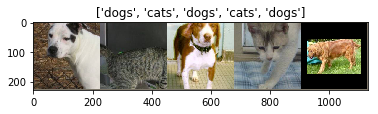

In [22]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

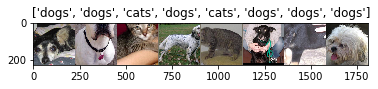

In [23]:
# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

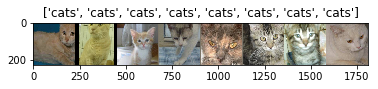

In [24]:
# Get a batch of validation data
inputs, classes = next(iter(dset_loaders['valid']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

## Creating VGG Model

The torchvision module comes with a zoo of popular CNN architectures which are already trained on [ImageNet](http://www.image-net.org/) (1.2M training images). When called the first time, if ```pretrained=True``` the model is fetched over the internet and downloaded to ```~/.torch/models```.
For next calls, the model will be directly read from there.

In [37]:
del model_rnn._modules['decoder']

In [44]:
a = list(model_rnn.modules())

In [50]:
print(a)
a.pop()
print(a)

[RNNModel (
  (drop): Dropout (p = 0.5)
  (encoder): Embedding(3, 64)
  (rnn): LSTM(64, 128, num_layers=2, dropout=0.5)
), Dropout (p = 0.5), Embedding(3, 64)]
[RNNModel (
  (drop): Dropout (p = 0.5)
  (encoder): Embedding(3, 64)
  (rnn): LSTM(64, 128, num_layers=2, dropout=0.5)
), Dropout (p = 0.5)]


In [34]:
model_rnn = RNNModel('LSTM', 3, 64, 128, 2)

In [33]:
import torch.nn as nn
from torch.autograd import Variable

class RNNModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, rnn_type, ntoken, ninp, nhid, nlayers, dropout=0.5, tie_weights=False):
        super(RNNModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        if rnn_type in ['LSTM', 'GRU']:
            self.rnn = getattr(nn, rnn_type)(ninp, nhid, nlayers, dropout=dropout)
        else:
            try:
                nonlinearity = {'RNN_TANH': 'tanh', 'RNN_RELU': 'relu'}[rnn_type]
            except KeyError:
                raise ValueError( """An invalid option for `--model` was supplied,
                                 options are ['LSTM', 'GRU', 'RNN_TANH' or 'RNN_RELU']""")
            self.rnn = nn.RNN(ninp, nhid, nlayers, nonlinearity=nonlinearity, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

        # Optionally tie weights as in:
        # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
        # https://arxiv.org/abs/1608.05859
        # and
        # "Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling" (Inan et al. 2016)
        # https://arxiv.org/abs/1611.01462
        if tie_weights:
            if nhid != ninp:
                raise ValueError('When using the tied flag, nhid must be equal to emsize')
            self.decoder.weight = self.encoder.weight

        self.init_weights()

        self.rnn_type = rnn_type
        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        if self.rnn_type == 'LSTM':
            return (Variable(weight.new(self.nlayers, bsz, self.nhid).zero_()),
                    Variable(weight.new(self.nlayers, bsz, self.nhid).zero_()))
        else:
            return Variable(weight.new(self.nlayers, bsz, self.nhid).zero_())

In [51]:
model_vgg

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [53]:
del model_vgg.classifier[0]

TypeError: 'Sequential' object doesn't support item deletion

In [26]:
# typaae(model_vgg.named_modules())
# type(model_vgg._modules['classifier'])
# del model_vgg._modules['classifier'][6]
# a = list(model_vgg.classifier)

In [28]:
a.pop()

Linear (4096 -> 1000)

In [31]:
b = nn.Sequential(*a)

In [32]:
b

Sequential (
  (0): Linear (25088 -> 4096)
  (1): ReLU (inplace)
  (2): Dropout (p = 0.5)
  (3): Linear (4096 -> 4096)
  (4): ReLU (inplace)
  (5): Dropout (p = 0.5)
)

In [54]:
model_resnet= models.resnet18()

In [57]:
del model_resnet.bn1

In [59]:
del model_resnet.layer1[0].conv1

In [60]:
model_resnet

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (layer2): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), strid

In [58]:
model_resnet

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (layer2)

In [5]:
model_vgg = models.vgg16(pretrained=True)

We will first use VGG Model without any modification. In order to interpret the results, we need to import the 1000 ImageNet categories, available at: 
https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

In [26]:
import json
#fpath = '/home/ubuntu/dldiy-materials/imagenet_class_index.json'
fpath = '/home/lelarge/courses/dldiy-materials/imagenet_class_index.json'
with open(fpath) as f:
    class_dict = json.load(f)
dic_imagenet = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [27]:
dic_imagenet[:4]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark']

In [28]:
#if use_gpu:
#    inputs_try , labels_try = Variable(inputs_try.cuda()),Variable(labels_try.cuda())
#else:
#    inputs_try , labels_try = Variable(inputs_try),Variable(labels_try)

inputs_try , labels_try = var_cgpu(inputs_try,use_gpu),var_cgpu(labels_try,use_gpu)

if use_gpu:
    model_vgg = model_vgg.cuda()

In [29]:
outputs_try = model_vgg(inputs_try)

In [30]:
outputs_try

Variable containing:
-3.1762e+00 -5.2067e+00  6.5453e+00  ...  -1.1002e-01 -5.7614e-01  6.0399e+00
-3.0014e+00 -1.1978e+00 -1.8370e+00  ...  -2.5993e+00  1.1604e+00  2.1702e+00
-4.8128e-01  7.4346e-01  1.8858e+00  ...  -3.1164e+00 -5.9301e-01  5.8435e+00
-8.5520e-01 -2.0216e+00  4.7656e-01  ...  -3.5519e+00  3.1139e+00  4.7636e+00
-3.9566e-01  1.0954e-01 -1.1349e+00  ...   9.4445e-01  2.3675e+00  6.2101e-01
[torch.FloatTensor of size 5x1000]

For a better interpretation, we transform this output in probablities thanks to the [softmax function](https://en.wikipedia.org/wiki/Softmax_function) and then take the max.

In [86]:
m_softm = nn.Softmax()
vals_try,preds_try = torch.max(m_softm(outputs_try.data),1)

In [38]:
vals_try

Variable containing:
 0.5716
 0.4041
 0.8578
 0.2798
 0.6269
[torch.FloatTensor of size 5]

In [39]:
print([dic_imagenet[i] for i in preds_try.data])

['Great_Dane', 'Egyptian_cat', 'Brittany_spaniel', 'Siberian_husky', 'golden_retriever']


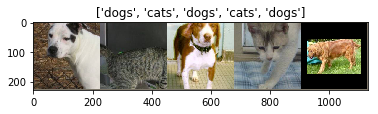

In [40]:
#corresponding images
out = torchvision.utils.make_grid(inputs_try.data.cpu())

imshow(out, title=[dset_classes[x] for x in labels_try.data.cpu()])

### Modifying the last layer and setting the gradient false to all layers

In [41]:
print(model_vgg)

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

An illustration taken from [Deep Learning with PaddlePaddle](http://book.paddlepaddle.org/)

<img src='vgg16.png'>

In this practical example, our goal is to use the already trained model and just change the number of output classes. To this end we replace the last ```nn.Linear``` layer trained for 1000 classes to ones with 2 classes. In order to freeze the weights of the other layers during training, we set the field ```required_grad=False```. In this manner no gradient will be computed for them during backprop and hence no update in the weights. Only the weights for the 2 class layer will be updated.

In [42]:
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier._modules['6'] = nn.Linear(4096, 2)
#model_vgg.classifier[6].out_features = 2
#for param in model_vgg.classifier[6].parameters():
#    param.requires_grad = True

In [43]:
print(model_vgg.classifier)

Sequential (
  (0): Linear (25088 -> 4096)
  (1): ReLU (inplace)
  (2): Dropout (p = 0.5)
  (3): Linear (4096 -> 4096)
  (4): ReLU (inplace)
  (5): Dropout (p = 0.5)
  (6): Linear (4096 -> 2)
)


In [44]:
if use_gpu:
    model_vgg = model_vgg.cuda()

### Calculating preconvoluted features

In [45]:
def preconvfeat(dataset):
    conv_features = []
    labels_list = []
    for data in dataset:
        inputs,labels = data
        if use_gpu:
            inputs , labels = Variable(inputs.cuda()),Variable(labels.cuda())
        else:
            inputs , labels = Variable(inputs),Variable(labels)
        
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [46]:
x_try = model_vgg.features(inputs_try)

In [47]:
?x_try

In [48]:
x_try.data.shape

torch.Size([5, 512, 7, 7])

In [49]:
7*7*512

25088

In [50]:
labels_try

Variable containing:
 1
 0
 1
 0
 1
[torch.LongTensor of size 5]

In [51]:
labels_try.data


 1
 0
 1
 0
 1
[torch.LongTensor of size 5]

In [ ]:
%%time
conv_feat_train,labels_train = preconvfeat(dset_loaders['train'])

In [ ]:
%%time
conv_feat_val,labels_val = preconvfeat(dset_loaders['valid'])

In [ ]:
#%mkdir /home/ubuntu/dldiy-materials/sample/vgg16/
#%mkdir /home/ubuntu/data/dogscats/vgg16

In [ ]:
save_array(data_dir+'/vgg16/conv_feat_train.bc',conv_feat_train)
save_array(data_dir+'/vgg16/labels_train.bc',labels_train)
save_array(data_dir+'/vgg16/conv_feat_val.bc',conv_feat_val)
save_array(data_dir+'/vgg16/labels_val.bc',labels_val)

### Loading Preconvoluted features

In [52]:
conv_feat_train = load_array(data_dir+'/vgg16/conv_feat_train.bc')
labels_train = load_array(data_dir+'/vgg16/labels_train.bc')
conv_feat_val = load_array(data_dir+'/vgg16/conv_feat_val.bc')
labels_val = load_array(data_dir+'/vgg16/labels_val.bc')

In [53]:
conv_feat_train.shape

(160, 512, 7, 7)

## Training fully connected module

### Creating loss function and optimizer

In [54]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

### Creating Data generator

In [55]:
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

### Training the model

In [56]:
def train_model(model,size,conv_feat=None,labels=None,epochs=1,optimizer=None,train=True,shuffle=True):
    if train:
        model.train()
    else:
        model.eval()
        
    for epoch in range(epochs):
        batches = data_gen(conv_feat=conv_feat,labels=labels,shuffle=shuffle)
        total = 0
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in batches:
            if use_gpu:
                inputs , classes = Variable(torch.from_numpy(inputs).cuda()),Variable(torch.from_numpy(classes).cuda())
            else:
                inputs , classes = Variable(torch.from_numpy(inputs)),Variable(torch.from_numpy(classes))
                
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs,classes)           
            if train:
                if optimizer is None:
                    raise ValueError('Pass optimizer for train mode')
                optimizer = optimizer
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    

In [57]:
%%time
(train_model(model=model_vgg.classifier,size=dset_sizes['train'],conv_feat=conv_feat_train,labels=labels_train,
            epochs=10,optimizer=optimizer_vgg,train=True,shuffle=True))

Loss: 0.0085 Acc: 0.7562
Loss: 0.0039 Acc: 0.9625
Loss: 0.0029 Acc: 0.9750
Loss: 0.0023 Acc: 0.9875
Loss: 0.0020 Acc: 0.9938
Loss: 0.0016 Acc: 0.9875
Loss: 0.0015 Acc: 0.9938
Loss: 0.0016 Acc: 0.9875
Loss: 0.0015 Acc: 0.9875
Loss: 0.0013 Acc: 0.9875
CPU times: user 17.5 s, sys: 972 ms, total: 18.5 s
Wall time: 6.66 s


In [58]:
train_model(conv_feat=conv_feat_val,labels=labels_val,model=model_vgg.classifier
            ,size=dset_sizes['valid'],train=False,shuffle=False)

Loss: 0.0017 Acc: 1.0000


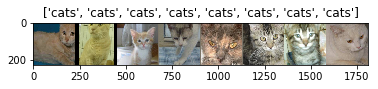

In [59]:
# Get a batch of training data
inputs, classes = next(iter(dset_loaders['valid']))

out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

In [63]:
inputs = Variable(torch.from_numpy(conv_feat_val[:n_images]))
inputs = inputs.view(inputs.size(0), -1)
if use_gpu:
    outputs = model_vgg.classifier(inputs.cuda())
else:
    outputs = model_vgg.classifier(inputs)
print(m(outputs))

Variable containing:
 0.9927  0.0073
 0.9990  0.0010
 0.9989  0.0011
 0.9330  0.0670
 0.9994  0.0006
 0.9997  0.0003
 0.9986  0.0014
 0.9982  0.0018
[torch.FloatTensor of size 8x2]



In [64]:
labels_val[:n_images]

array([0, 0, 0, 0, 0, 0, 0, 0])

## Creating VGG model by hand

In [65]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class VGG_16(nn.Module):

    def __init__(self,num_classes=1000):
        super(VGG_16, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.convblock4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )       

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def init_weight(self,w):
        i=0
        for idx, m in enumerate(self.children()):
            for idy, msub in enumerate(m.children()):
                classname = msub.__class__.__name__
                if classname.find('Conv') != -1:
                    msub.weight.data = w['features.'+str(i)+'.weight']#.clone()
                    msub.bias.data = w['features.'+str(i)+'.bias']#.clone()
                    print(msub,'features.'+str(i))
                if classname.find('Linear') != -1:
                    msub.weight.data = w['classifier.'+str(i-31)+'.weight']#.clone()
                    msub.bias.data = w['classifier.'+str(i-31)+'.bias']#.clone()
                    print(msub,'classifier.'+str(i-31))
                i +=1
        

net = VGG_16()
print(net)

VGG_16 (
  (convblock1): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (convblock2): Sequential (
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (convblock3): Sequential (
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU (inplace)
    (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))


### Filling our model with learned weights

Now that we created VGG model, we do not want to train it from scratch. Fortunately, this has been done for us and we only need to get the weights and fill them properly which is the purpose of the init_weight method defined above.

In [66]:
import torch.utils.model_zoo as model_zoo
weights = model_zoo.load_url('https://download.pytorch.org/models/vgg16-397923af.pth')

In [67]:
type(weights)

collections.OrderedDict

In [68]:
net.init_weight(weights)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.0
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.2
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.5
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.7
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.10
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.12
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.14
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.17
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.19
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.21
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.24
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.26
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1)

To understand what the init_weight method is doing:

In [69]:
weights.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [70]:
inc=0
for idx, m in enumerate(net.children()):
    for idy, msub in enumerate(m.children()):
        print(inc, '->', msub)
        inc +=1

0 -> Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 -> ReLU (inplace)
2 -> Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 -> ReLU (inplace)
4 -> MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
5 -> Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 -> ReLU (inplace)
7 -> Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 -> ReLU (inplace)
9 -> MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
10 -> Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 -> ReLU (inplace)
12 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 -> ReLU (inplace)
14 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 -> ReLU (inplace)
16 -> MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
17 -> Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18 -> ReLU (inplace)
19 -> Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

Now our model is ready for use, let's try it!

In [71]:
for param in net.parameters():
    param.requires_grad = False
net.classifier._modules['6'] = nn.Linear(4096, 2)

In [72]:
net

VGG_16 (
  (convblock1): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (convblock2): Sequential (
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (convblock3): Sequential (
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU (inplace)
    (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))


In [73]:
if use_gpu:
    net = net.cuda()

In [74]:
optimizer_net = torch.optim.SGD(net.classifier[6].parameters(),lr = lr)

In [75]:
%%time
(train_model(model=net.classifier,size=dset_sizes['train'],conv_feat=conv_feat_train,labels=labels_train,
            epochs=10,optimizer=optimizer_net,train=True,shuffle=True))

Loss: 0.0109 Acc: 0.5938
Loss: 0.0034 Acc: 0.9688
Loss: 0.0029 Acc: 0.9688
Loss: 0.0021 Acc: 0.9812
Loss: 0.0018 Acc: 0.9812
Loss: 0.0016 Acc: 0.9812
Loss: 0.0012 Acc: 1.0000
Loss: 0.0013 Acc: 0.9938
Loss: 0.0015 Acc: 0.9812
Loss: 0.0014 Acc: 0.9875
CPU times: user 16.7 s, sys: 1.26 s, total: 18 s
Wall time: 6.43 s


Let's see what it gives on our 'try' sample (5 random images from the validation set).

In [76]:
new_outputs_try = net(inputs_try)

In [80]:
new_outputs_try.data


-2.3383  1.3432
 2.2118 -2.9348
-3.3123  2.8153
 1.0792 -1.1584
-1.5835  1.4730
[torch.FloatTensor of size 5x2]

In [88]:
new_vals_try,new_preds_try = torch.max(m_softm(new_outputs_try.data),1)

In [89]:
new_preds_try

Variable containing:
 1
 0
 1
 0
 1
[torch.LongTensor of size 5]

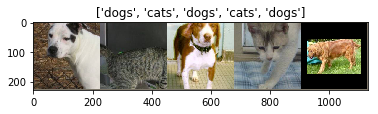

In [90]:
#corresponding images
out = torchvision.utils.make_grid(inputs_try.data.cpu())

imshow(out, title=[dset_classes[x] for x in labels_try.data.cpu()])

In [91]:
new_vals_try

Variable containing:
 0.9754
 0.9942
 0.9978
 0.9036
 0.9551
[torch.FloatTensor of size 5]